In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# python packages
import sys
import os
import glob
from socket import gethostname
#from collections import defaultdict

import numpy as np
import numpy.lib.recfunctions

# scipy-project imports
import scipy.interpolate
import scipy.optimize
import scipy.stats
from scipy.special import erf, erfinv, erfc

# Misc
from ic_data import load_data, prepare_directory
import ic_utils as utils

# Plotting
import seaborn as sns
from matplotlib.colors import LogNorm
plt = utils.plotting("pdf")

import matplotlib as mpl
#mpl.rcdefaults()
"""
tw=6
rcParams = dict()
rcParams["figure.figsize"] = (tw, tw / 1.6)
rcParams["font.size"]=20
mpl.rcParams.update(rcParams)
#"""

plt = utils.plotting("pdf")

from collections import defaultdict

from scipy.interpolate import UnivariateSpline

import time

from skylab.prior_generator import UhecrPriorGenerator

print ":)"


:)


In [13]:
import cPickle as pickle

## Read UHECR data

In [8]:
basepath, inipath, savepath, crpath, figurepath = utils.get_paths(gethostname())
dec_bound = np.radians(-5.)

pg = UhecrPriorGenerator(6)
ra, dec, energy, sigma_reco = pg._get_UHECR_positions(60, crpath)

uhecr_dec_mask = dec>=dec_bound
print np.count_nonzero(uhecr_dec_mask), len(uhecr_dec_mask)

68 175


## Read Background trials

In [9]:
print(gethostname())

basepath, inipath, savepath, crpath, figurepath = utils.get_paths(gethostname())

folder = "*BCKG*" #_niter4_ecut70_followupfactor2_nsideparam6_burnFalse_nsamples7"

bg_inputfiles = sorted(glob.glob(os.path.join(savepath, folder, "job*_hotspots_?.txt")))

print(bg_inputfiles[0], bg_inputfiles[-1])
print(len(bg_inputfiles))

bg_TS = []
for i,f in enumerate(bg_inputfiles):
    a = np.genfromtxt(f, names=True)
    bg_TS.append(a[['North', 'South', 'ra', 'dec', 'nsources', 'best', 'energy', 'deflection']])
bg_TS = np.array(bg_TS)
print "done"

cobalt03.icecube.wisc.edu
('/data/user/lschumacher/projects/stacking/hotspot_fitting/1506356254_BCKG5_niter4_ecut70_followupfactor2_nsideparam6_burnFalse_mu0.0_nsamples7/job2_hotspots_0.txt', '/data/user/lschumacher/projects/stacking/hotspot_fitting/BCKG4/job9_hotspots_3.txt')
4996
done


In [14]:
current_time = int(time.time())
print current_time

name = "{}_bg_TS_fixed-gamma.pickle".format(current_time)
with open(os.path.join(savepath, name), "wb") as f:
    pickle.dump(bg_TS, f, protocol=2)

1520257109


## Read Signal trials

In [15]:
ecuts=[70,85,100]
timecut = 1505897717 # before this time we don't have source positions
mdparams = [3.0, 6.0]
clen = len(utils.colors)

signals = {}
for md in mdparams:
    print md
    signals[md] = defaultdict()
    for ecut in ecuts:
        print " * "*20
        print ecut
        a = np.genfromtxt(bg_inputfiles[0], names=True)
        hotspots = len(a[a['deflection']==6])

        folders = sorted(glob.glob(os.path.join(savepath, "150*_SIGNAL*_niter4_ecut{}*_nsamples7*_mdparams{}".format(ecut, md))))
        signals[md][ecut] = {}
        for f in folders:
            parts = f.split("_")
            if int(parts[1][-len(str(timecut)):])<timecut: continue
            for p in parts:
                if "mu" in p:
                    ID = float(p[2:])
            if ID not in signals[md][ecut].keys():
                signals[md][ecut][ID] = []
            inputfiles = sorted(glob.glob(os.path.join(savepath, f, "job*_hotspots_*.txt")))
            for infile in inputfiles:
                signals[md][ecut][ID].append(np.genfromtxt(infile, names=True))
print "done"

3.0
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
70
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
85
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
100
6.0
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
70
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
85
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
100
done


In [17]:
name = "{}_signal_TS_fix-gamma.pickle".format(current_time)
with open(os.path.join(savepath, name), "wb") as f:
    pickle.dump(signals, f, protocol=2)

## Raw flux for ${n}_{inj}$ -> flux calculation

/home/lschumacher/my_virtualenvs/my_skylab/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


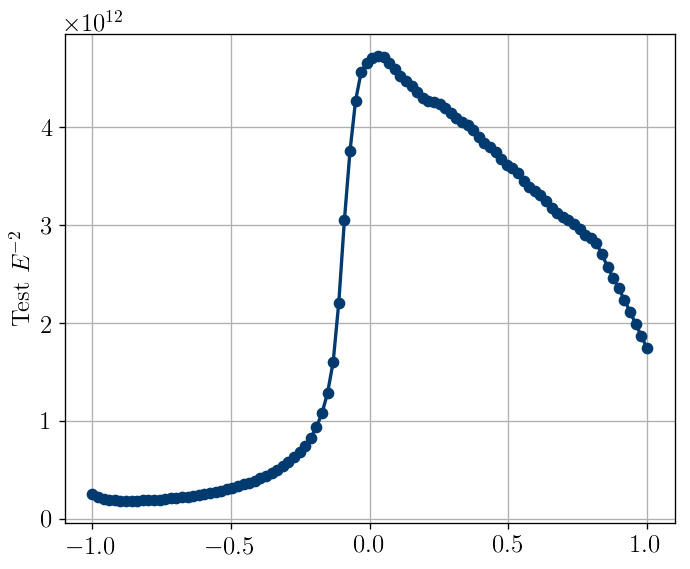

:)


In [16]:
## Flux calculations
s_sens = np.genfromtxt(os.path.join(crpath,"sensitivity_stefan_7yr.txt"), unpack=True, delimiter=", ")
s_disc = np.genfromtxt(os.path.join(crpath,"discpot_stefan_7yr.txt"), unpack=True, delimiter=", ")

sinDec = np.loadtxt(os.path.join(crpath, "sindec_bins.npy"))

raw_fluxes = np.loadtxt(os.path.join(crpath, "raw_fluxes.npy"))
sum_flux = raw_fluxes.sum(axis=0)

sinDec_x = np.linspace(min(sinDec), max(sinDec), num=100)
flux_spline = scipy.interpolate.InterpolatedUnivariateSpline(
                                (sinDec[1:] + sinDec[:-1]) / 2.,
                                sum_flux/(2*np.pi*(sinDec[1:] - sinDec[:-1])), k=2)

#"""
plt.plot(sinDec_x, flux_spline(sinDec_x))
#plt.semilogy()
plt.ylabel(r"Test $E^{-2}$")
plt.show()
#"""
print ":)"

## Signal acceptance for $n_{inj}$ to $\hat{n}_{true}$ calculation

In [16]:
## Flux calculations
sinDec = np.loadtxt(os.path.join(crpath, "sindec_bins_2.npy"))
acceptance = np.loadtxt(os.path.join(crpath, "signal_acceptance.npy"))

sinDec_x = np.linspace(min(sinDec), max(sinDec), num=100)
## Acceptance is normed such that max(acceptance)=1 ##
## For injection: n_inj = n * acceptance(dec) ##
## Reverse that: n = n_inj/acceptance(dec) ##
acceptance /= max(acceptance)
acceptance_spline = scipy.interpolate.InterpolatedUnivariateSpline(
                                (sinDec[1:] + sinDec[:-1]) / 2.,
                                acceptance, k=2)

"""
plt.plot(sinDec_x, acceptance_spline(sinDec_x))
plt.semilogy()
plt.ylabel(r"acceptance")
plt.xlabel("sin(dec)")
plt.show()
#"""
print ":)"

:)


## Re-calculate $\hat{n}_{true}$ from $n_{inj}$ and compare to $n_{true}$ as full-circle test

/home/lschumacher/my_virtualenvs/my_skylab/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


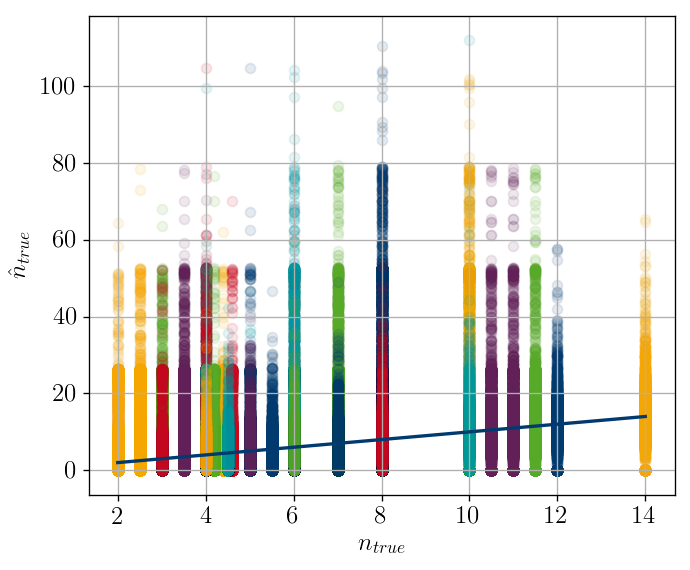

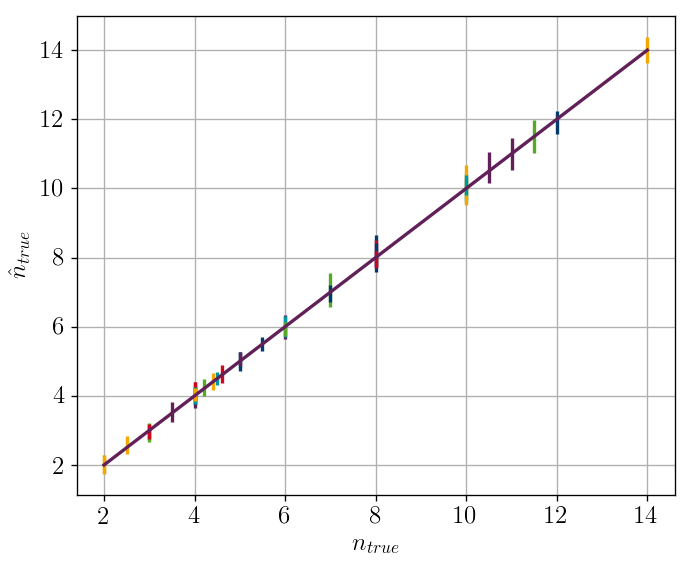

Nice! :)


In [17]:
n_true = dict()
for md in mdparams:
    n_true[md] = dict()
    for ecut in ecuts:
        n_true[md][ecut] = dict()
        for i,ak in enumerate(signals[md][ecut]):
            sig = np.array(signals[md][ecut][ak])
            n_true[md][ecut][ak] = sig['n_inj']/acceptance_spline(np.sin(sig['dec_inj']))

for md in mdparams:
    for ecut in ecuts:
        for i,ak in enumerate(n_true[md][ecut]):
            plt.figure(1)
            plt.scatter(ak*np.ones_like(n_true[md][ecut][ak]), n_true[md][ecut][ak], alpha=0.1)
            plt.figure(2)
            plt.errorbar(ak, np.mean(n_true[md][ecut][ak]), yerr=np.std(n_true[md][ecut][ak])/np.sqrt(len(n_true[md][ecut][ak])))
            
plt.figure(2)
x = np.linspace(2, 14)
plt.plot(x, x, markersize=0)
plt.ylabel(r"$\hat{n}_{true}$")
plt.xlabel(r"$n_{true}$")
plt.figure(1)
x = np.linspace(2, 14)
plt.plot(x, x, markersize=0)
plt.ylabel(r"$\hat{n}_{true}$")
plt.xlabel(r"$n_{true}$")
plt.show()
print "Nice! :)"

## Evaluate TS

md:  3.0
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
70
mu injected:  8.0
4


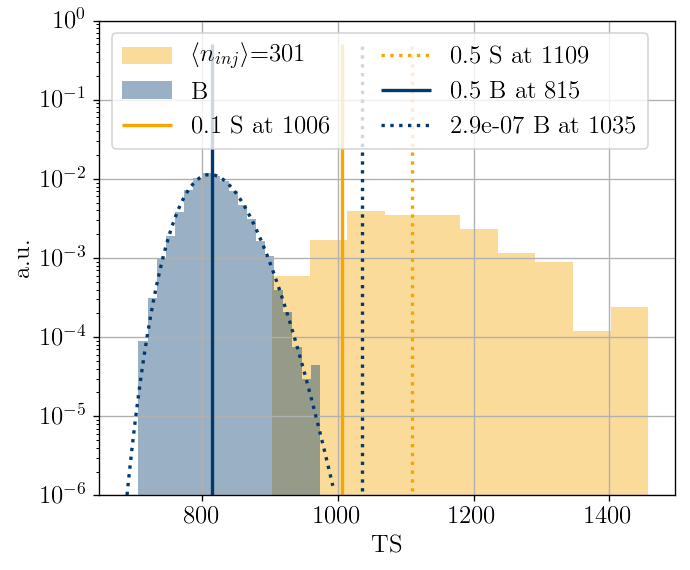

mu injected:  2.0
5


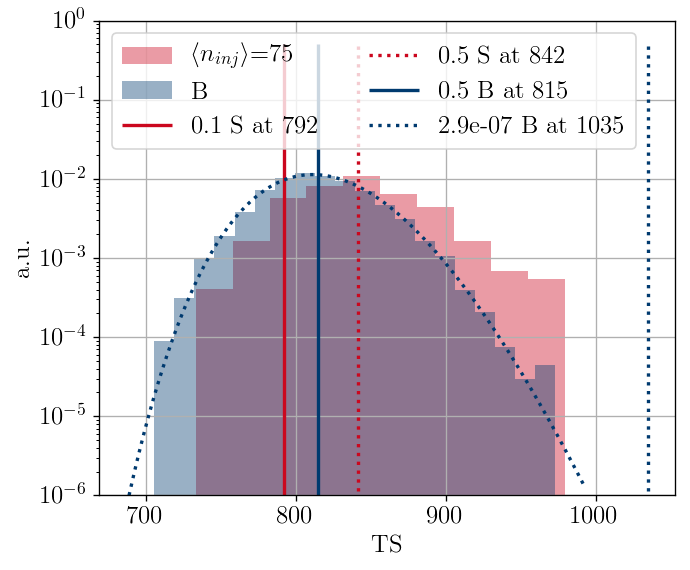

mu injected:  4.0
6


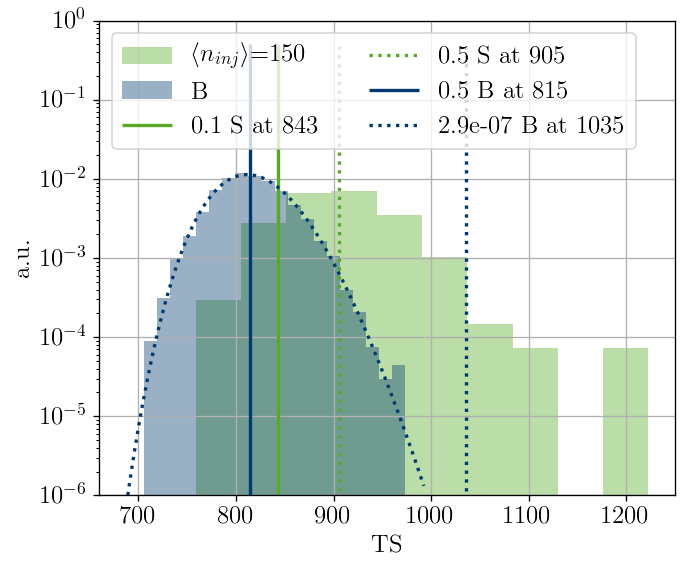

mu injected:  7.0
7


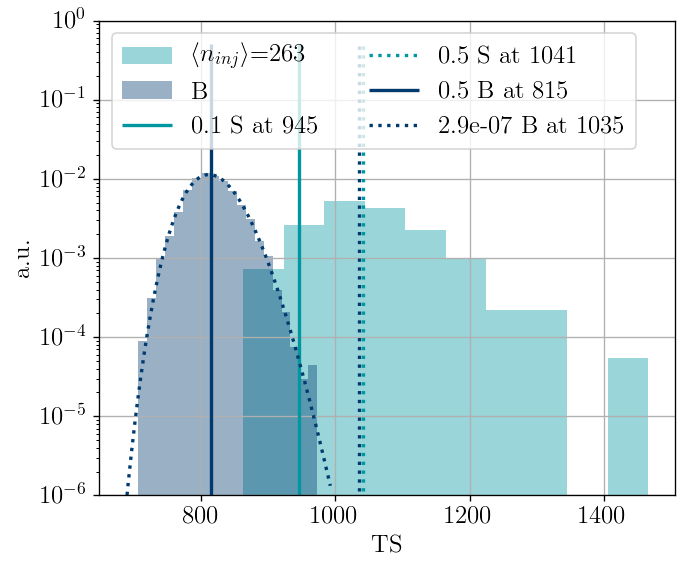

8


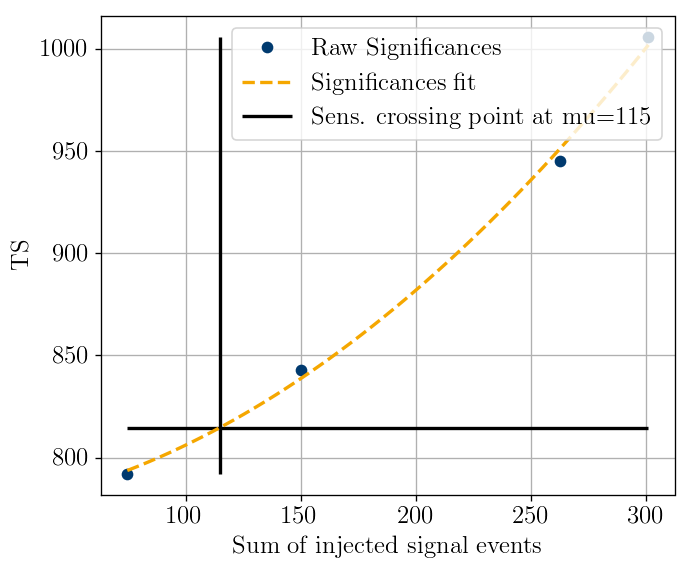

Sens. crossing point at n=3
9


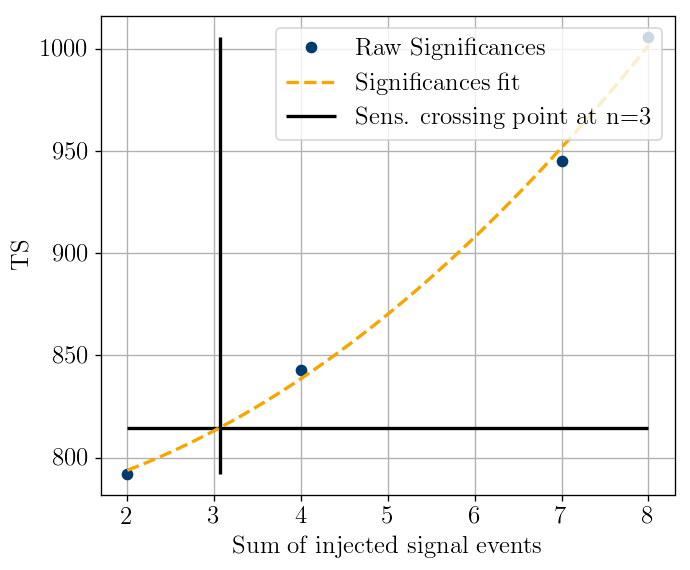

10


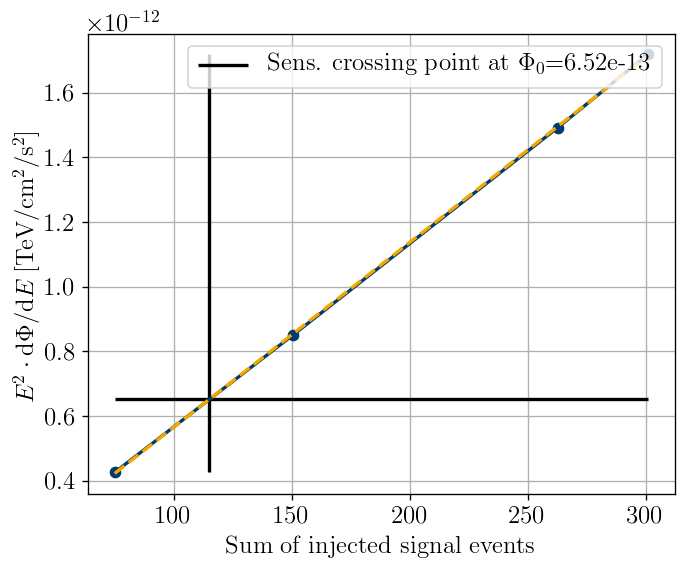

11


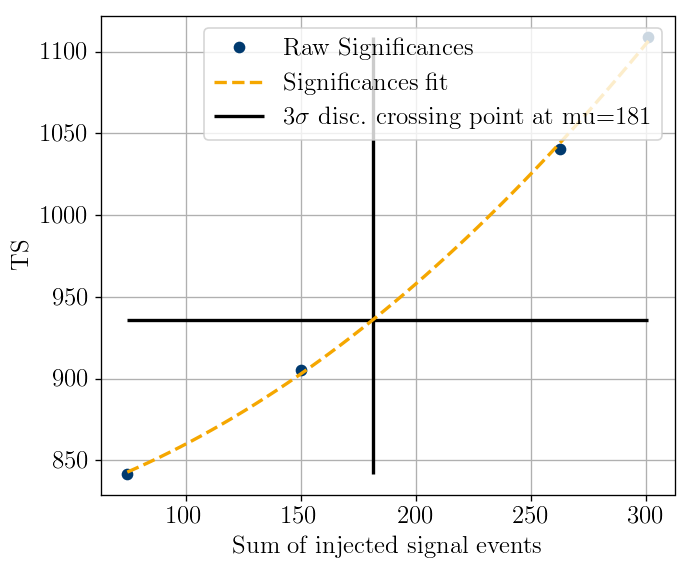

3$\sigma$ disc. crossing point at n=5
12


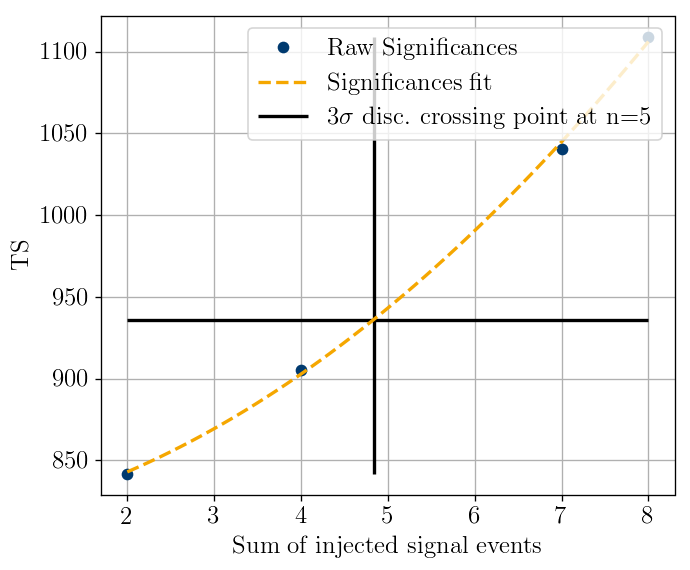

13


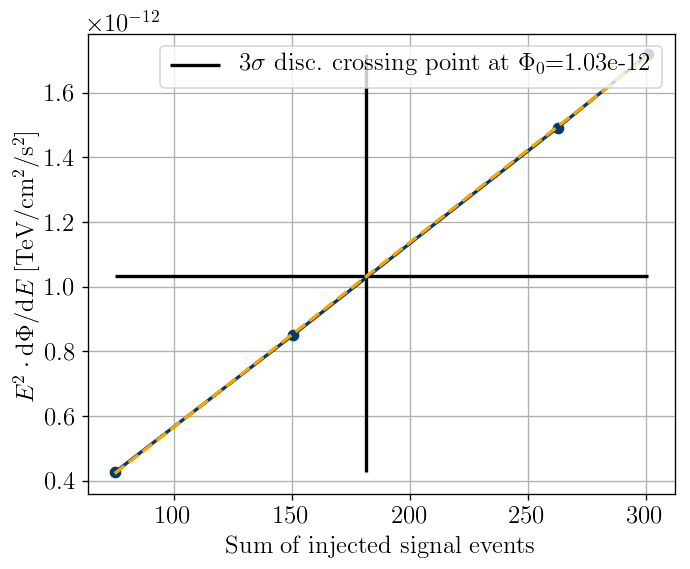

14


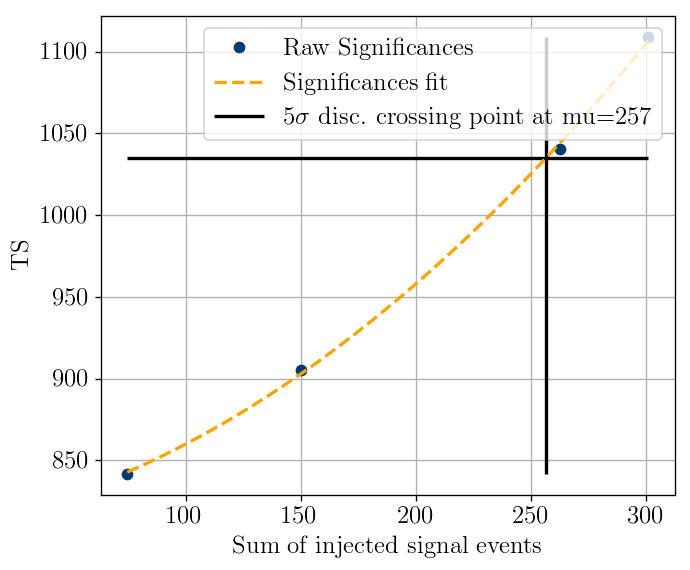

5$\sigma$ disc. crossing point at n=7
15


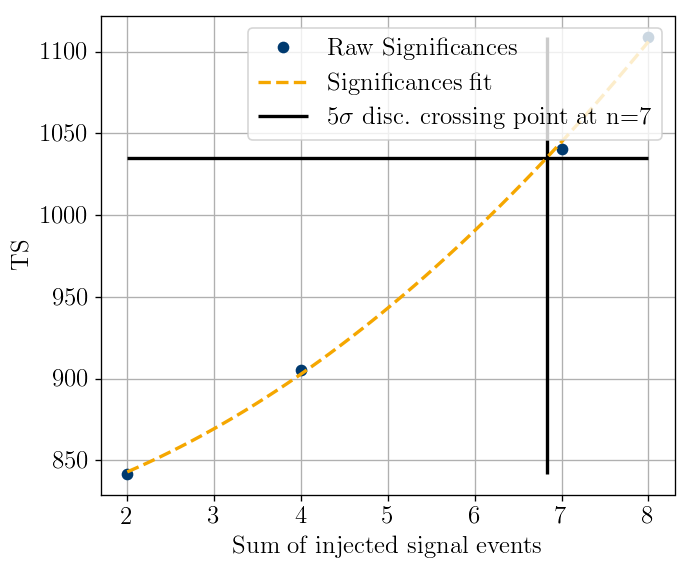

16


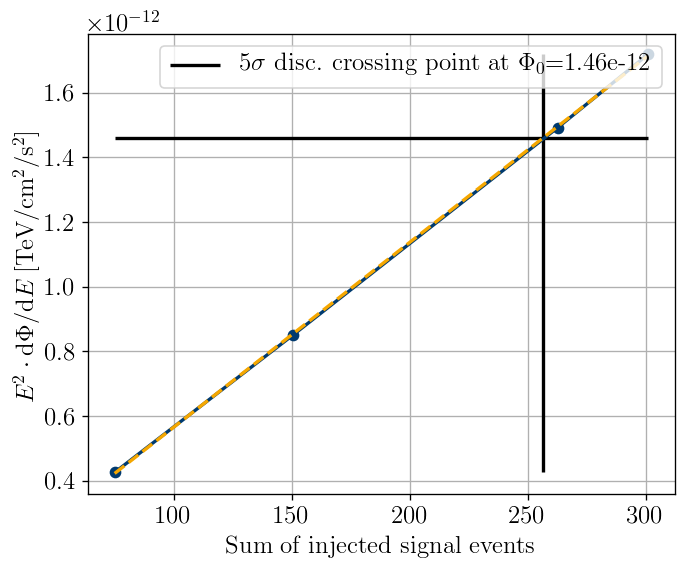

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
85
mu injected:  8.0
17


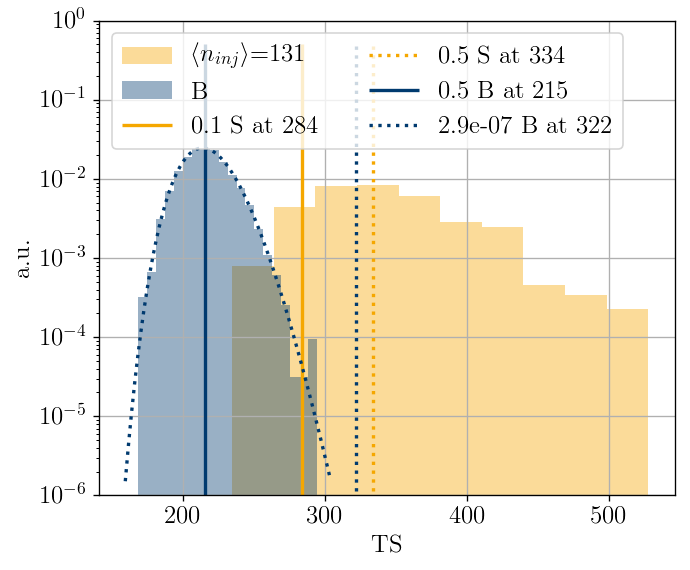

mu injected:  10.0
18


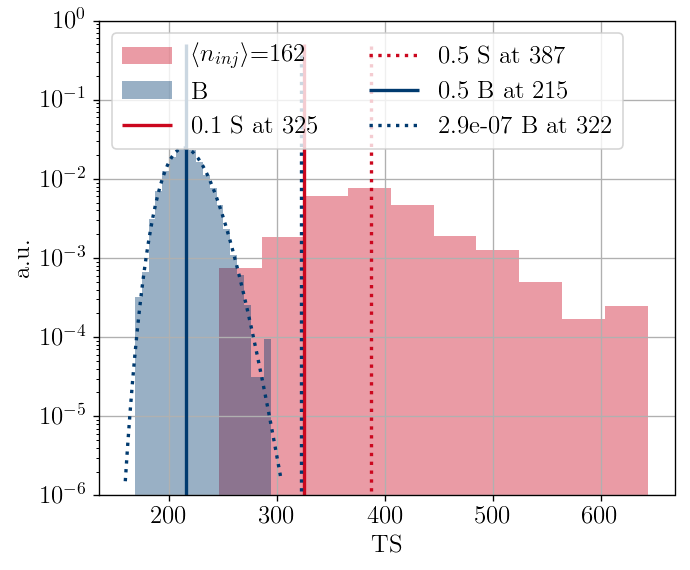

mu injected:  4.0
19


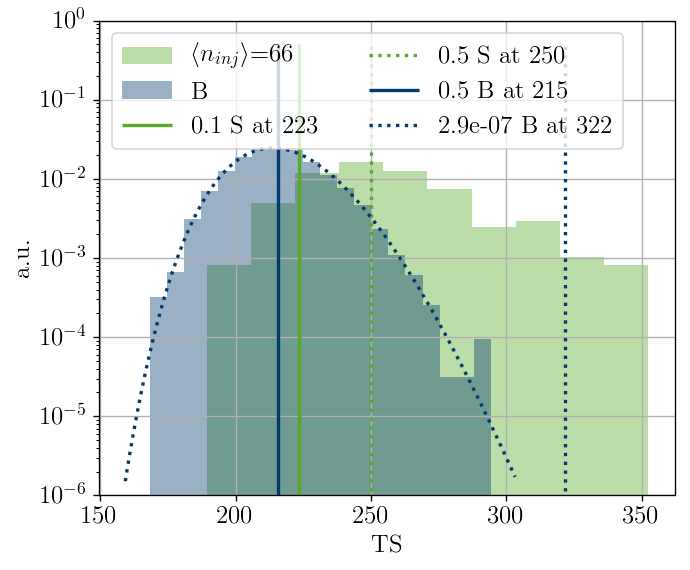

mu injected:  2.0
20


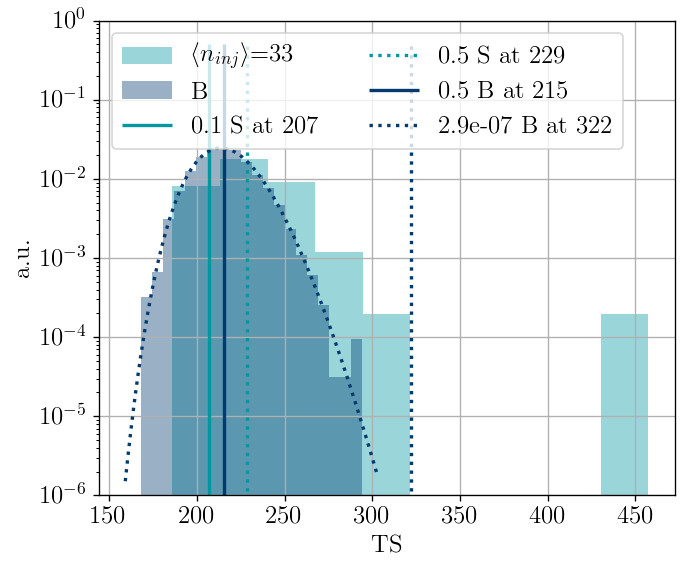

mu injected:  6.0
21


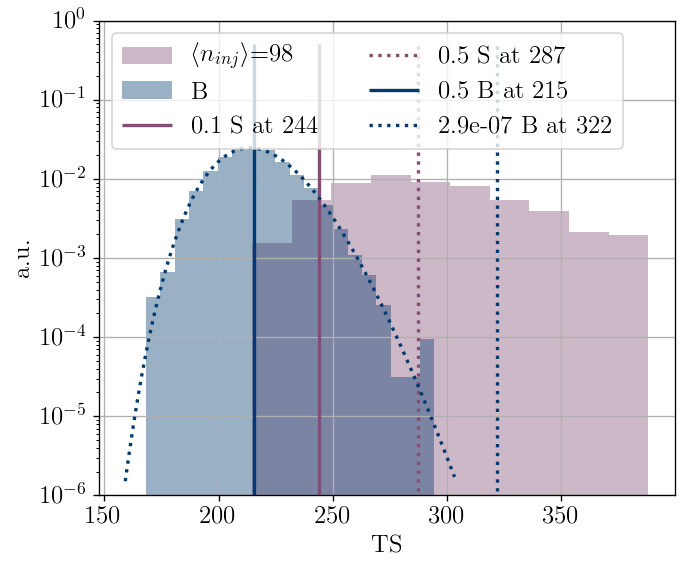

22


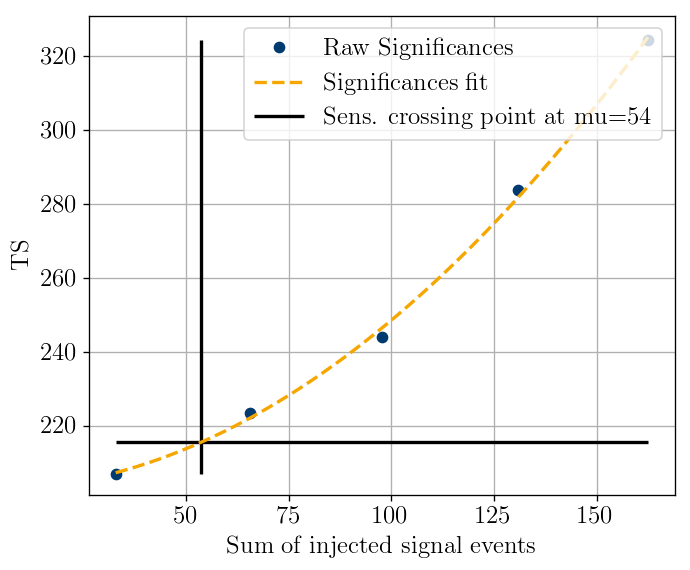

Sens. crossing point at n=3
23


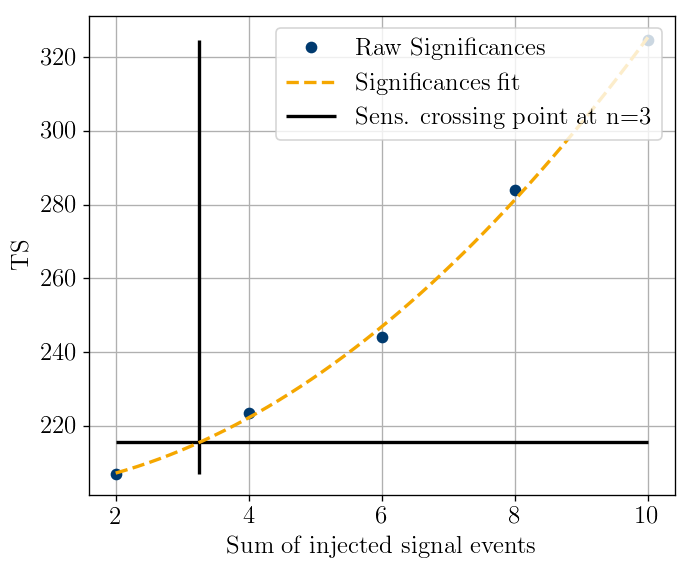

24


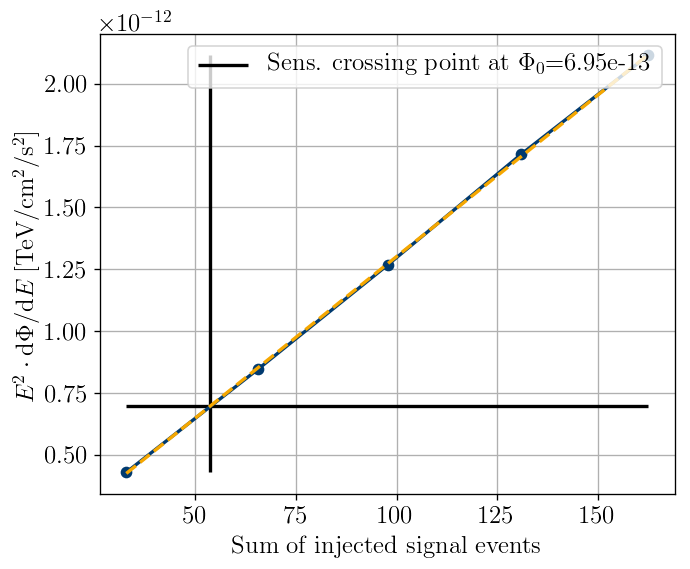

25


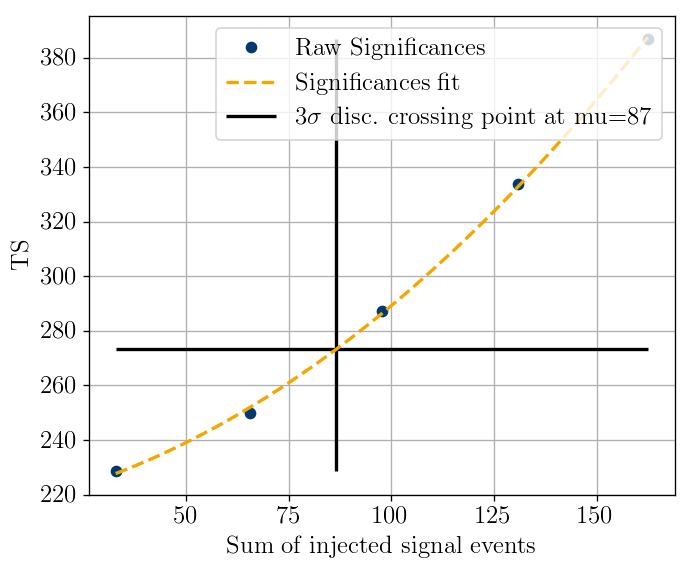

3$\sigma$ disc. crossing point at n=5
26


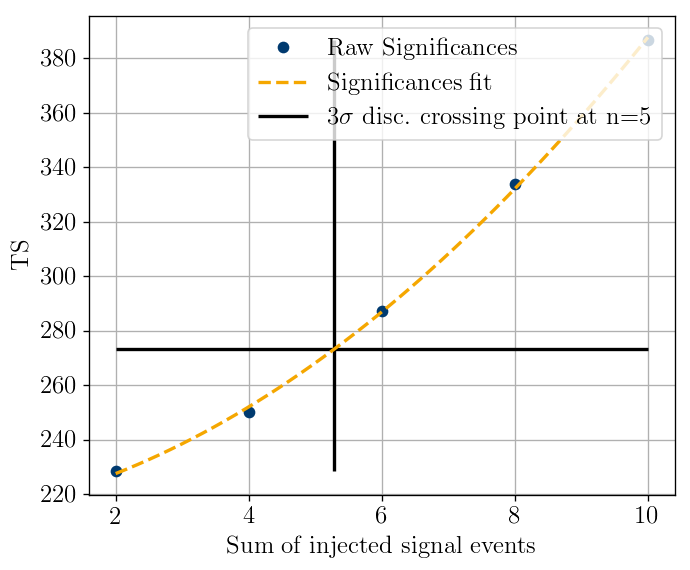

27


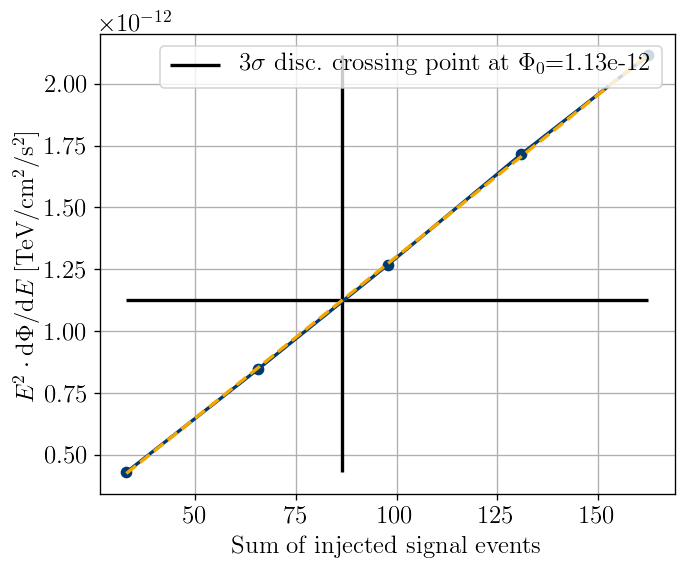

28


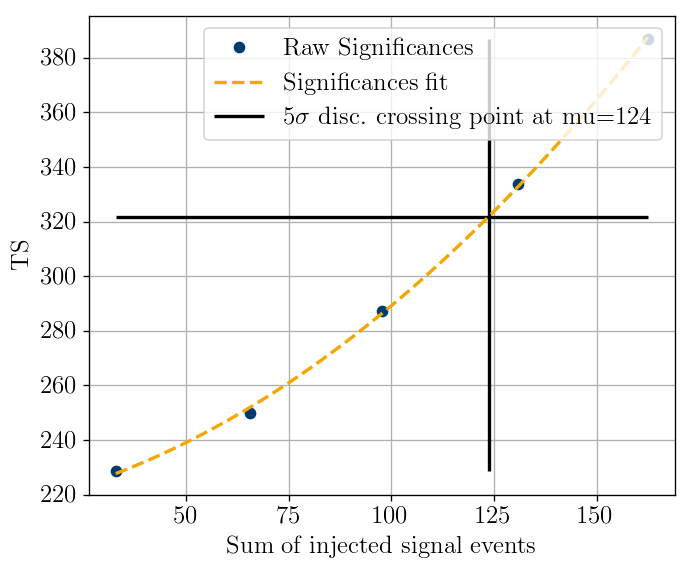

5$\sigma$ disc. crossing point at n=8
29


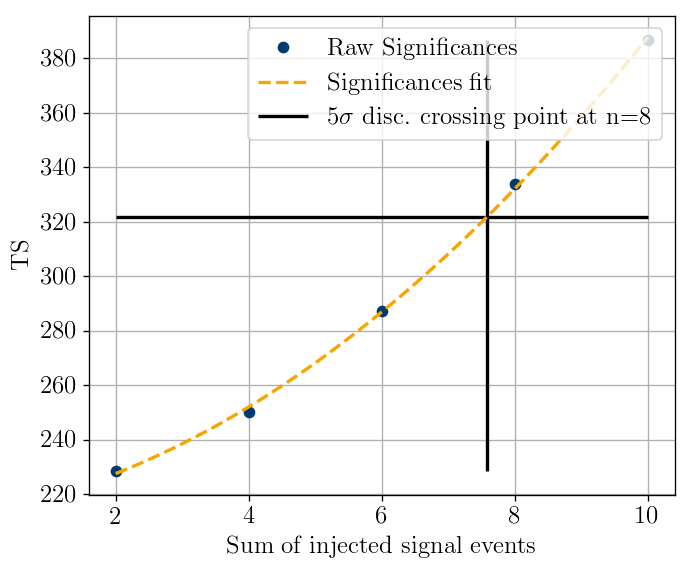

30


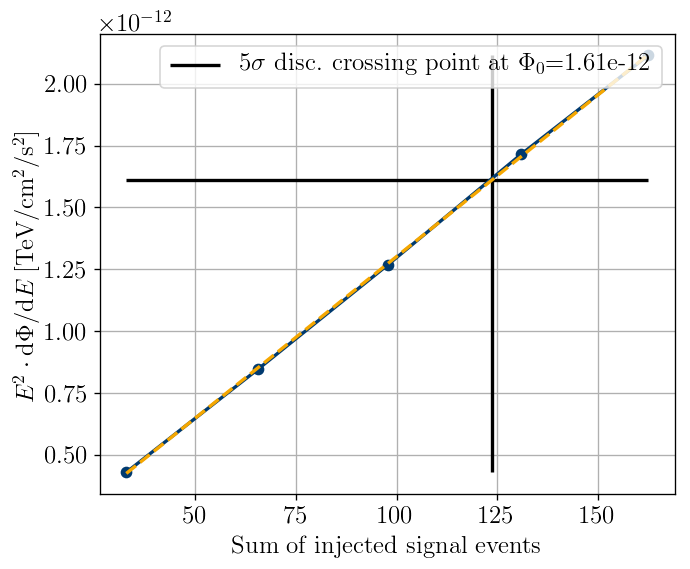

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
100
mu injected:  10.0
31


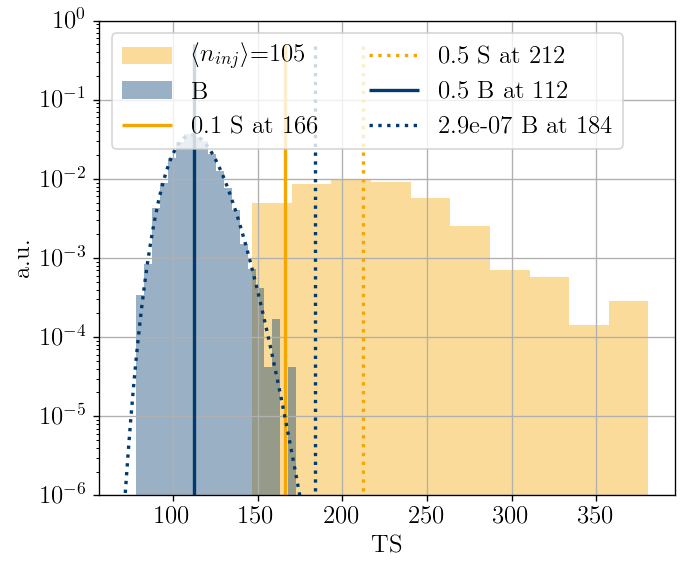

mu injected:  3.0
32


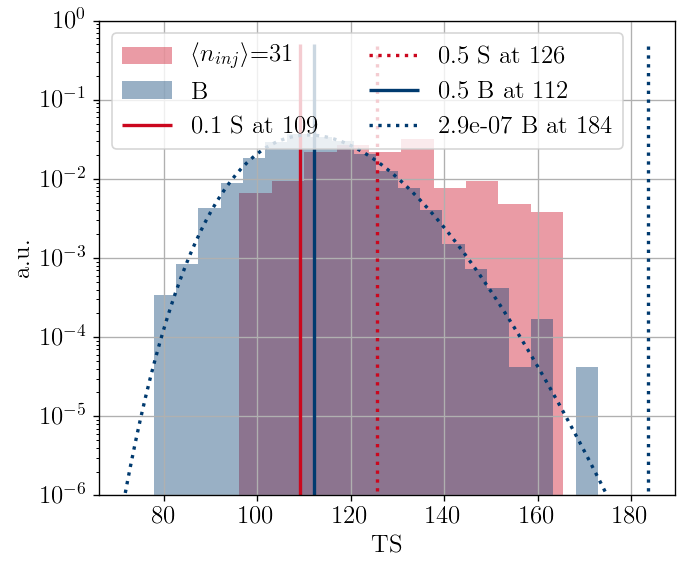

mu injected:  5.0
33


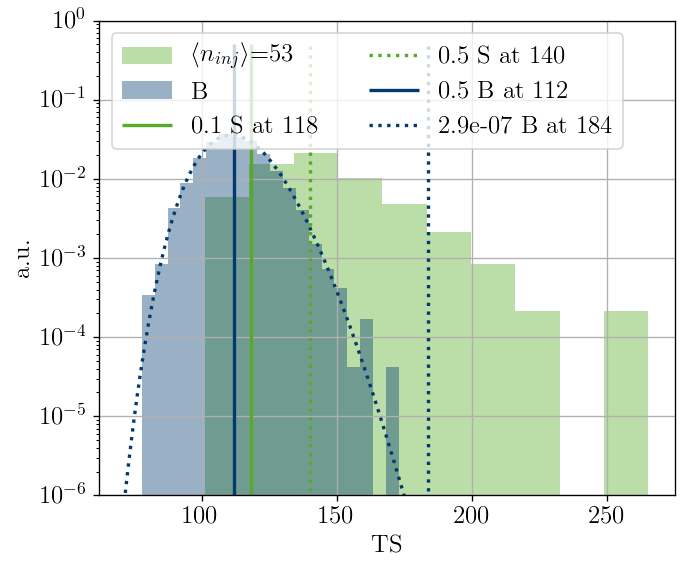

mu injected:  7.0
34


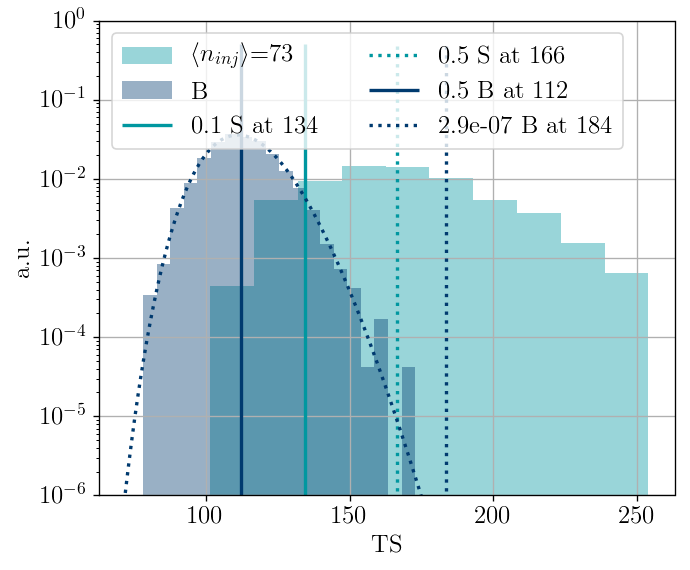

35


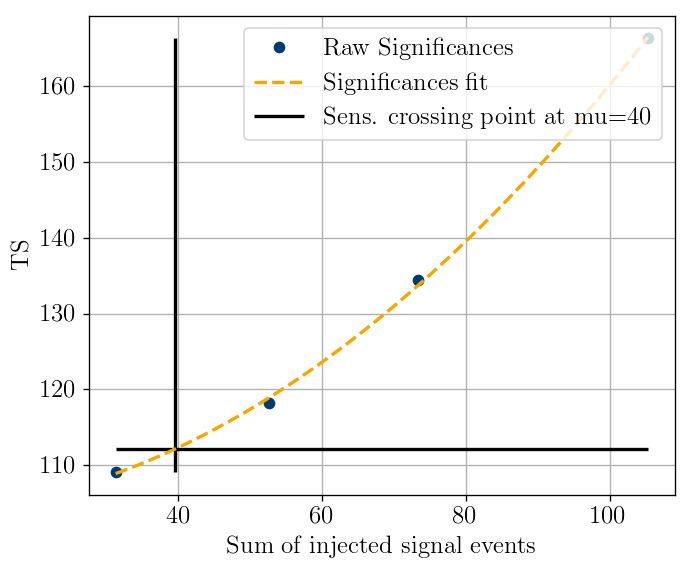

Sens. crossing point at n=4
36


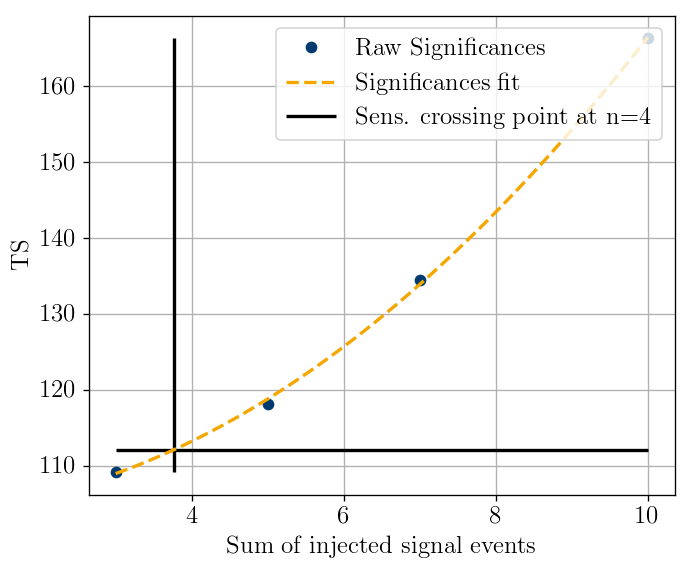

37


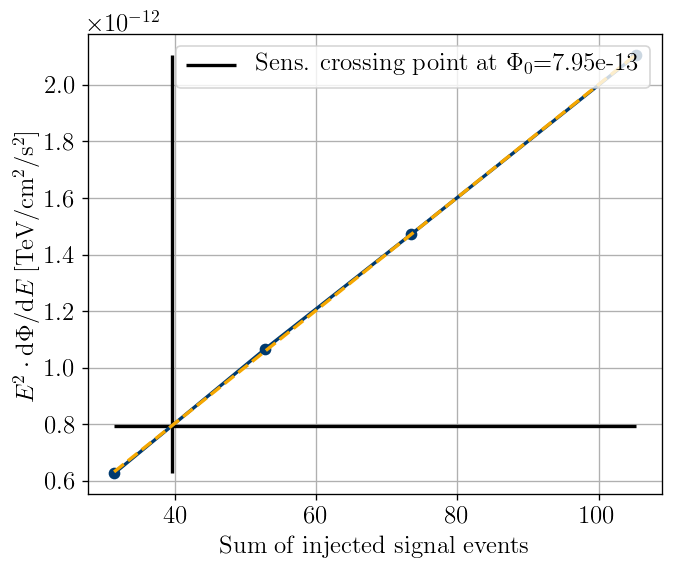

38


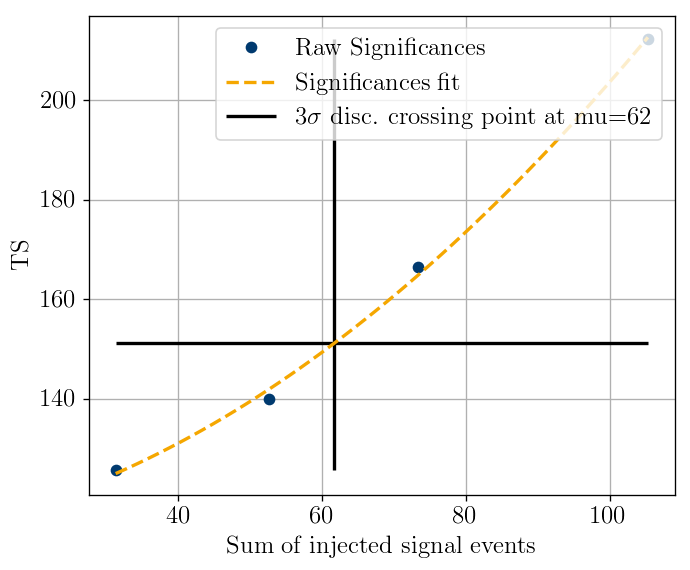

3$\sigma$ disc. crossing point at n=6
39


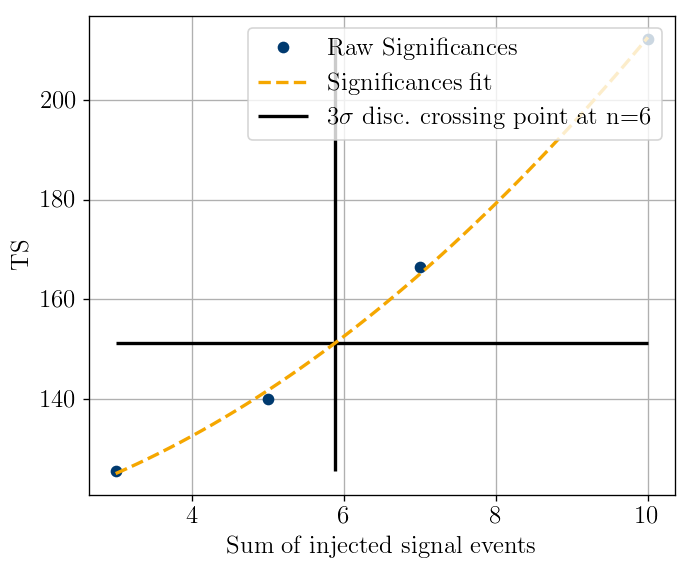

40


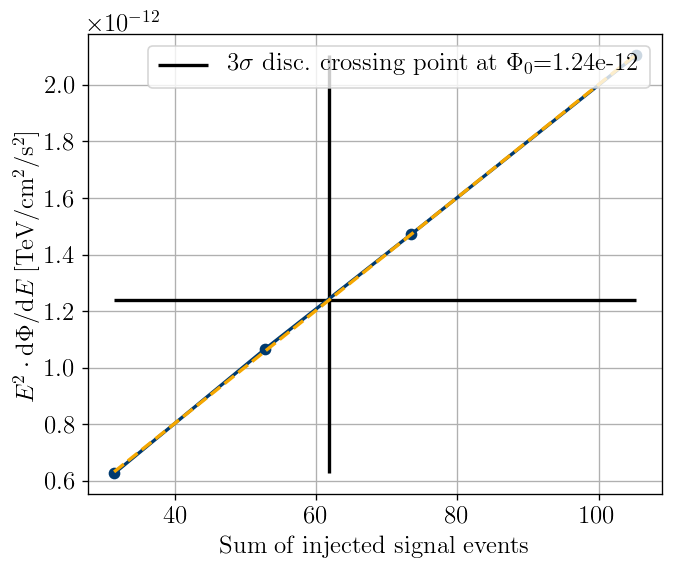

41


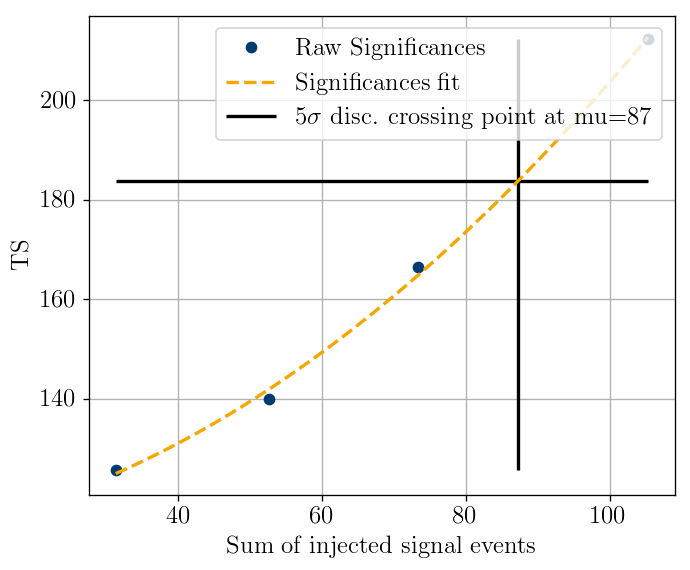

5$\sigma$ disc. crossing point at n=8
42


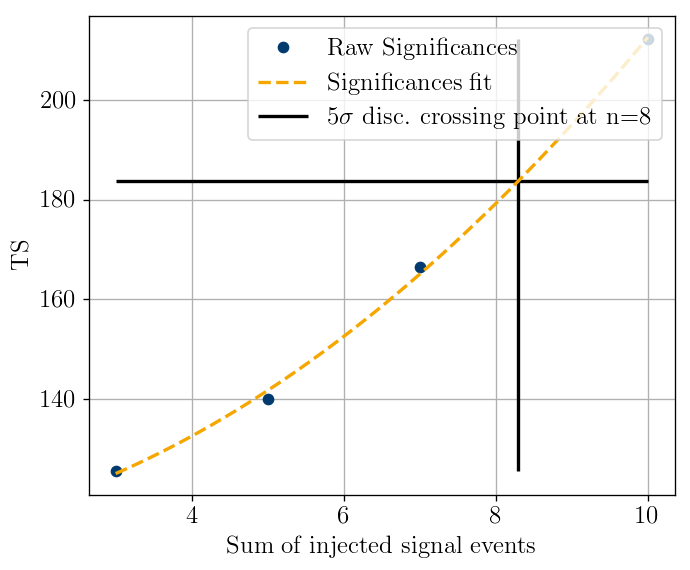

43


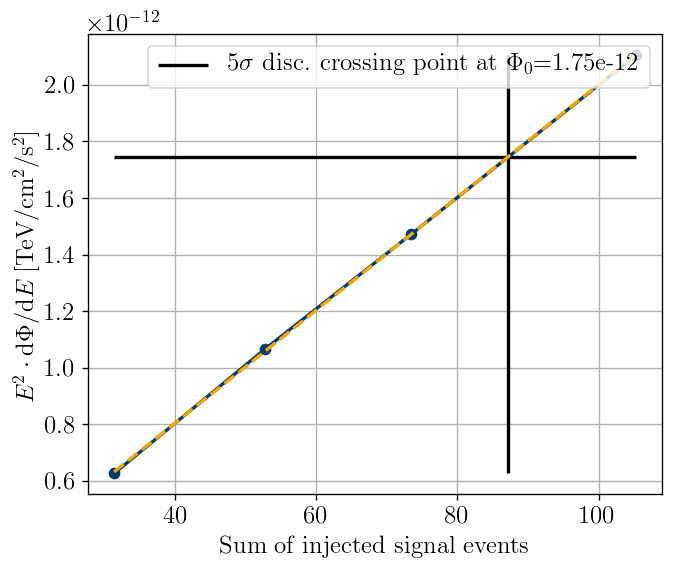

md:  6.0
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
70
mu injected:  2.5
44


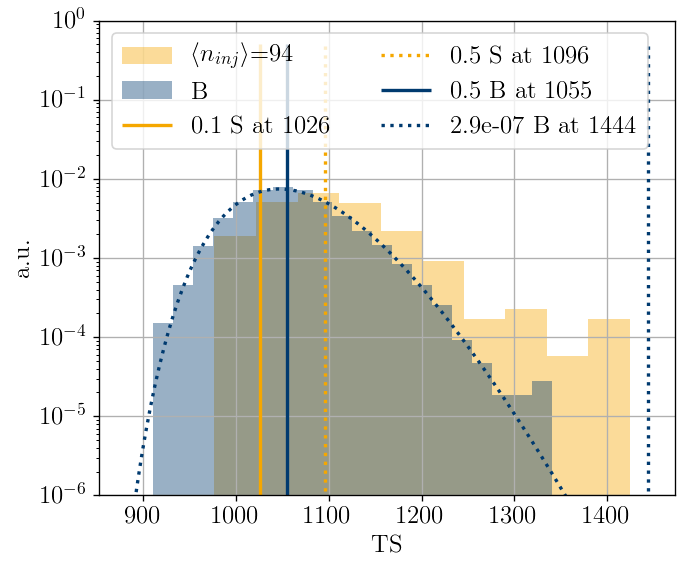

mu injected:  3.5
45


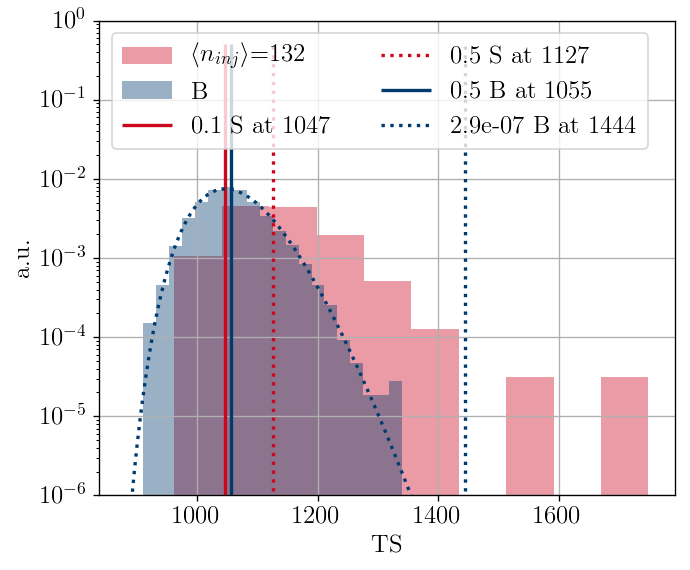

mu injected:  3.0
46


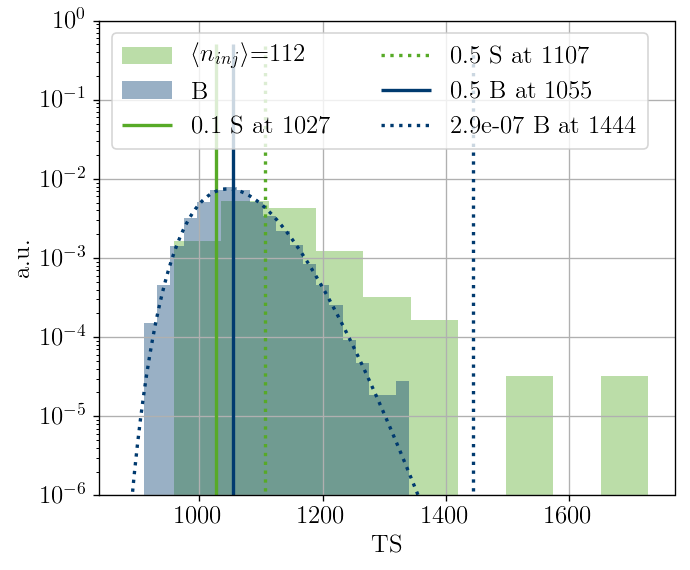

mu injected:  4.0
47


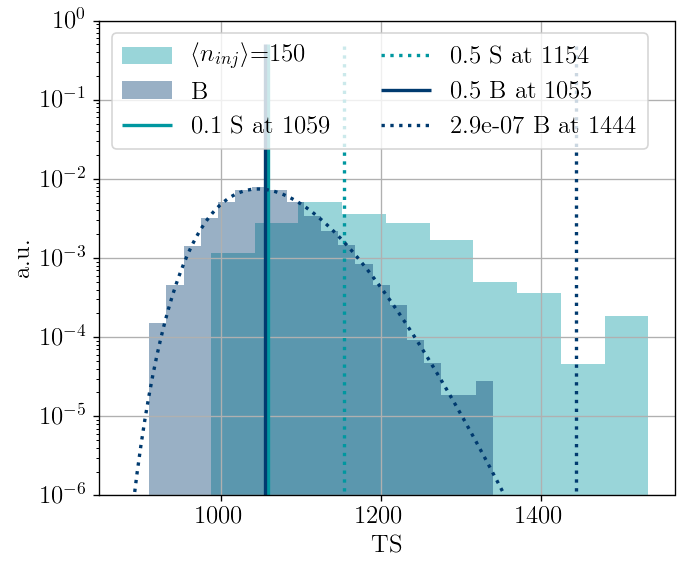

mu injected:  6.0
48


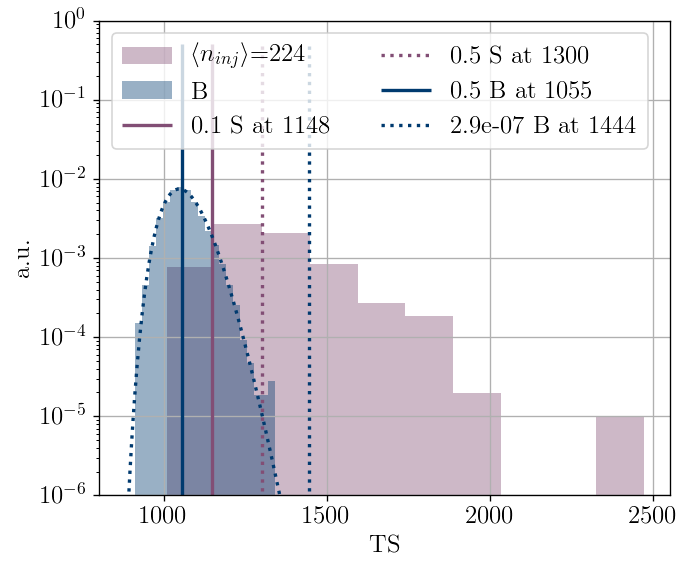

mu injected:  8.0
49


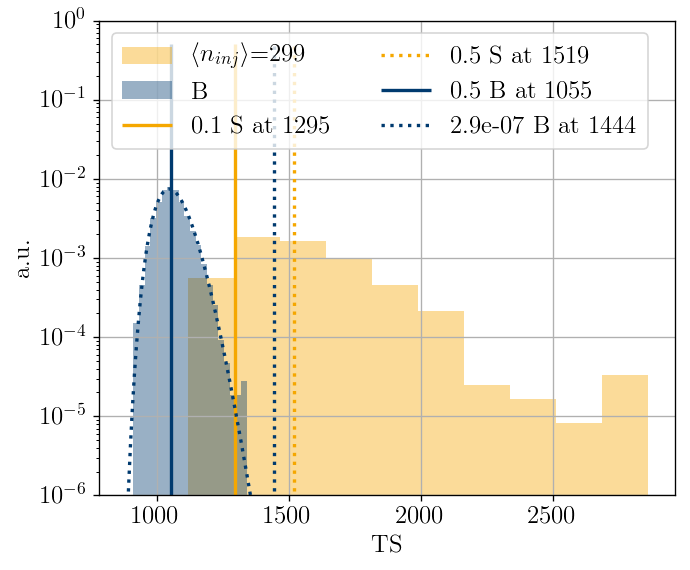

mu injected:  10.0
50


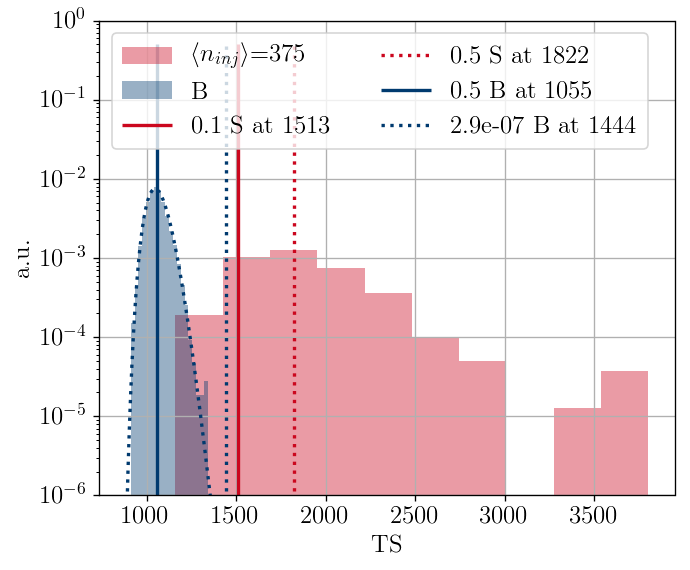

51


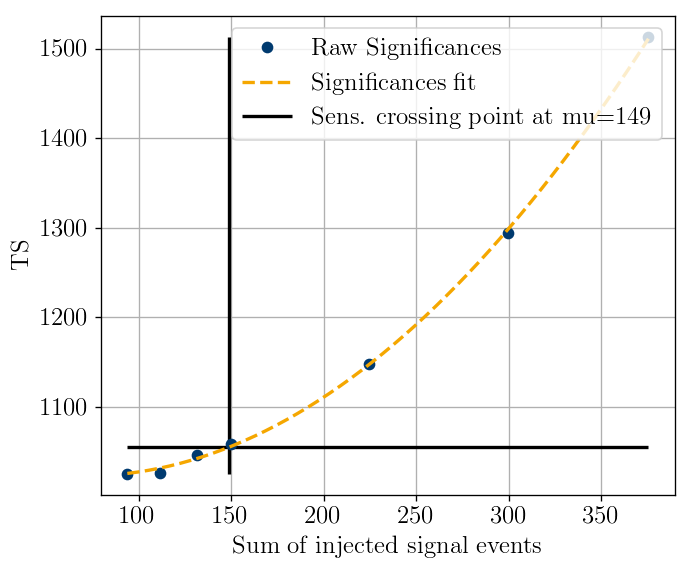

Sens. crossing point at n=4
52


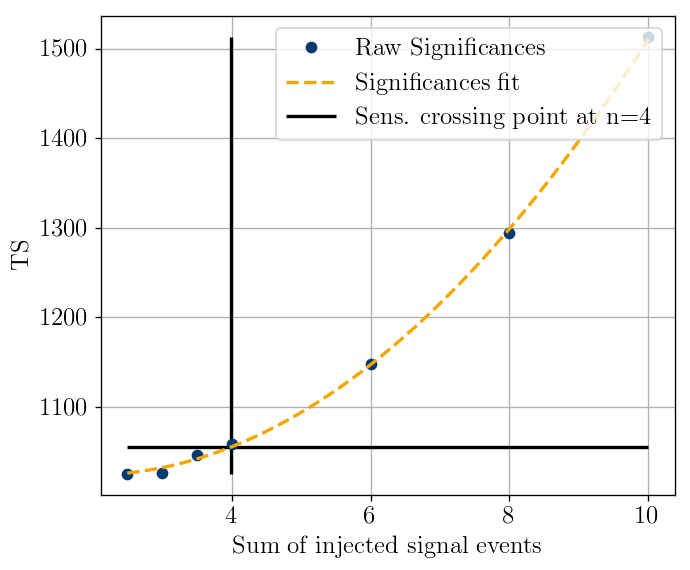

53


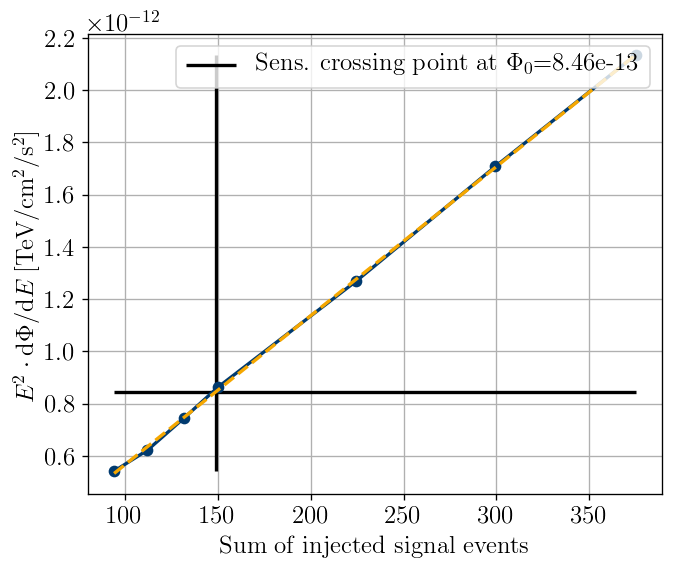

54


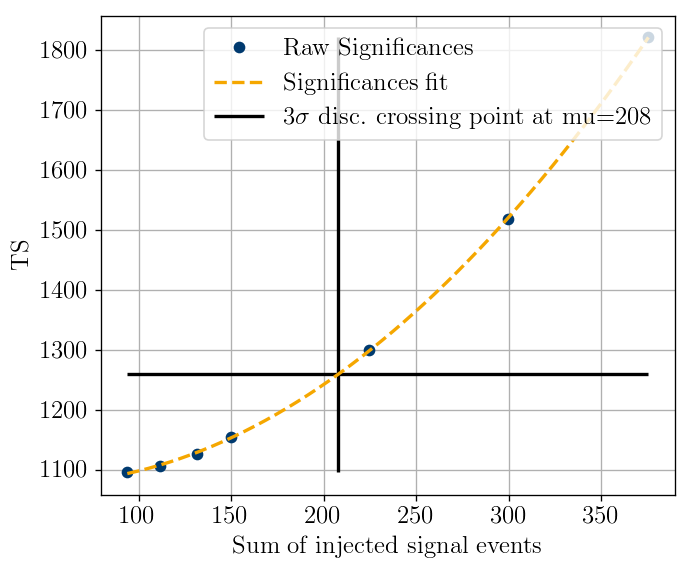

3$\sigma$ disc. crossing point at n=6
55


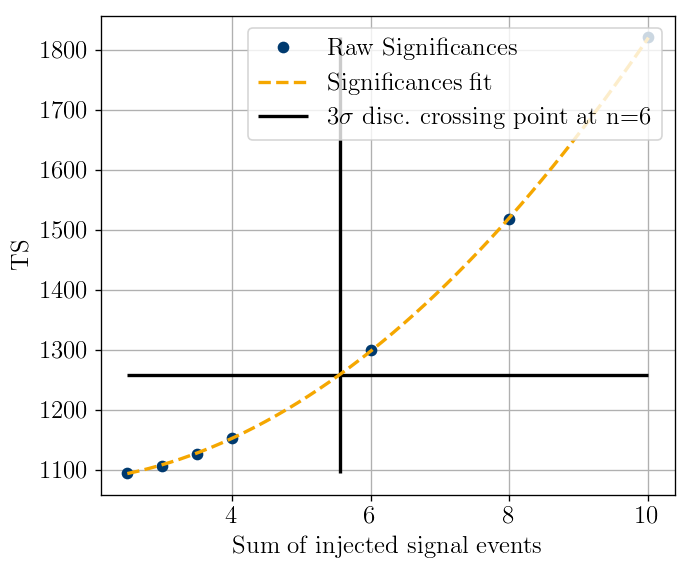

56


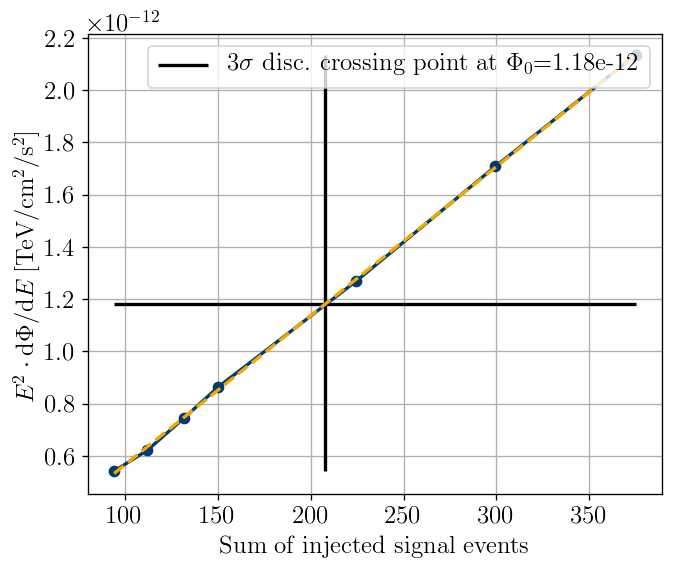

57


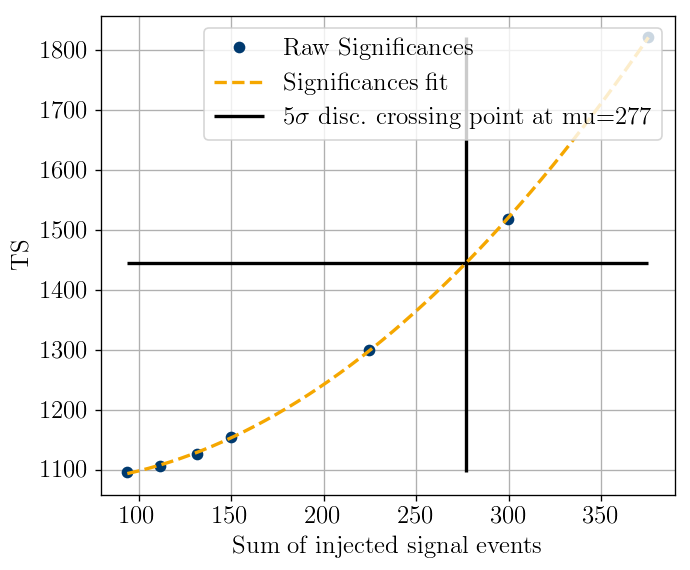

5$\sigma$ disc. crossing point at n=7
58


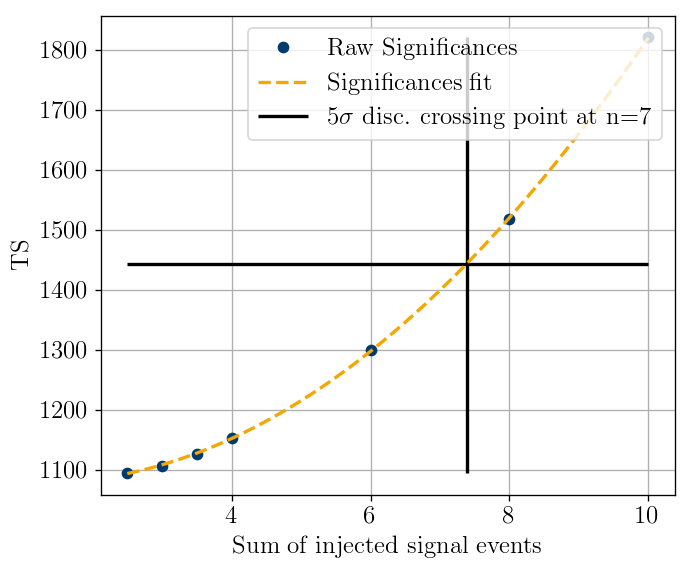

59


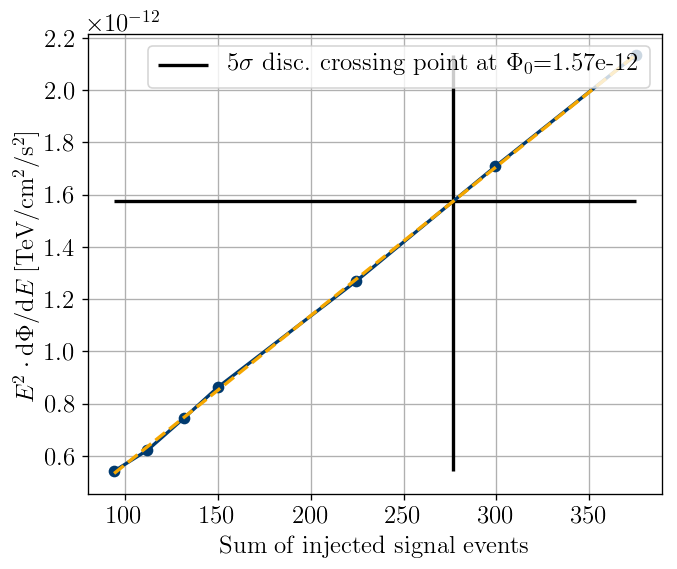

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
85
mu injected:  10.5
60


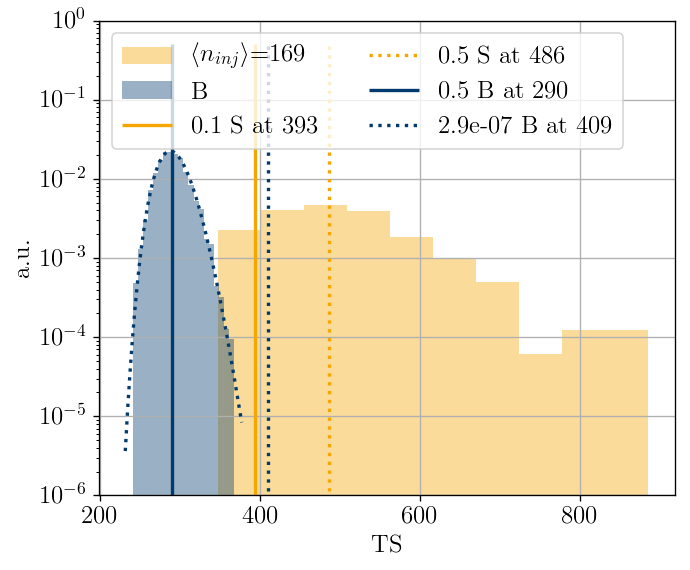

mu injected:  11.5
61


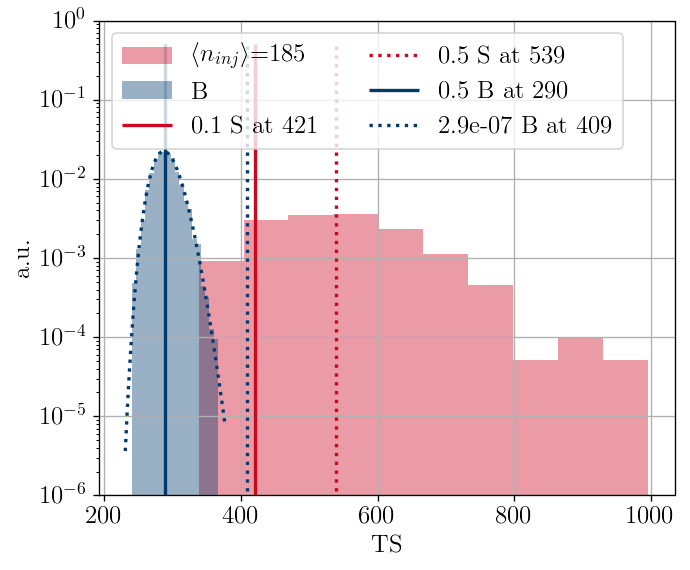

mu injected:  3.0
62


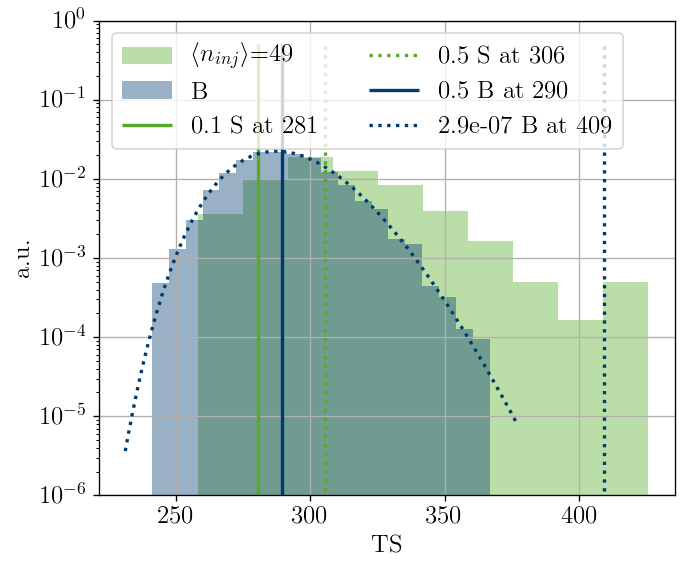

mu injected:  4.0
63


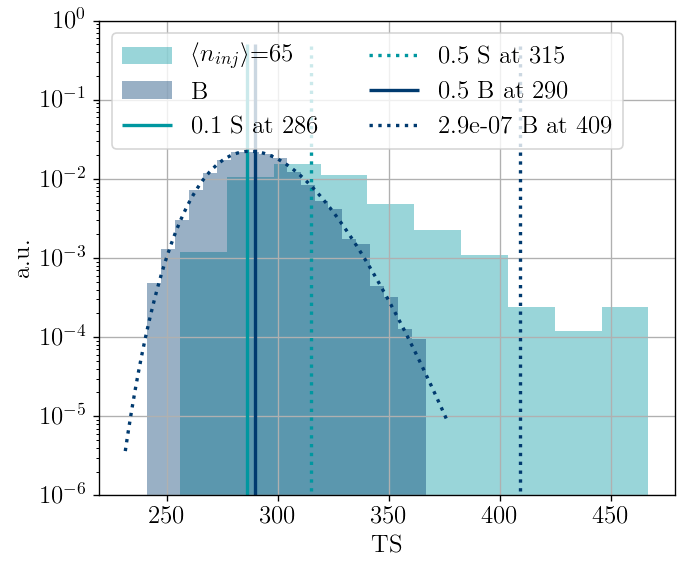

mu injected:  5.0
64


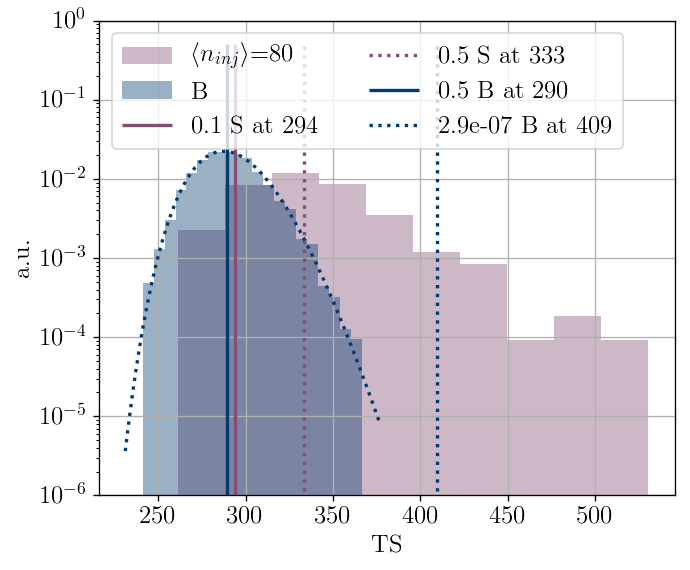

mu injected:  4.4
65


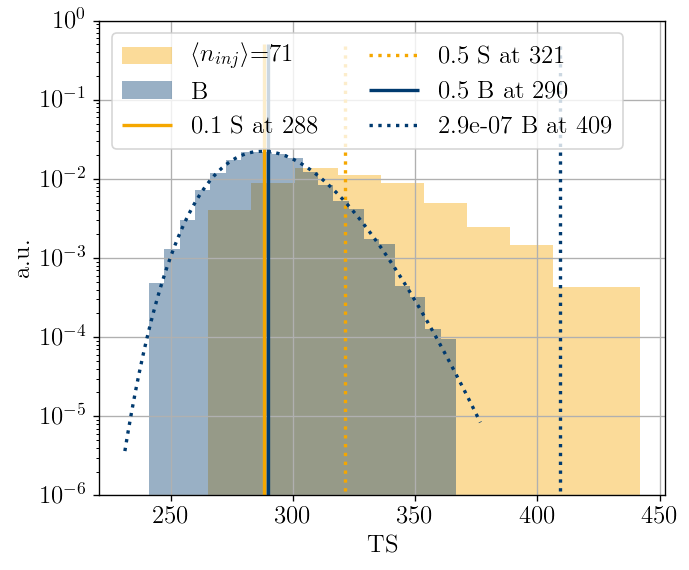

mu injected:  11.0
66


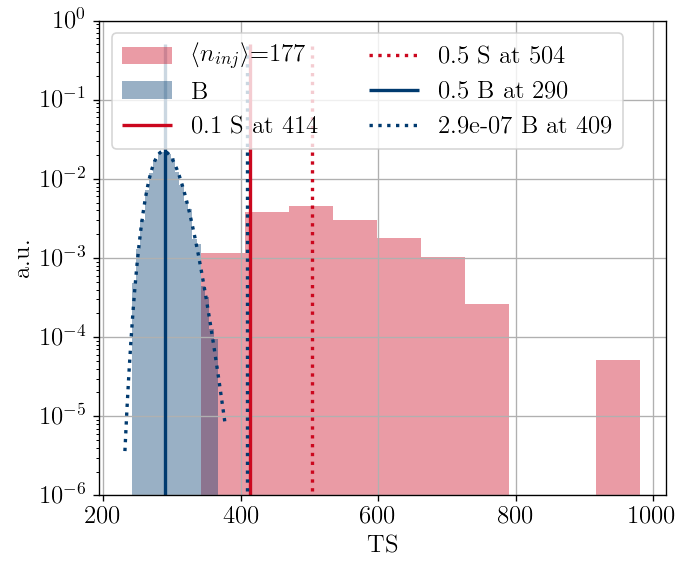

mu injected:  4.2
67


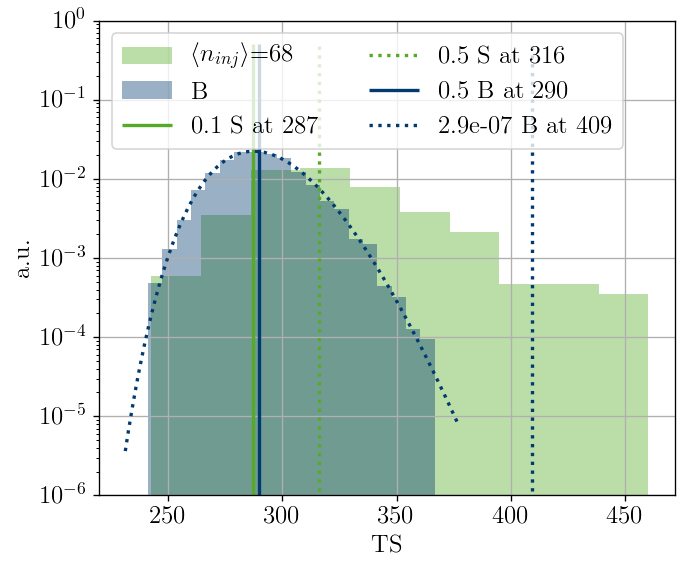

mu injected:  4.6
68


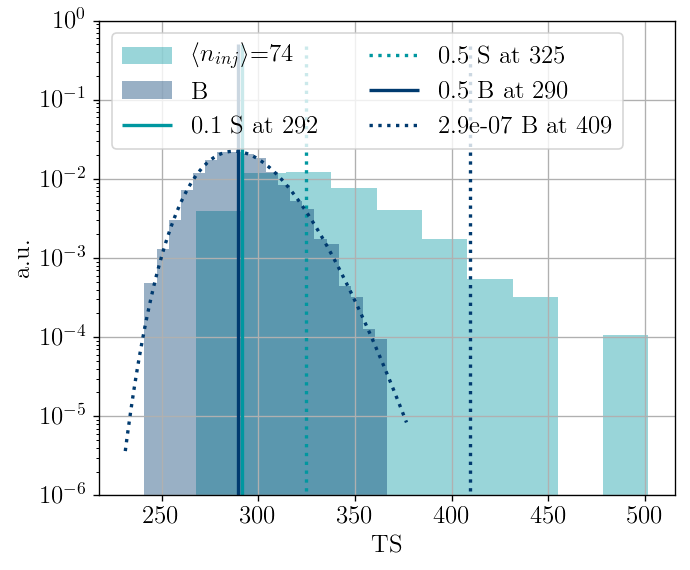

69


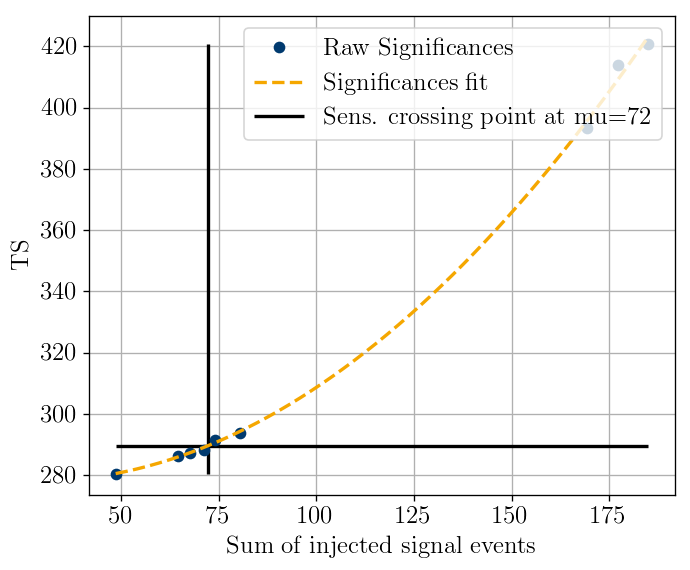

Sens. crossing point at n=4
70


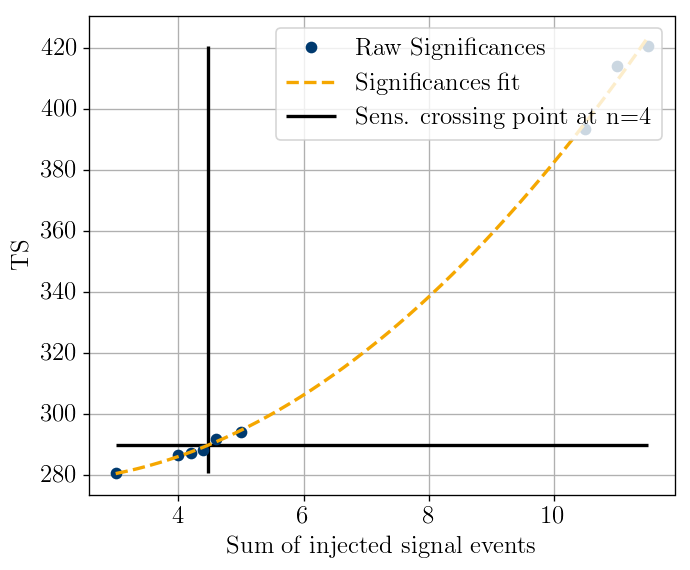

71


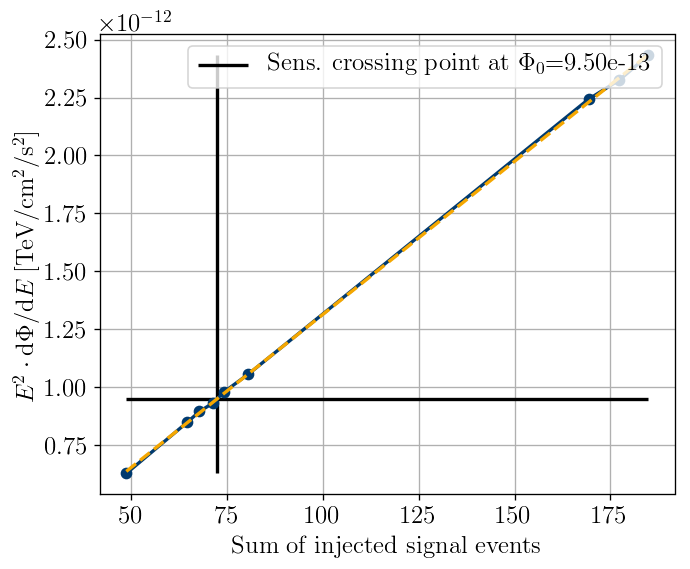

72


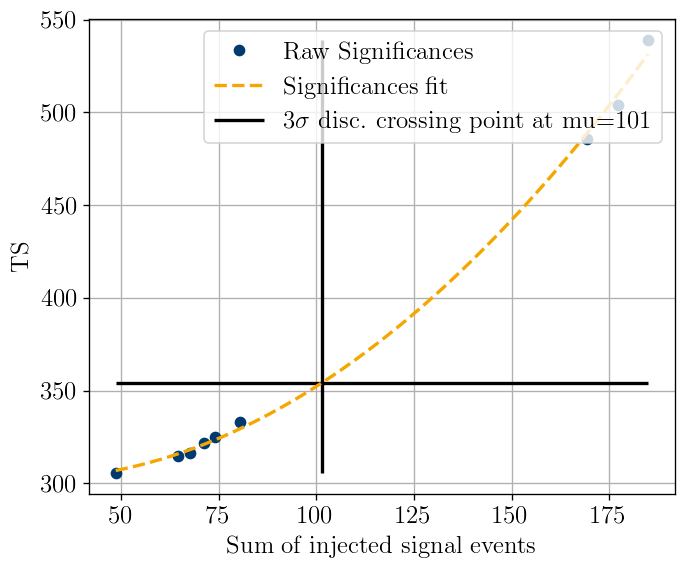

3$\sigma$ disc. crossing point at n=6
73


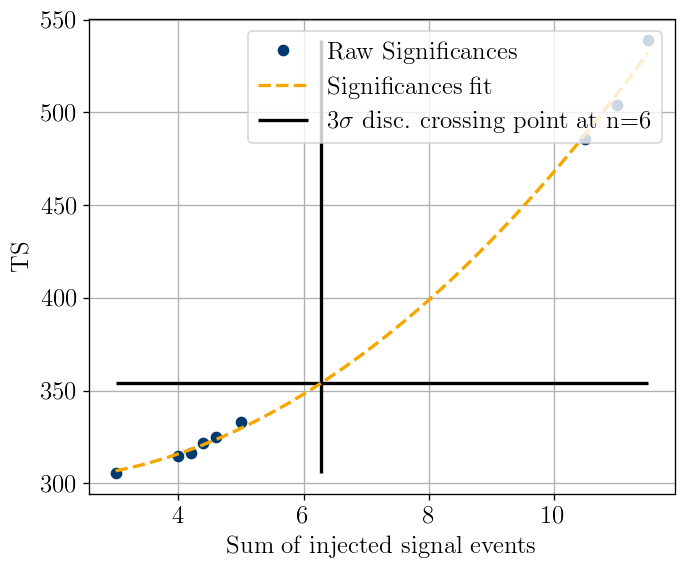

74


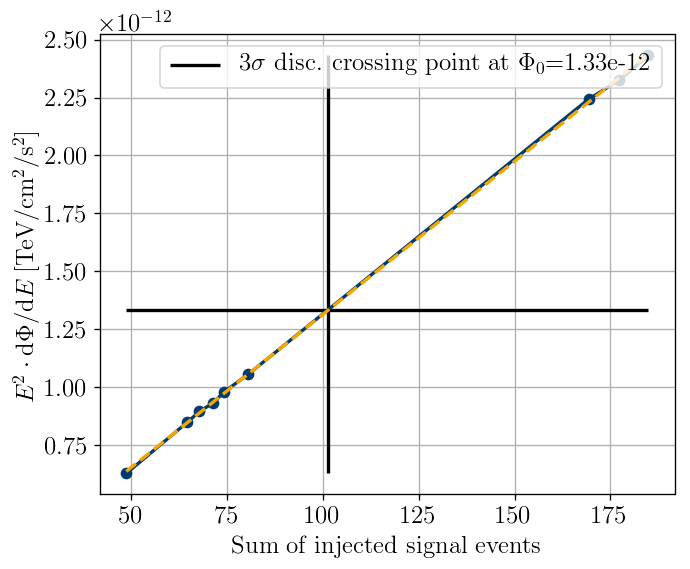

75


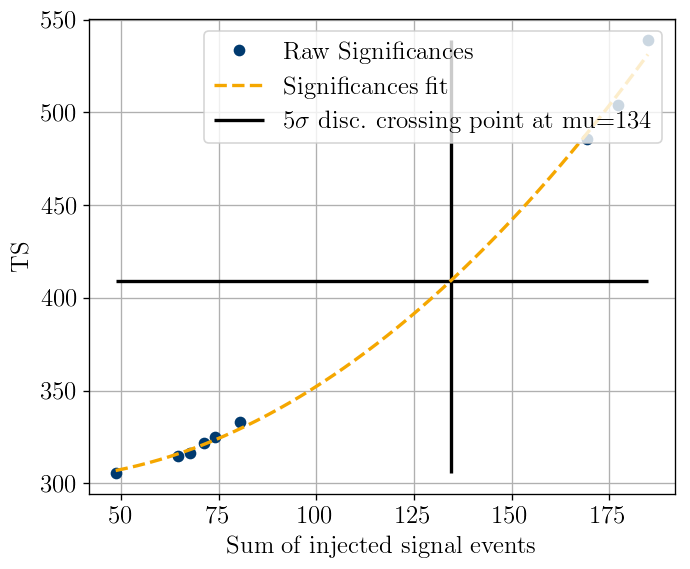

5$\sigma$ disc. crossing point at n=8
76


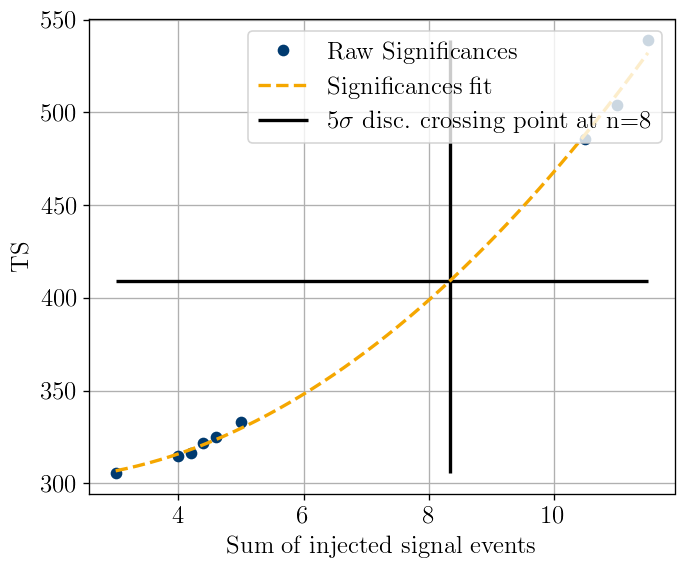

77


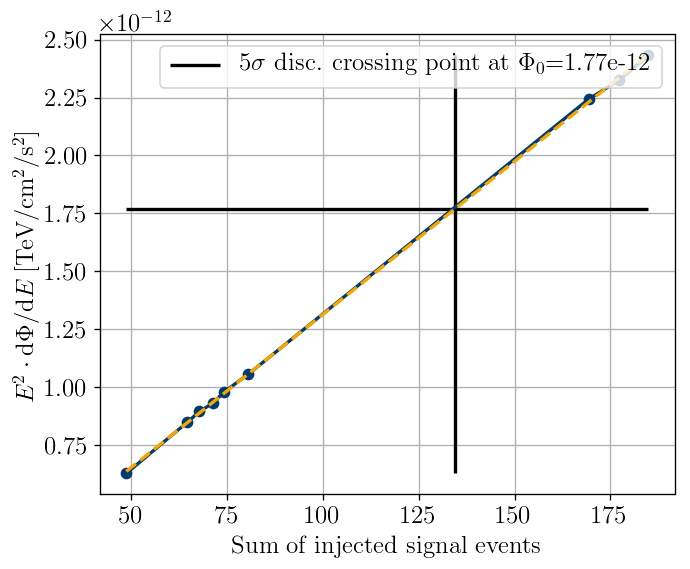

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
100
mu injected:  4.5
78


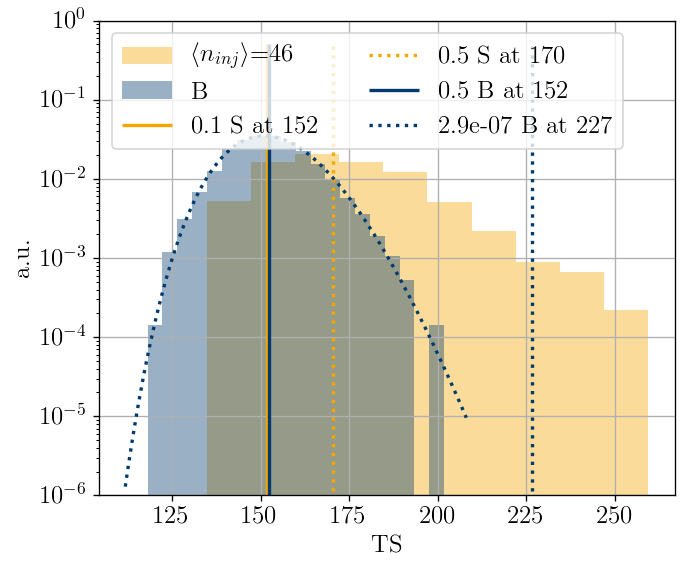

mu injected:  5.5
79


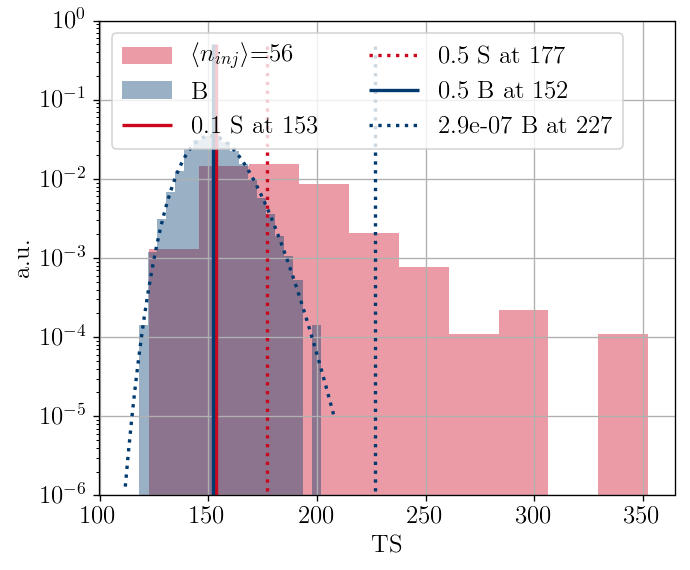

mu injected:  4.0
80


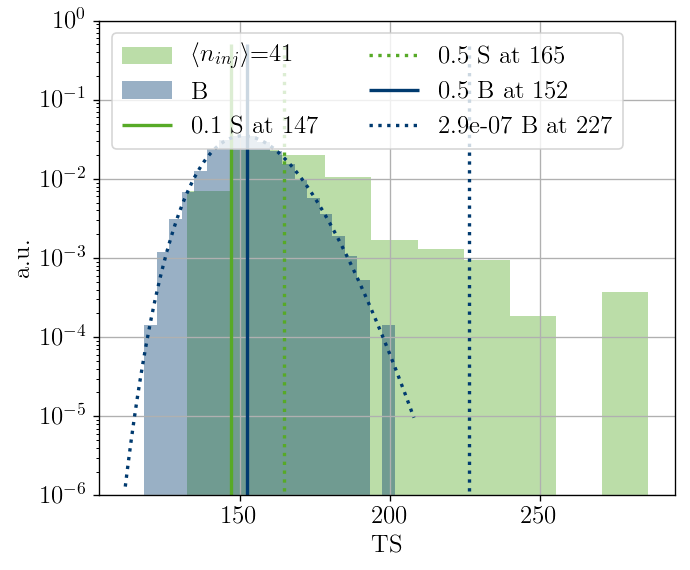

mu injected:  5.0
81


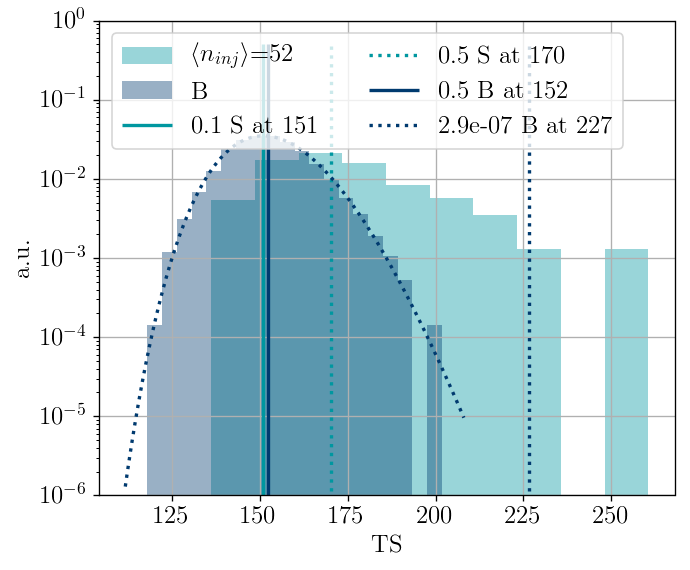

mu injected:  6.0
82


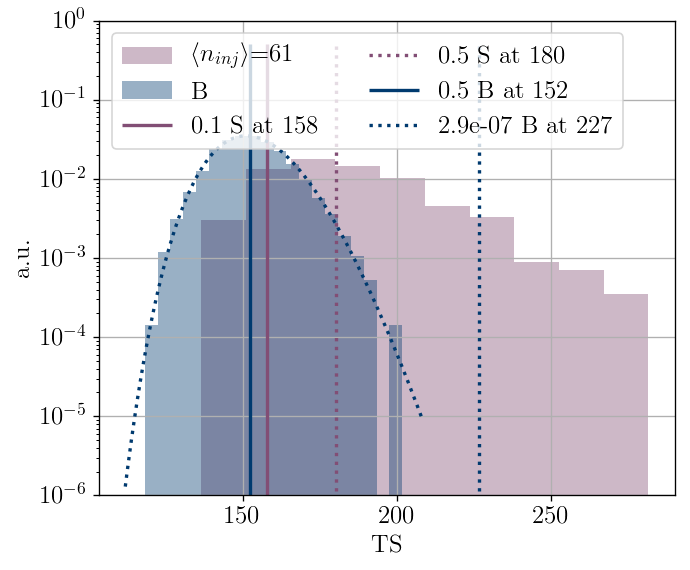

mu injected:  8.0
83


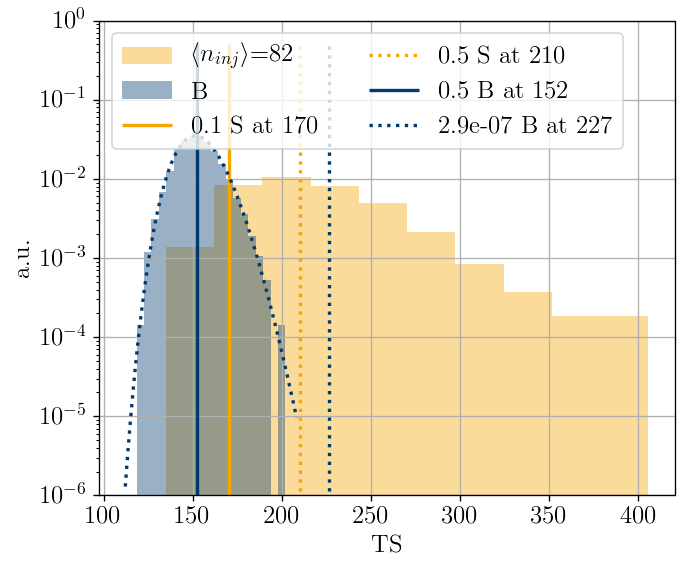

mu injected:  10.0
84


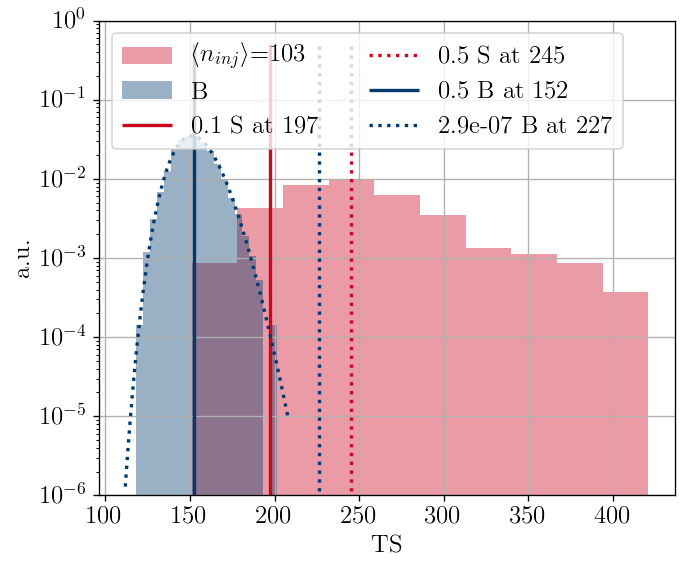

mu injected:  12.0
85


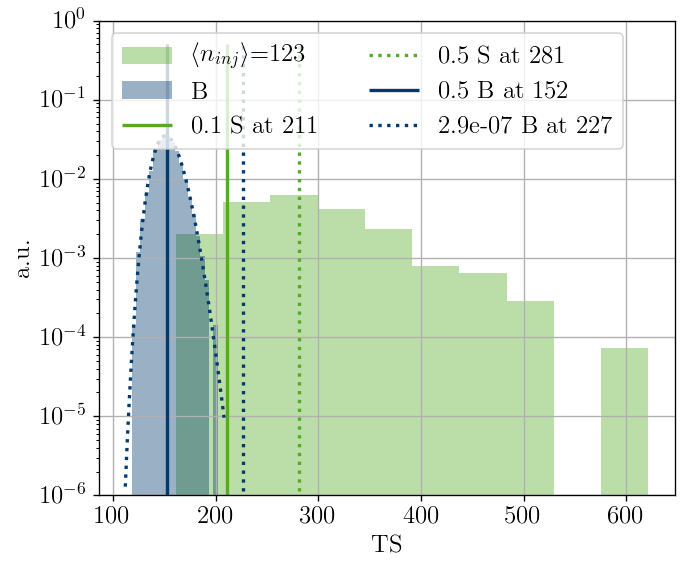

mu injected:  14.0
86


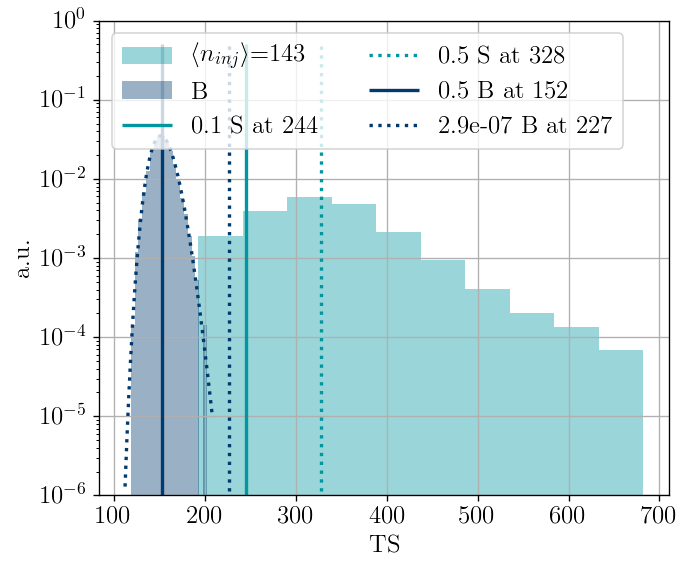

87


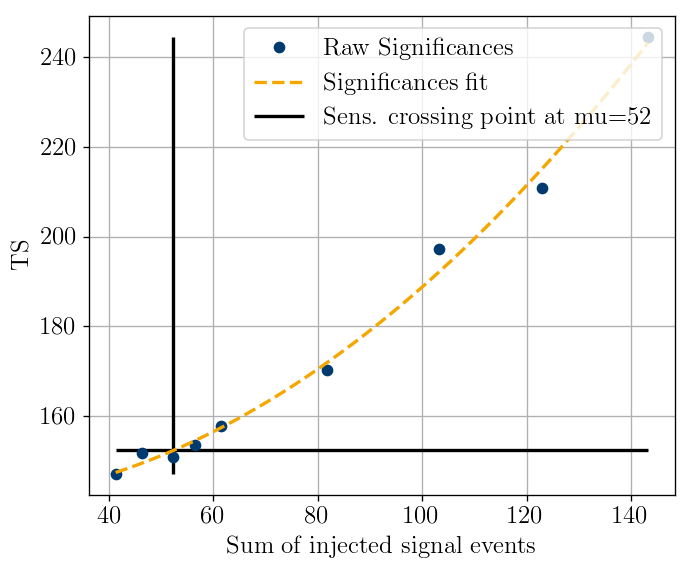

Sens. crossing point at n=5
88


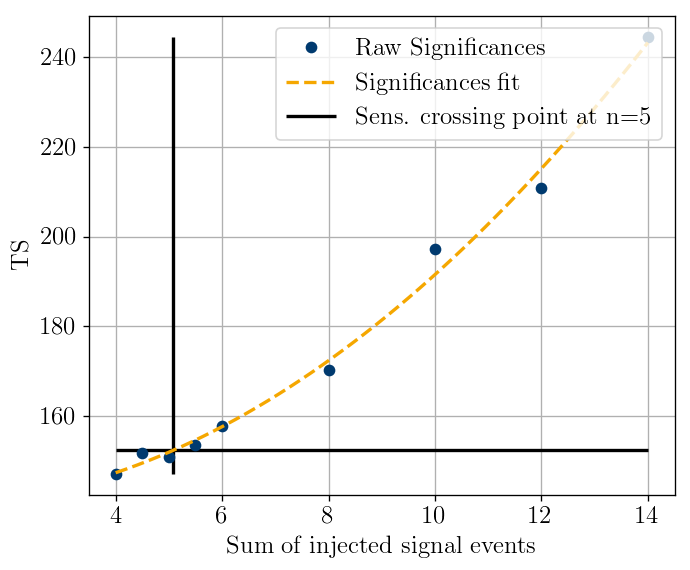

89


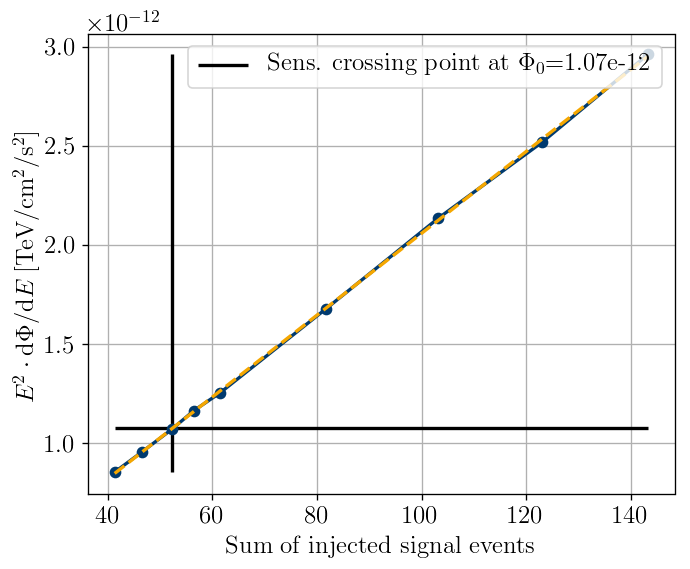

90


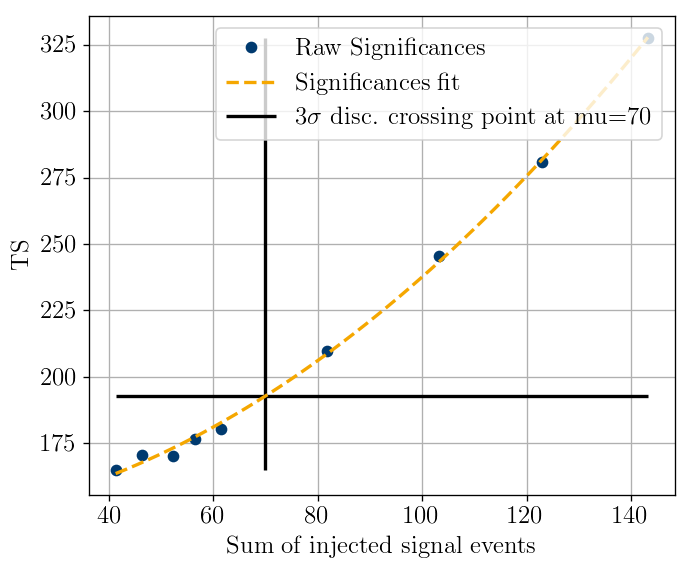

3$\sigma$ disc. crossing point at n=7
91


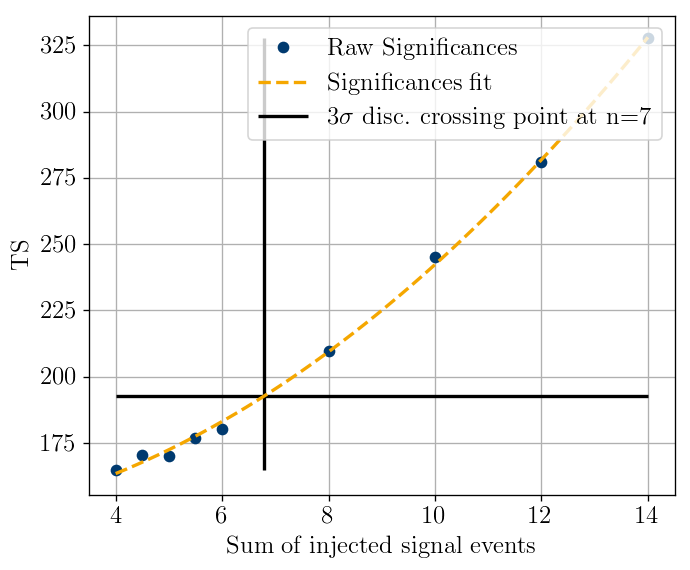

92


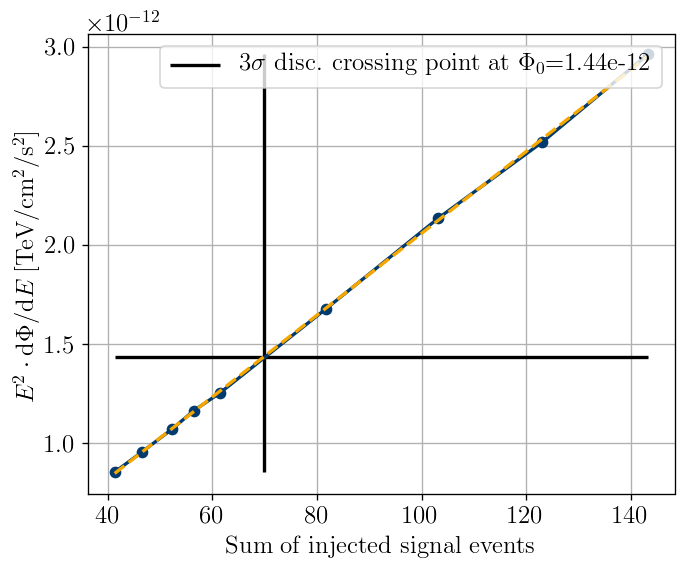

93


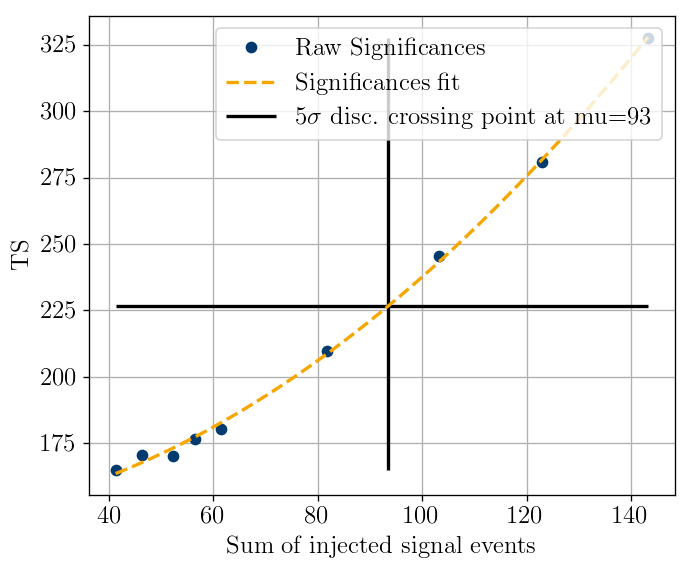

5$\sigma$ disc. crossing point at n=9
94


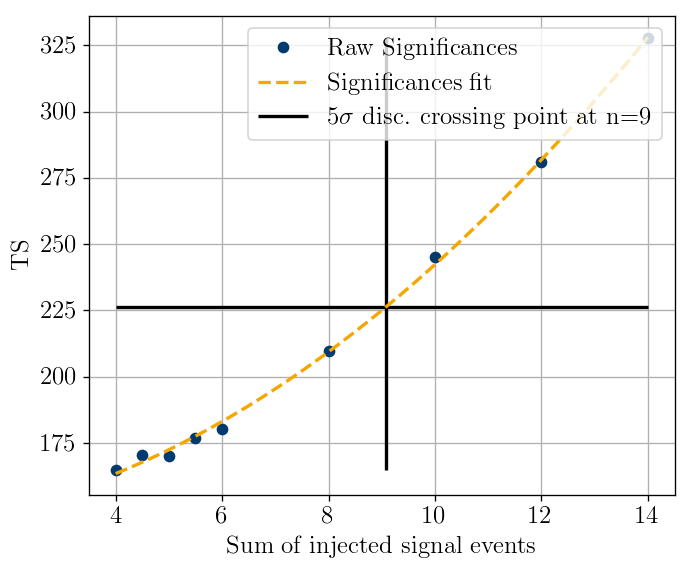

95


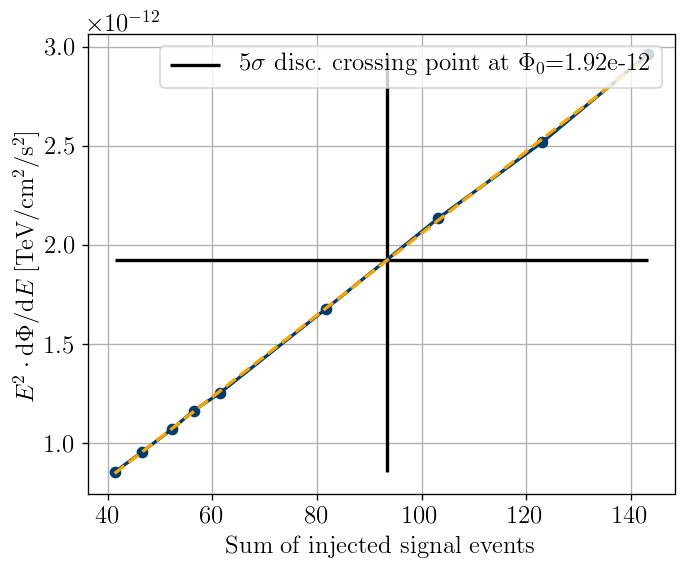

In [19]:
## With different cuts on E
## Sensitivity and disc pot
"""
tw=6
rcParams = dict()
rcParams["figure.figsize"] = (tw, tw / 1.6)
rcParams["font.size"] = 20
mpl.rcParams.update(rcParams)

#"""
bg_quantiles = [erfc(0.)*0.5, erfc(3./np.sqrt(2))*0.5, erfc(5./np.sqrt(2))*0.5] #erfc(3./np.sqrt(2))*0.5, 
s_quantiles = [0.1, 0.5, 0.5] #0.5, 
labels=["Sens.", r"3$\sigma$ disc.", r"5$\sigma$ disc."]
save_labels=["sens", r"disc3", r"disc5"]
final_flux = []
final_n = dict()
plotting = True
saveplots = False

figure_counter = 3
for md in mdparams:
    print "md: ", md
    final_n[md] = dict()
    for ecut in ecuts:
        print " * "*20
        print ecut
        final_n[md][ecut] = dict()

        ## Select right information from bckg TS depending on energy cut
        valid = np.logical_and(bg_TS["energy"]>=ecut, bg_TS["best"]<50)
        best_bg = np.where(np.logical_and(bg_TS["deflection"]==md, valid), 
                            bg_TS['best'], np.zeros_like(bg_TS['best'])).sum(axis=-1)

        ## Evaluation of Test Statistic

        fitfunc=scipy.stats.gamma
        bins=10
        #for qq,(b_q,s_q) in enumerate(zip(bg_quantiles, s_quantiles)):
        fit = fitfunc.fit(best_bg)

        bg_vals = fitfunc.isf(bg_quantiles, *fit)
        sig_val = []
        #plotting=True
        for i,ak in enumerate(signals[md][ecut]):
            try:
                print "mu injected: ", ak
                signals[md][ecut][ak] = np.array(signals[md][ecut][ak])
                best = signals[md][ecut][ak]['best'].sum(axis=-1)
                to_append = [np.mean(signals[md][ecut][ak]['n_inj'].sum(axis=-1))]
                to_append.extend([np.percentile(best, 100*s_q) for s_q in s_quantiles])
                to_append.extend([ak])
                sig_val.append(to_append)
                if plotting==True:
                    plt.figure(figure_counter)
                    figure_counter+=1
                    sns.distplot(best, bins=bins, rug=False, kde=False, 
                                hist_kws=dict(normed=True, color=utils.colors[i%(clen-1) +1]), 
                                fit_kws=dict( color=utils.colors[i%(clen-1) +1]),
                                label=r"$\langle n_{{inj}} \rangle $={:1.0f}".format(sig_val[-1][0]))

                    sns.distplot(best_bg, bins=bins*2, rug=False, kde=False, fit=fitfunc,
                                hist_kws=dict(normed=True, color=utils.colors[0]), 
                                fit_kws=dict( color=utils.colors[0], markersize=0),
                                label="B")

                    for ii,(s_v, s_q) in enumerate(zip(sig_val[-1][1:-1], s_quantiles)):
                        if ii==1: continue
                        plt.vlines(s_v, 0, 0.5, 
                                   color=utils.colors[i%(clen-1) +1], 
                                   label="{:1.1f} S at {:1.0f}".format(s_q, s_v),
                                   linestyle=utils.linestyles[ii]
                                  )
                    for ii,(b_q,bg_val) in enumerate(zip(bg_quantiles, bg_vals)):
                        if ii==1: continue
                        if b_q <0.01:
                            b_label="{:1.1e} B at {:1.0f}".format(b_q, bg_val)
                        else:
                            b_label="{:1.1f} B at {:1.0f}".format(b_q, bg_val)
                        plt.vlines(bg_val, 0, 0.5, 
                                   color=utils.colors[0], 
                                   label=b_label,
                                   linestyle=utils.linestyles[ii]
                                  )
                    plt.legend(loc=2, ncol=2)
                    plt.ylim(1e-6,1)
                    plt.xlabel("TS")
                    plt.ylabel("a.u.")
                    plt.semilogy(nonposy="clip")
                    if saveplots: plt.savefig(os.path.join(figurepath, str(figure_counter)+"_TS_distribution.png"))
                    print figure_counter
                    plt.show()
                    #plotting = False

            except:
                print "Something went wrong ...", sys.exc_info()
                print ak

        for qq,(b_q,s_q) in enumerate(zip(bg_quantiles, s_quantiles)):
            
            temp = np.array(sig_val).T
            mu = temp[0]
            ts = temp[1+qq]
            base_n = temp[-1]
            mu_space = np.linspace(min(mu), max(mu))
            vals = np.polyfit(mu, ts, 2)
            fit = np.poly1d(vals)
            
            
            if plotting==True:
                plt.figure(figure_counter)
                figure_counter += 1
                plt.plot(mu, ts, marker="o", label="Raw Significances", lw=0)
                plt.plot(mu_space, fit(mu_space), linestyle="--", label="Significances fit", markersize=0)
                plt.hlines(bg_vals[qq], min(mu), max(mu))
                
            vals[-1] -= bg_vals[qq]
            roots = np.roots(vals)
            #final_n[md][ecut][save_labels[qq]] = max(roots)
            #print r""+labels[qq]+" crossing point at mu={:1.0f}".format(max(roots))
            if plotting==True:
                plt.vlines(max(roots), min(ts), max(ts), 
                           label=labels[qq]+" crossing point at mu={:1.0f}".format(max(roots))) #roots[roots>min(mu)][0]
                plt.legend(loc=1)
                plt.xlabel("Sum of injected signal events")
                plt.ylabel("TS")
                if saveplots: plt.savefig(os.path.join(figurepath, str(figure_counter)+save_labels[qq]+"_mu_crossing.png"))
                print figure_counter
                plt.show()
                
            ###### we also look at the base value of injected events, as cross check
            n_space = np.linspace(min(base_n), max(base_n))
            n_vals = np.polyfit(base_n, ts, 2)
            n_fit = np.poly1d(n_vals)
            if plotting==True:
                plt.figure(figure_counter)
                figure_counter += 1
                plt.plot(base_n, ts, marker="o", label="Raw Significances", lw=0)
                plt.plot(n_space, n_fit(n_space), linestyle="--", label="Significances fit", markersize=0)
                plt.hlines(bg_vals[qq], min(base_n), max(base_n))
                
            n_vals[-1] -= bg_vals[qq]
            n_roots = np.roots(n_vals)
            final_n[md][ecut][save_labels[qq]] = max(n_roots)
            print labels[qq]+" crossing point at n={:1.0f}".format(max(n_roots))
            if plotting==True:
                plt.vlines(max(n_roots), min(ts), max(ts), 
                           label=labels[qq]+" crossing point at n={:1.0f}".format(max(n_roots))) #roots[roots>min(mu)][0]
                plt.legend(loc=1)
                plt.xlabel("Sum of injected signal events")
                plt.ylabel("TS")
                if saveplots: plt.savefig(os.path.join(figurepath, str(figure_counter)+save_labels[qq]+"_n_crossing.png"))
                print figure_counter
                plt.show()
            ######
            
            mean_flux_per_source = defaultdict()
            n_inj_per_map = defaultdict()
            for i,ak in enumerate(signals[md][ecut]):
                """
                here we have ALL signal contributions from one certain mu,
                this has shape N_MAPS x N_CR.
                the mean is then calculated over all N_CR contribution
                yielding a mean flux per source and map.
                we also sum over the whole number of injected events per map
                """
                mean_flux_per_source[ak] = np.mean(signals[md][ecut][ak]['n_inj'] * \
                                                   1./flux_spline(np.sin(signals[md][ecut][ak]['dec_inj'])), axis=-1)
                n_inj_per_map[ak] = signals[md][ecut][ak]['n_inj'].sum(axis=-1)


            n_inj_sum = np.zeros(len(n_inj_per_map.keys()))
            flux_mean = np.zeros(len(mean_flux_per_source.keys()))
            for i,key in enumerate(n_inj_per_map):
                """
                Next, we average over each mu, 
                since one certain signal strength should yield one certain average flux
                """
                n_inj_sum[i]=np.mean(n_inj_per_map[key])
                flux_mean[i]=np.mean(mean_flux_per_source[key])

            
            idx = np.argsort(n_inj_sum)
            nspace = np.linspace(min(n_inj_sum), max(n_inj_sum), num=100)
            vals = np.polyfit(n_inj_sum[idx], flux_mean[idx], 1)
            fit = np.poly1d(vals)
            final_flux.append([ecut, fit(max(roots))])
            if plotting==True:
                plt.figure(figure_counter)
                figure_counter+=1
                plt.plot(n_inj_sum[idx], flux_mean[idx], marker="o")
                plt.plot(nspace, fit(nspace), linestyle="--", markersize=0)
                plt.vlines(max(roots), min(flux_mean[idx]), max(flux_mean[idx])) 
                plt.hlines(final_flux[-1][1], min(n_inj_sum), max(n_inj_sum), 
                           label=labels[qq]+r" crossing point at $\Phi_0$={:1.2e}".format(final_flux[-1][1]))
                plt.xlabel("Sum of injected signal events")
                plt.ylabel(r"$E^2 \cdot \mathrm{d}\Phi/\mathrm{d}E \; [\mathrm{TeV}/\mathrm{cm}^2/\mathrm{s}^2]$")
                plt.legend(loc=1)
                if saveplots: plt.savefig(os.path.join(figurepath, str(figure_counter)+save_labels[qq]+"_phi_crossing.png"))
                print figure_counter
                plt.show()
            #except:
            #print "Calculating interpolations failed!"
        #break
    #break

In [20]:
final_flux_fit = np.copy(final_flux)

a = np.array(final_flux_fit).T
b = np.repeat(mdparams, len(a[0])/2)
b = b[np.newaxis]
c = np.concatenate((a, b), axis=0)

np.savetxt(os.path.join(savepath, "final_performance_fluxes_fixed_gamma_ts_fit.npy"), c.T)

## with calculation from bckg percentiles

md:  3.0
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
70
mu injected:  8.0
4


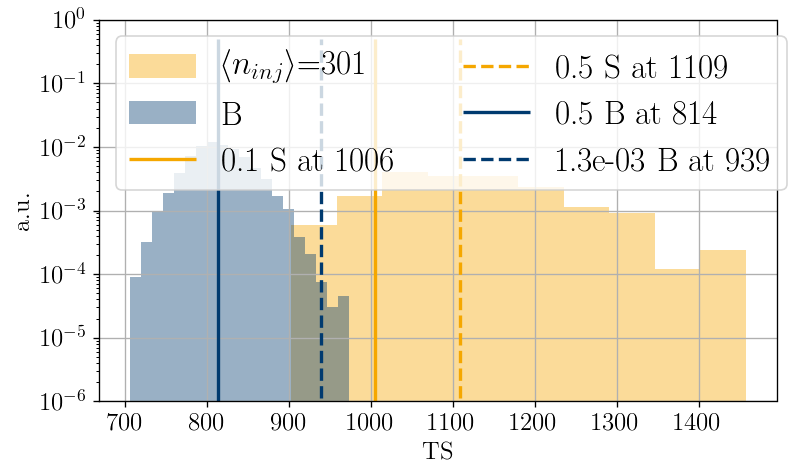

mu injected:  2.0
5


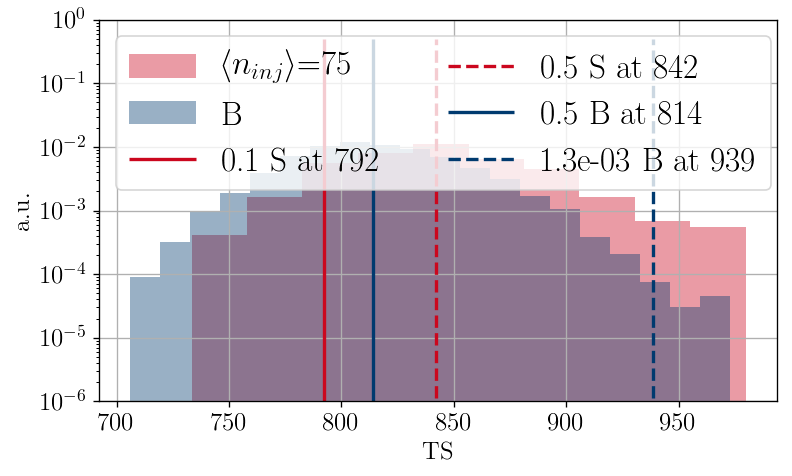

mu injected:  4.0
6


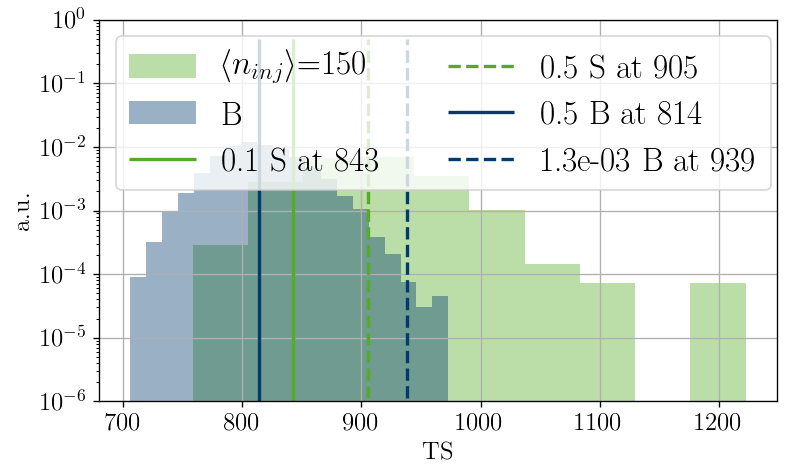

mu injected:  7.0
7


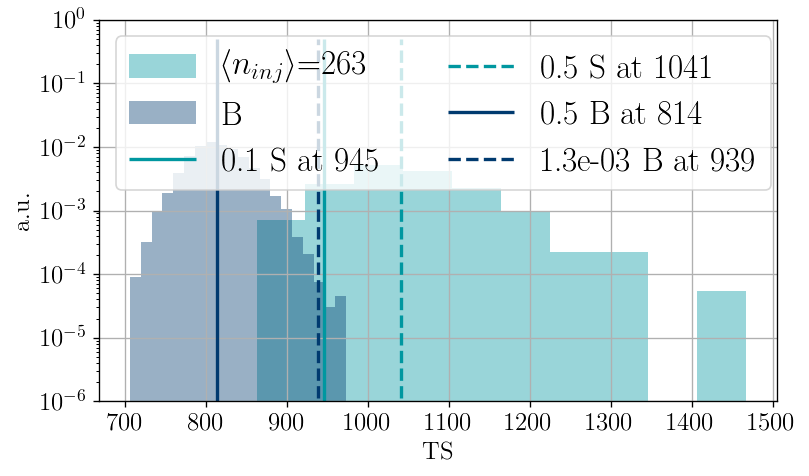

8


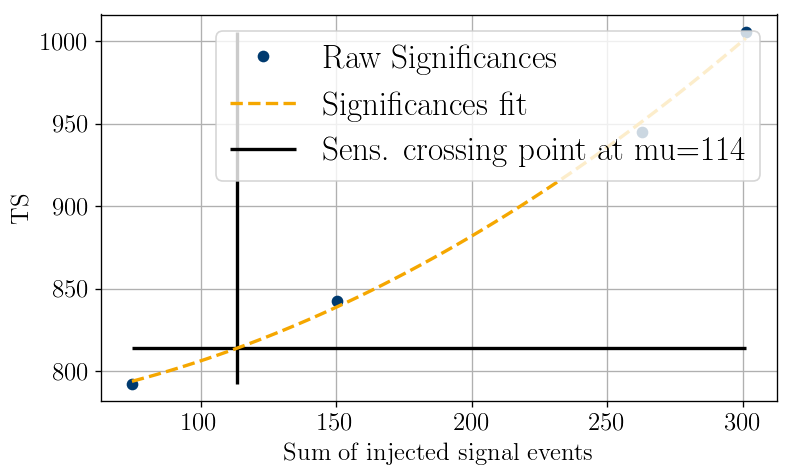

Sens. crossing point at n=3
9


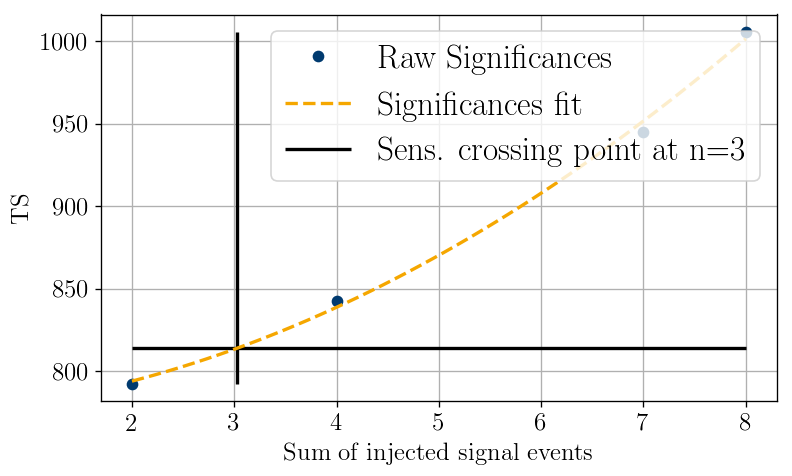

10


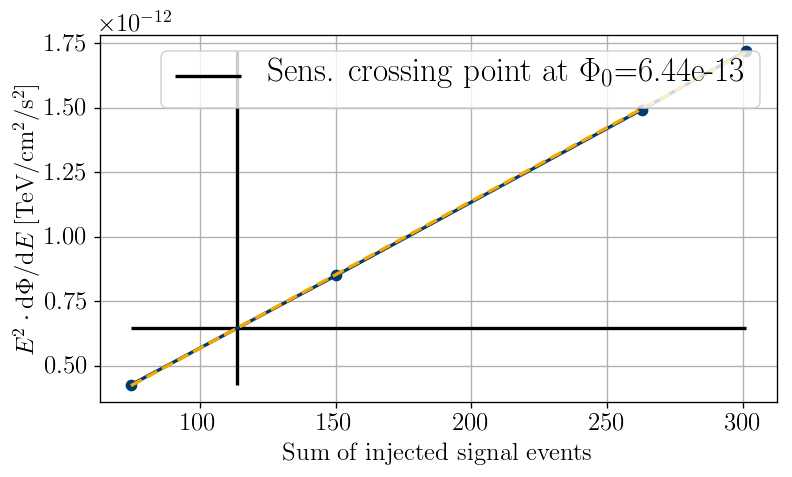

11


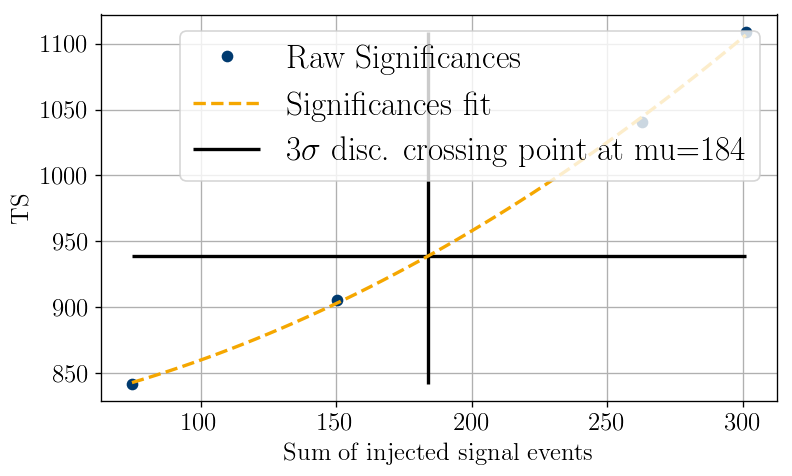

3$\sigma$ disc. crossing point at n=5
12


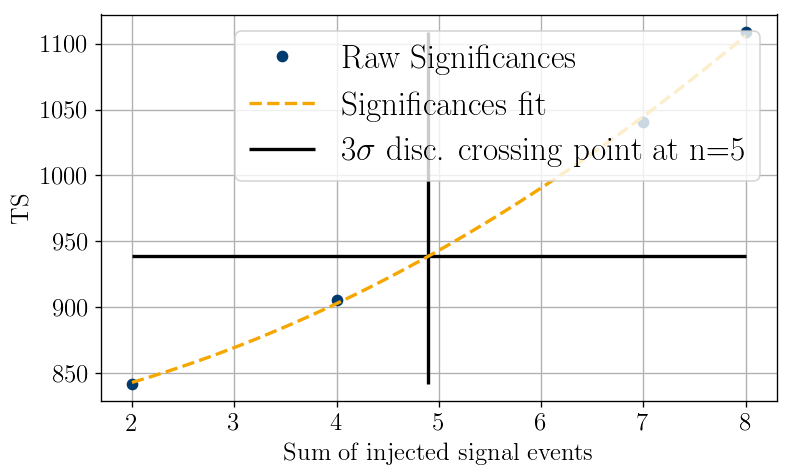

13


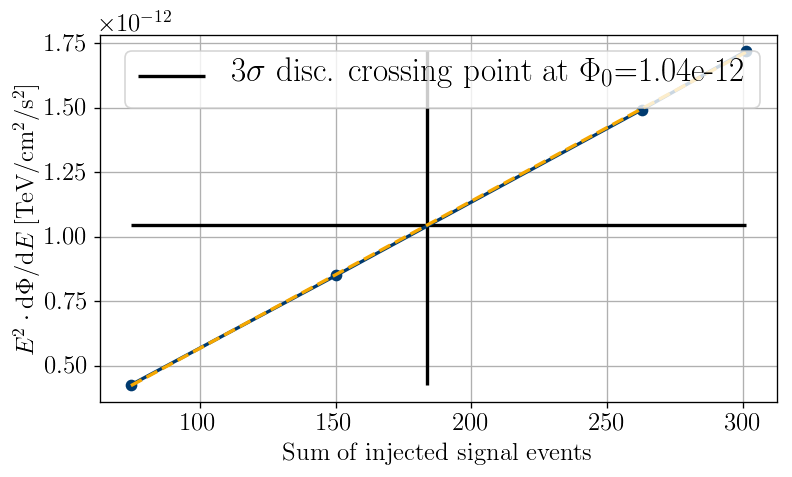

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
85
mu injected:  8.0
14


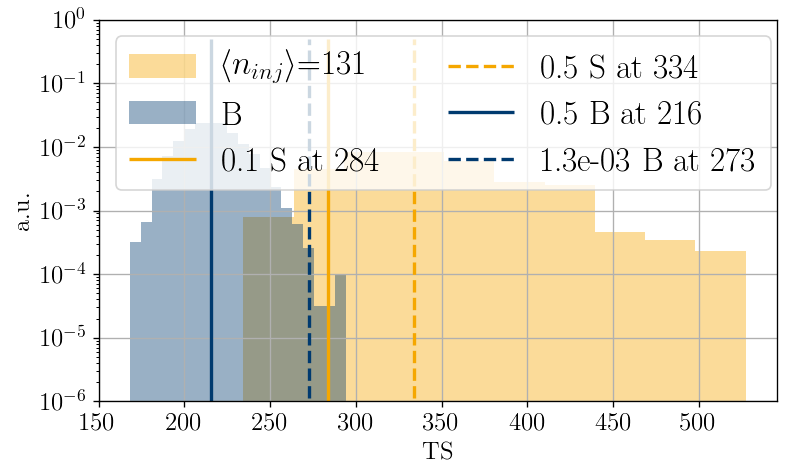

mu injected:  10.0
15


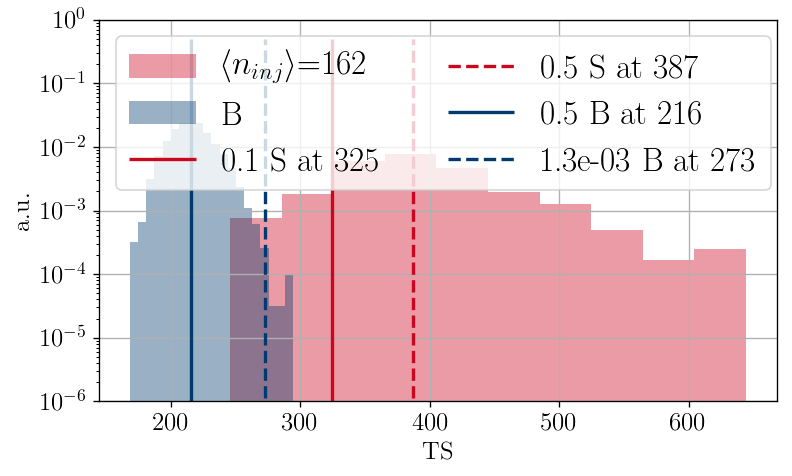

mu injected:  4.0
16


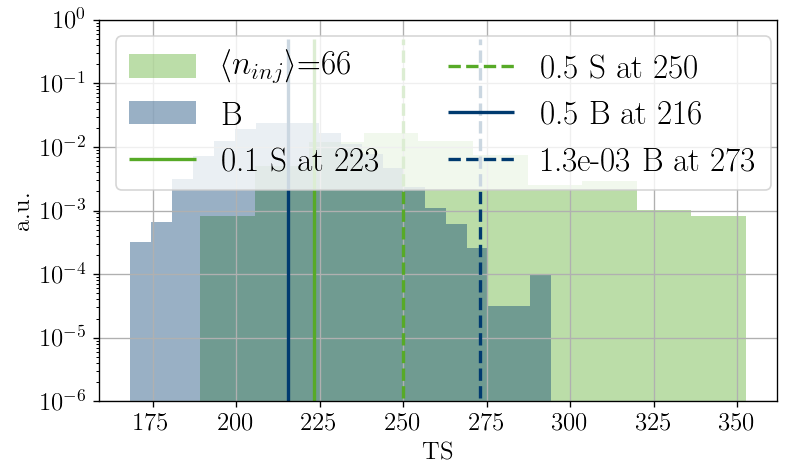

mu injected:  2.0
17


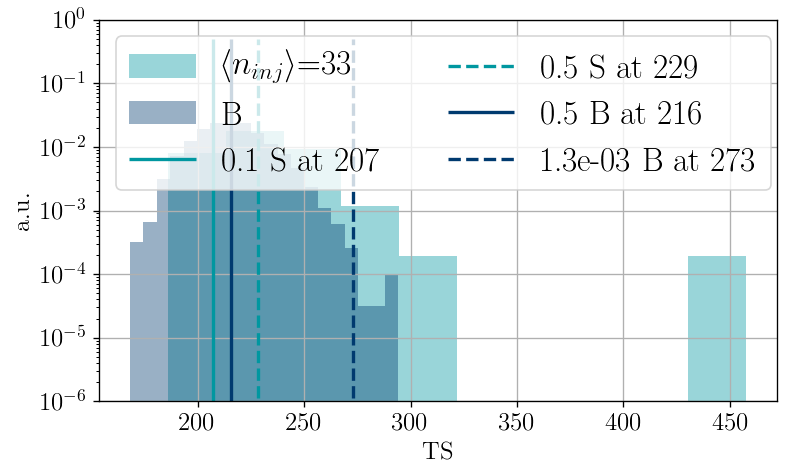

mu injected:  6.0
18


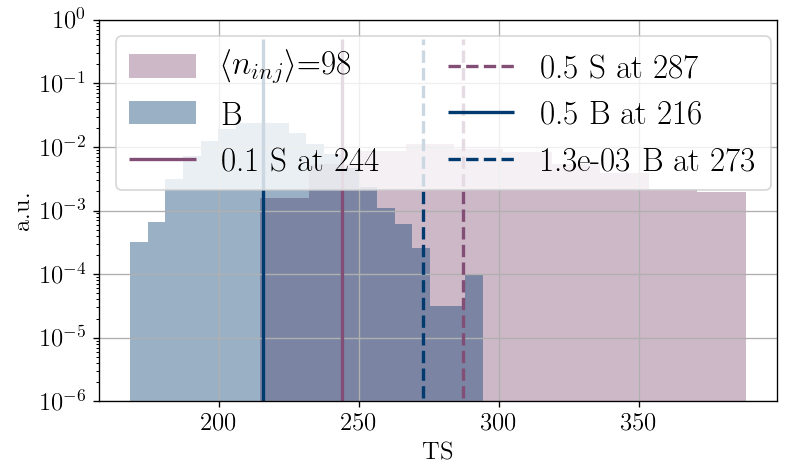

19


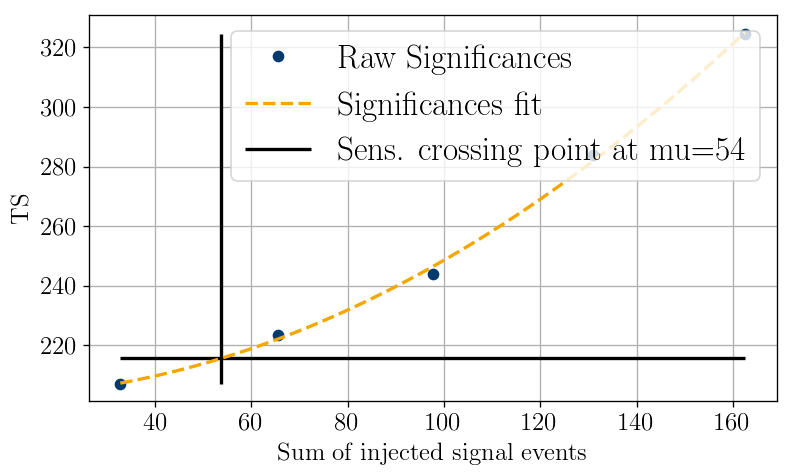

Sens. crossing point at n=3
20


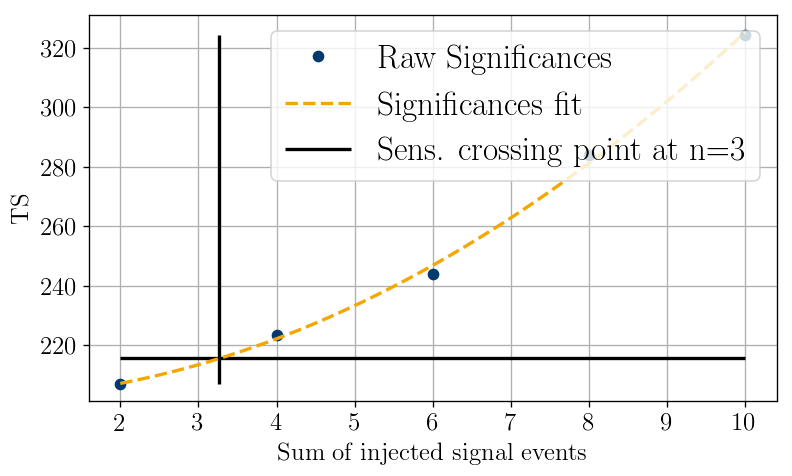

21


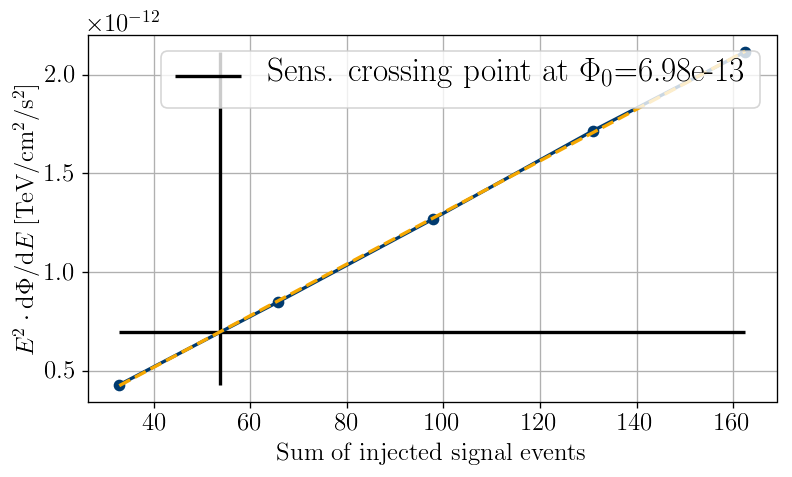

22


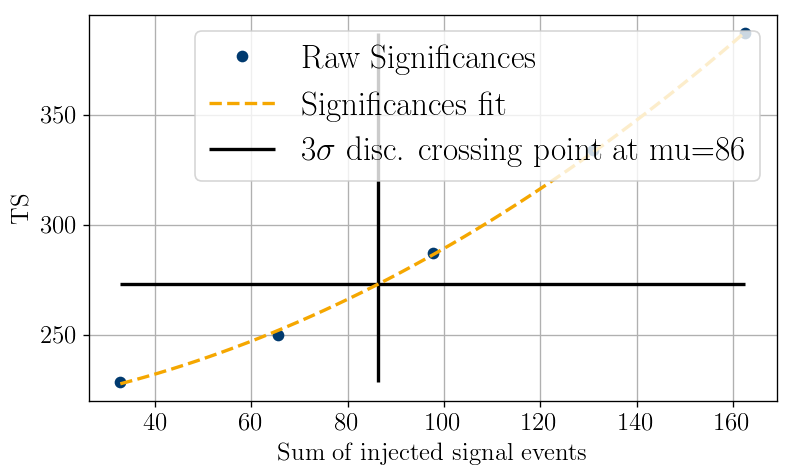

3$\sigma$ disc. crossing point at n=5
23


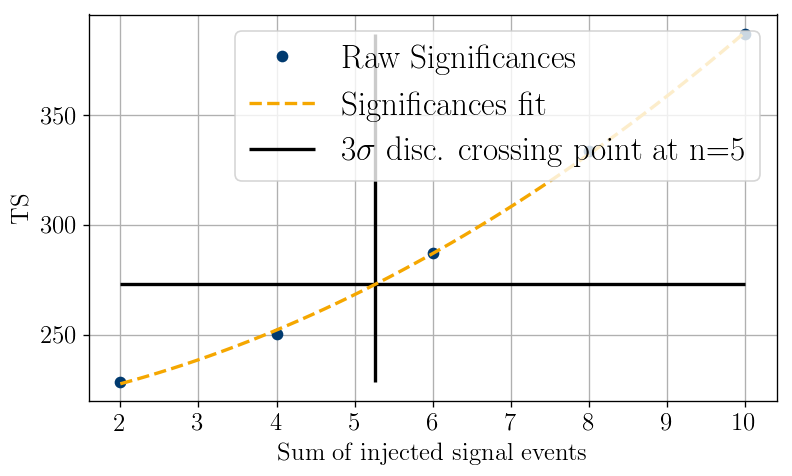

24


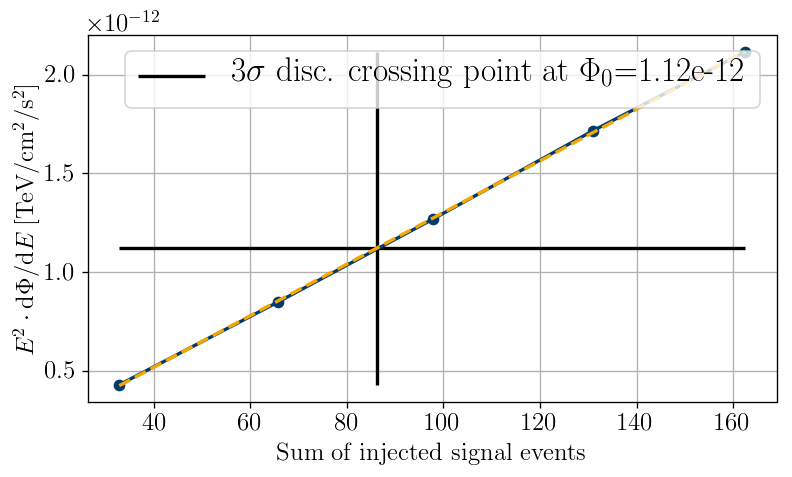

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
100
mu injected:  10.0
25


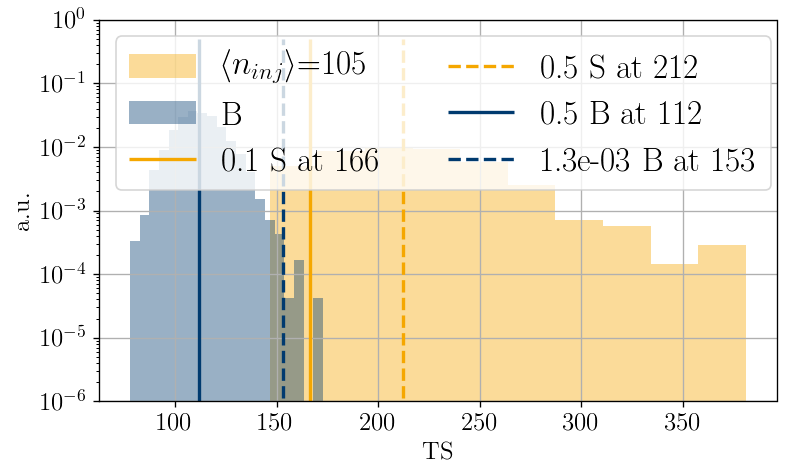

mu injected:  3.0
26


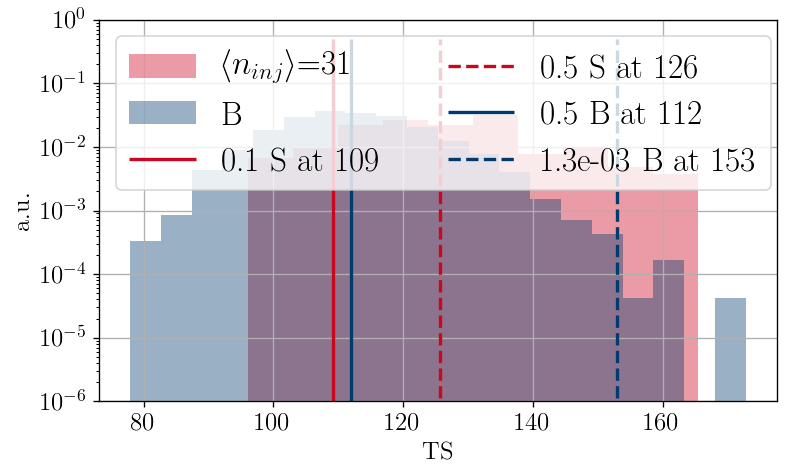

mu injected:  5.0
27


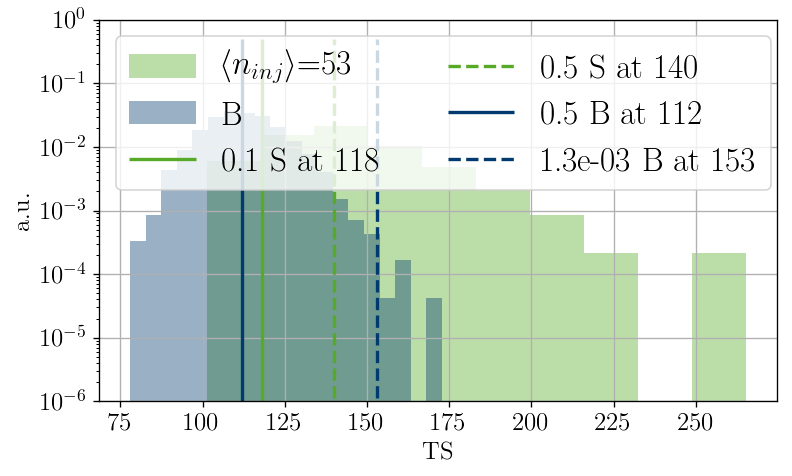

mu injected:  7.0
28


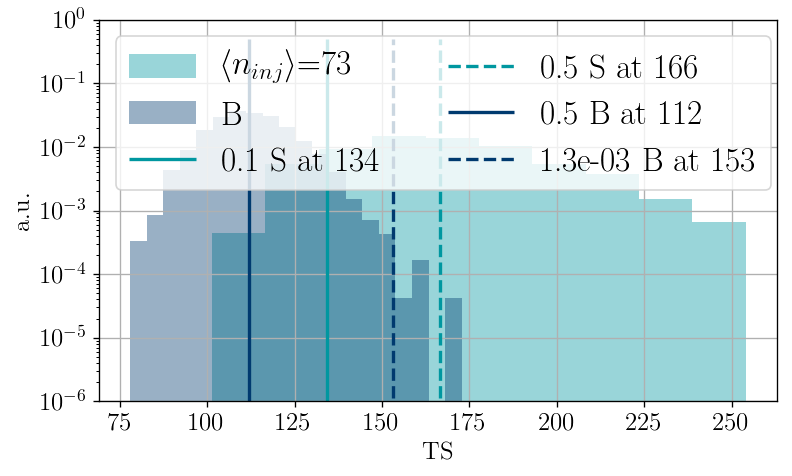

29


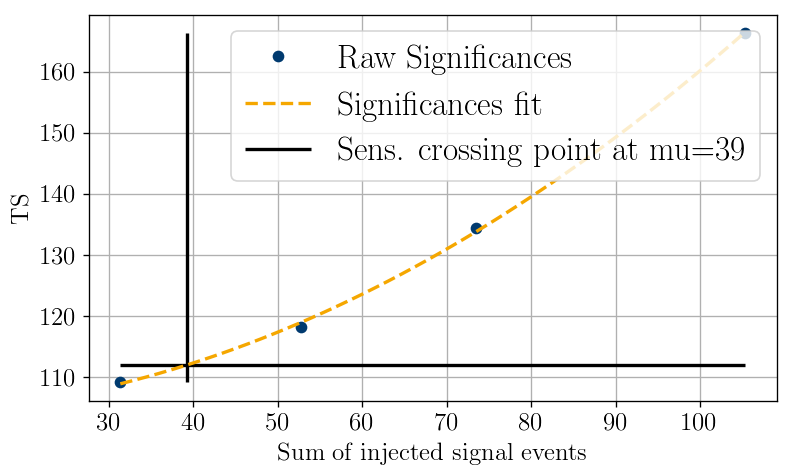

Sens. crossing point at n=4
30


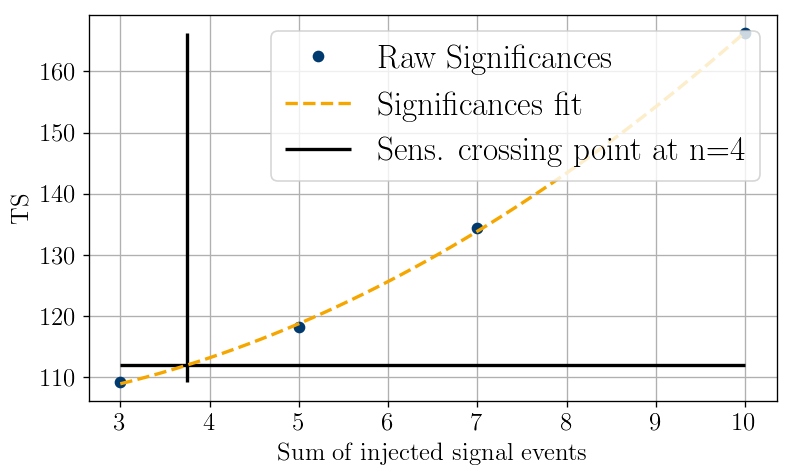

31


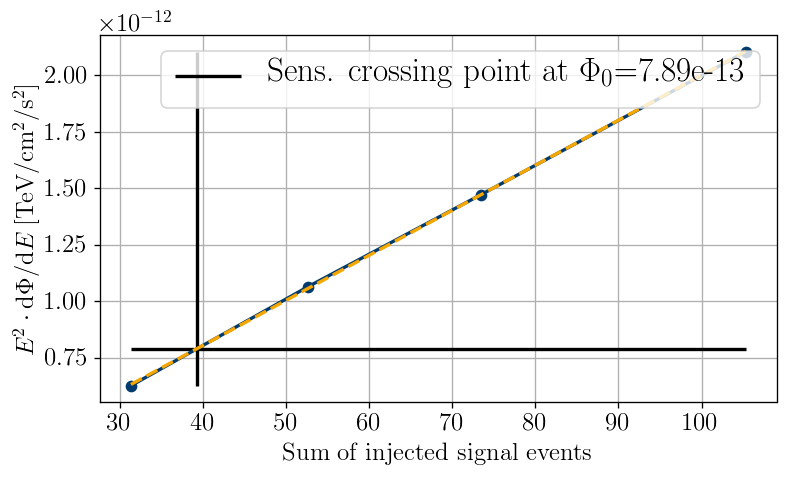

32


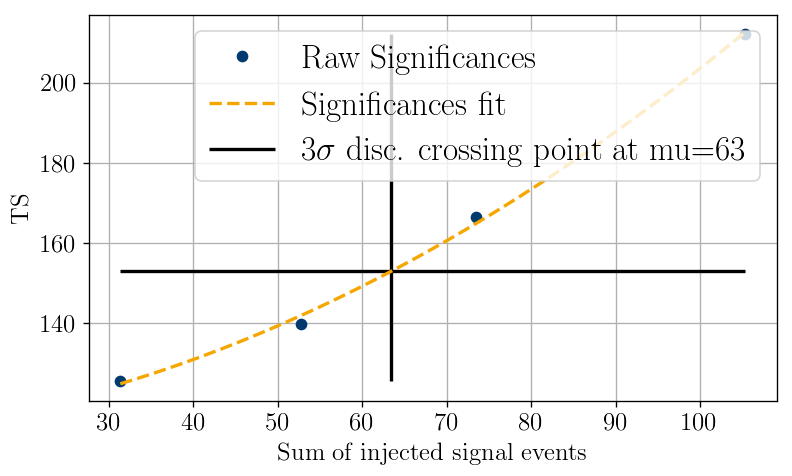

3$\sigma$ disc. crossing point at n=6
33


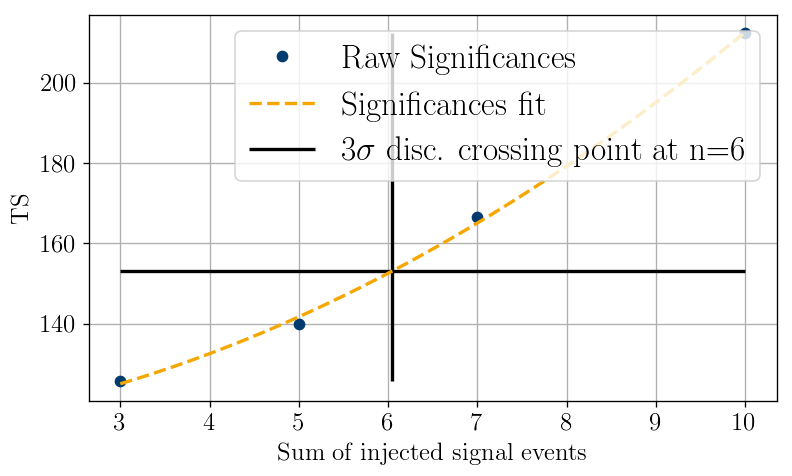

34


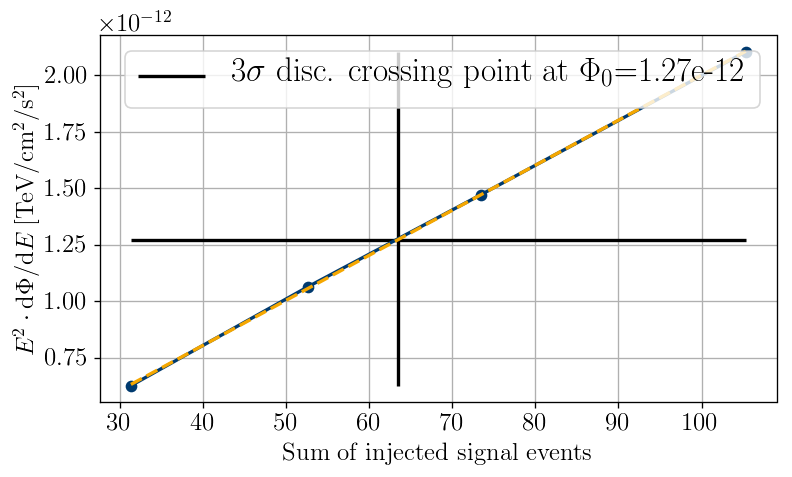

md:  6.0
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
70
mu injected:  2.5
35


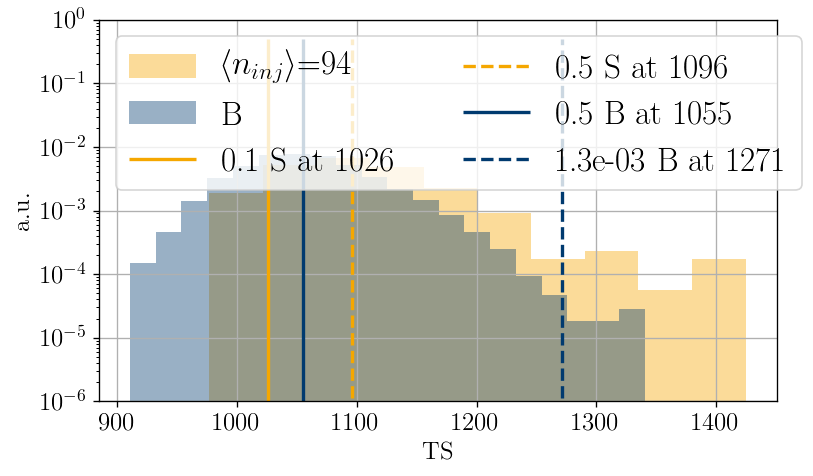

mu injected:  3.5
36


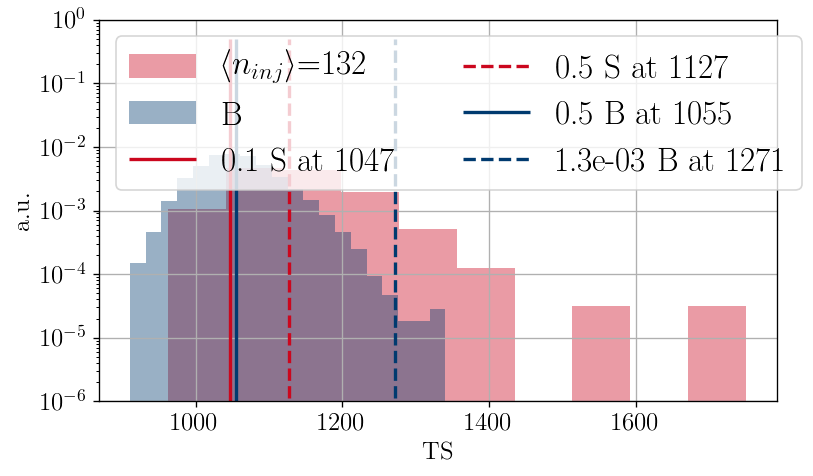

mu injected:  3.0
37


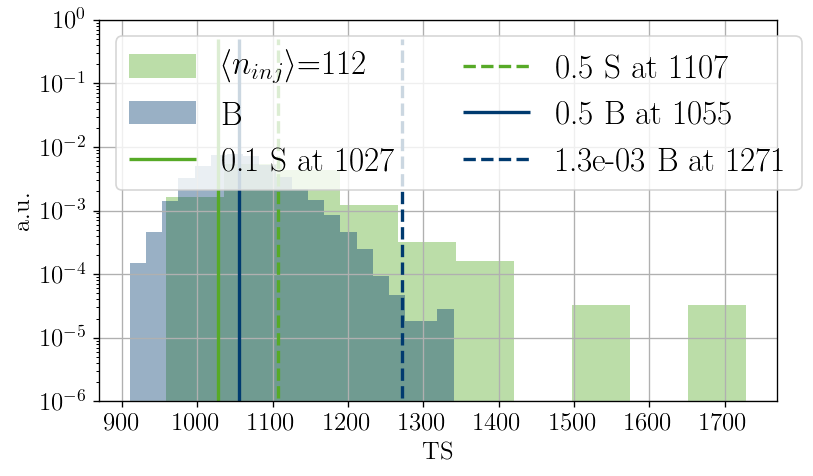

mu injected:  4.0
38


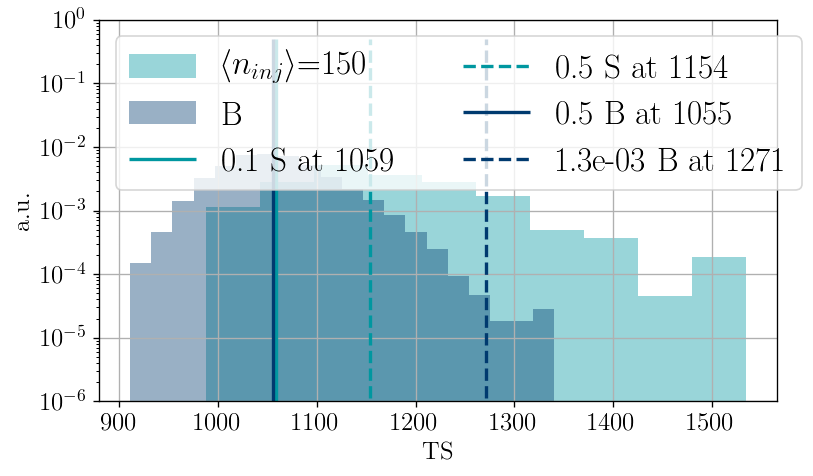

mu injected:  6.0
39


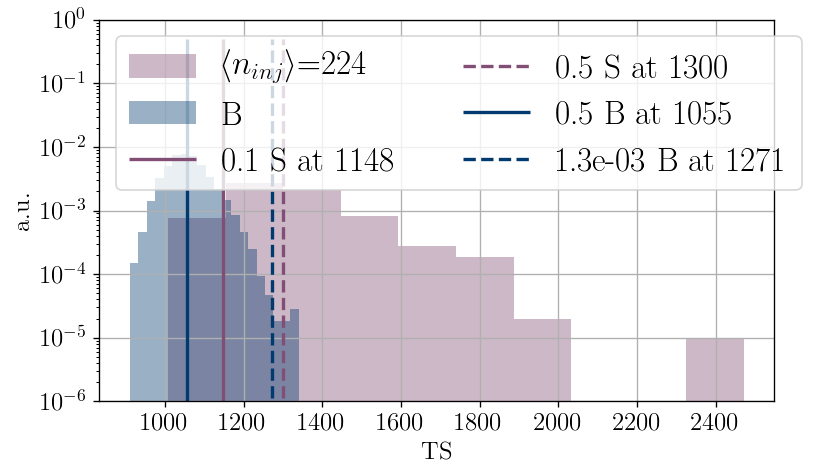

mu injected:  8.0
40


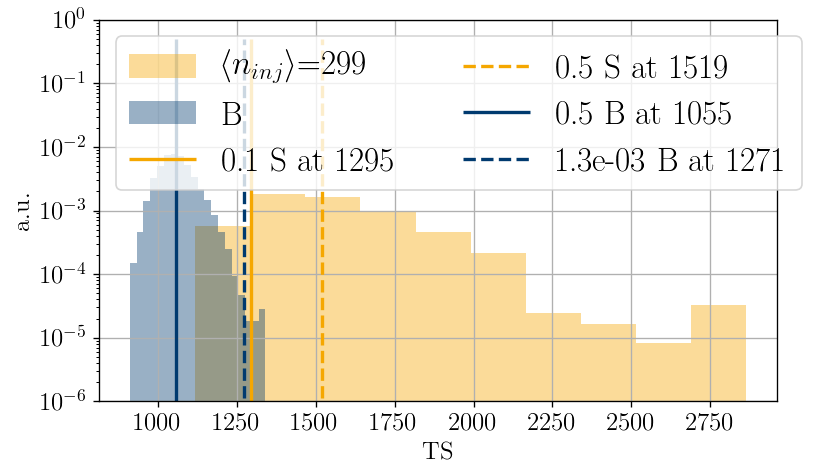

mu injected:  10.0
41


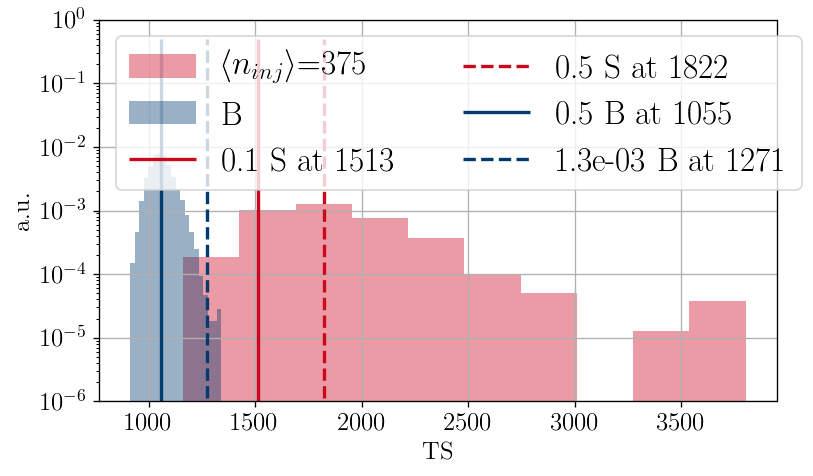

42


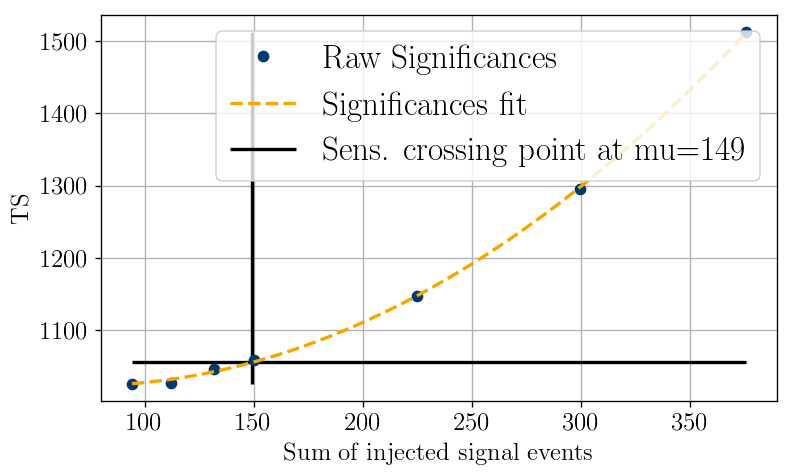

Sens. crossing point at n=4
43


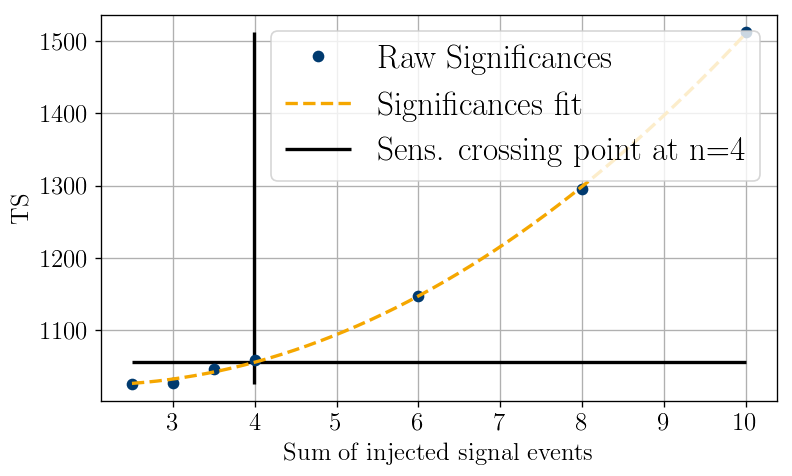

44


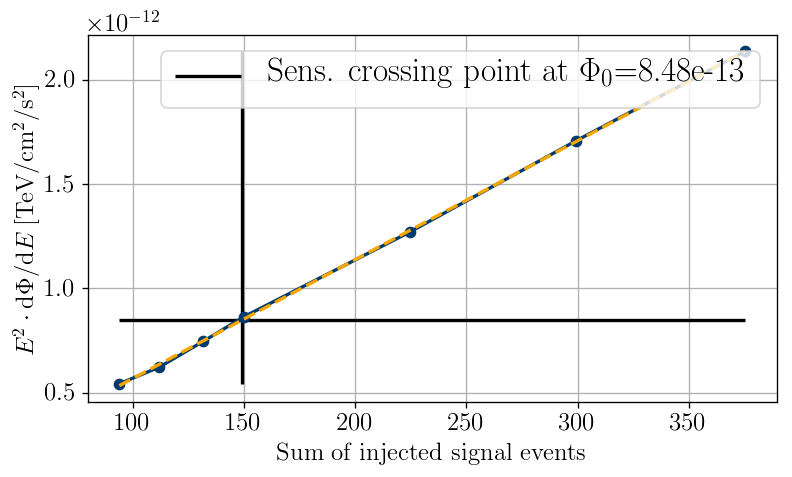

45


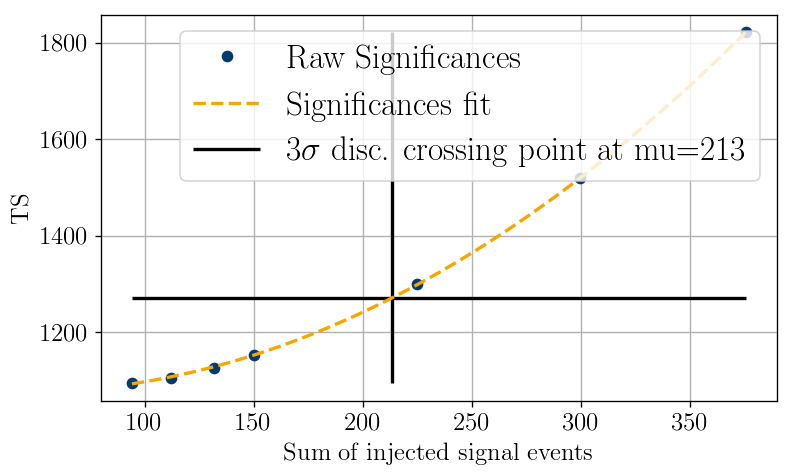

3$\sigma$ disc. crossing point at n=6
46


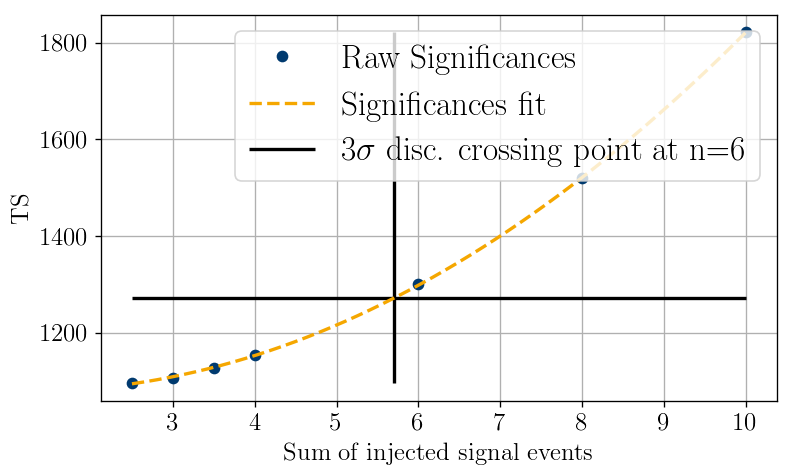

47


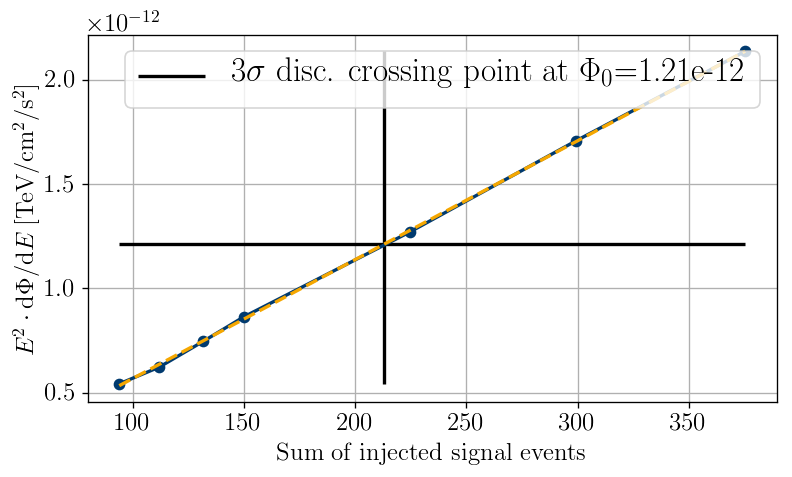

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
85
mu injected:  10.5
48


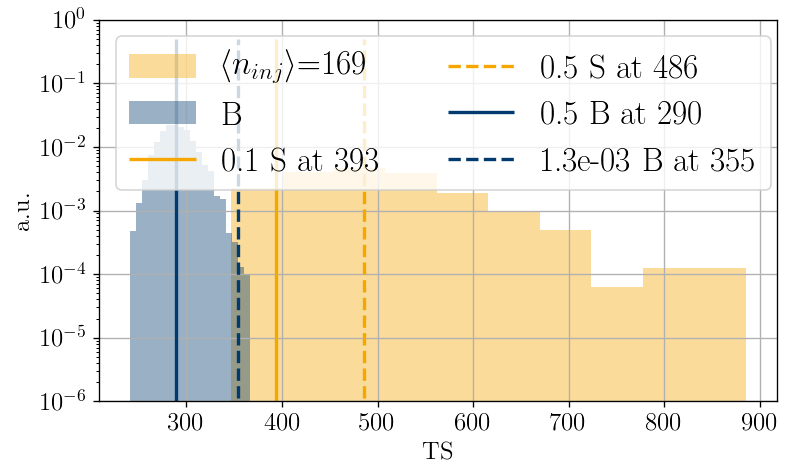

mu injected:  11.5
49


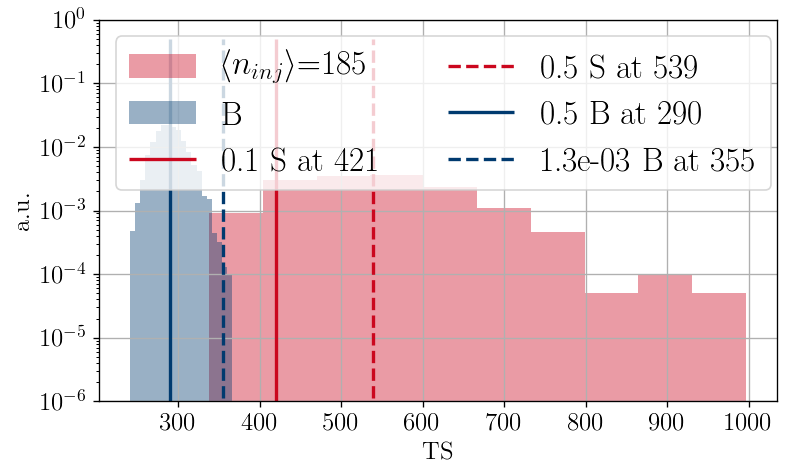

mu injected:  3.0
50


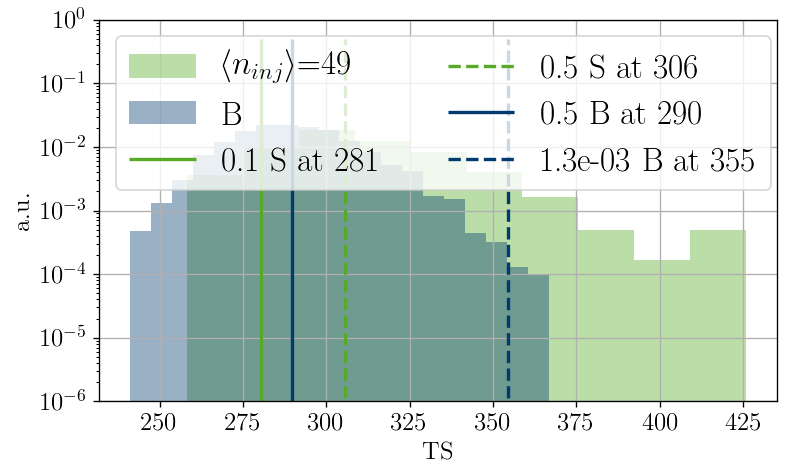

mu injected:  4.0
51


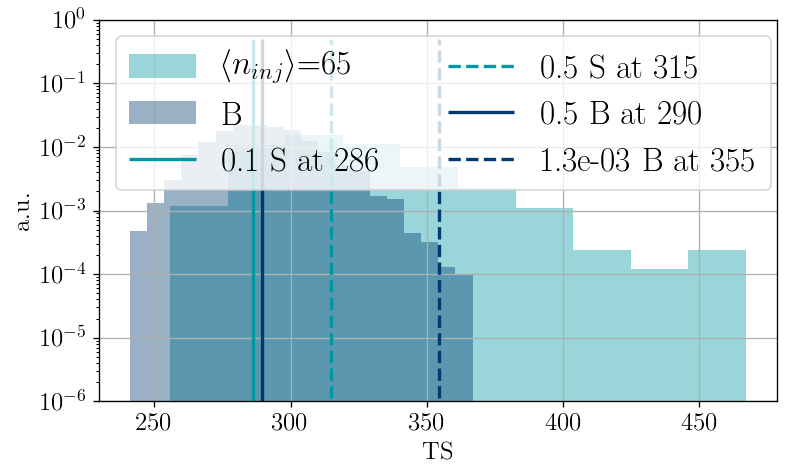

mu injected:  5.0
52


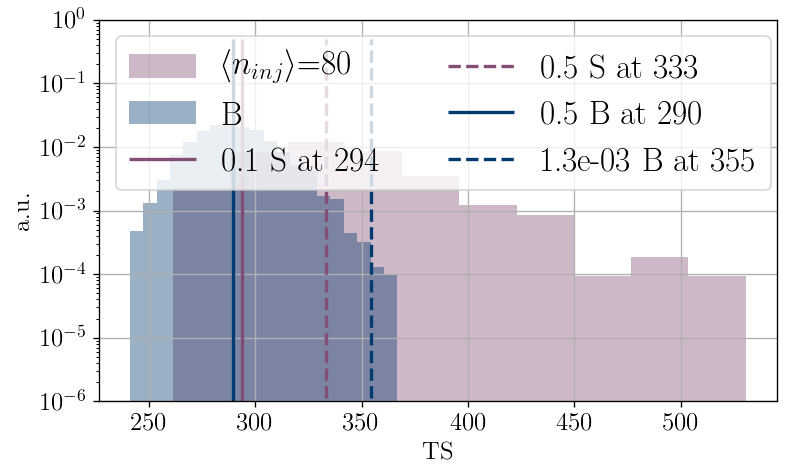

mu injected:  4.4
53


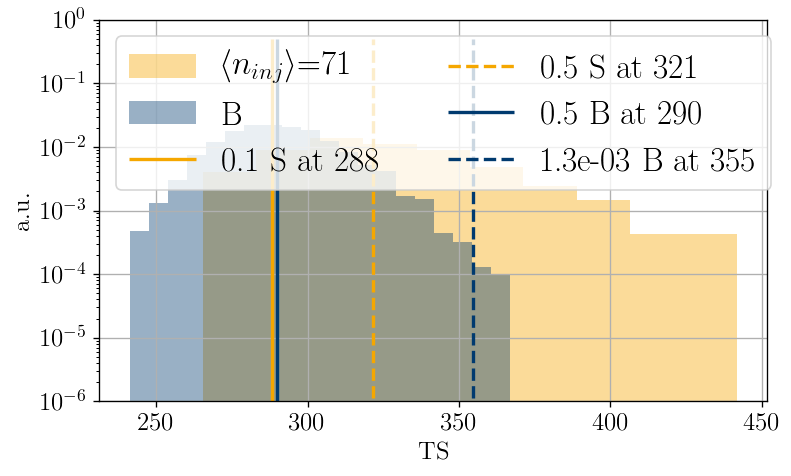

mu injected:  11.0
54


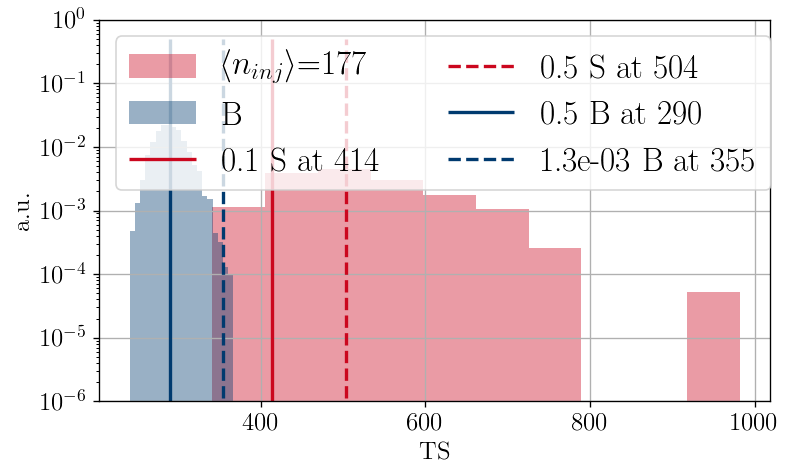

mu injected:  4.2
55


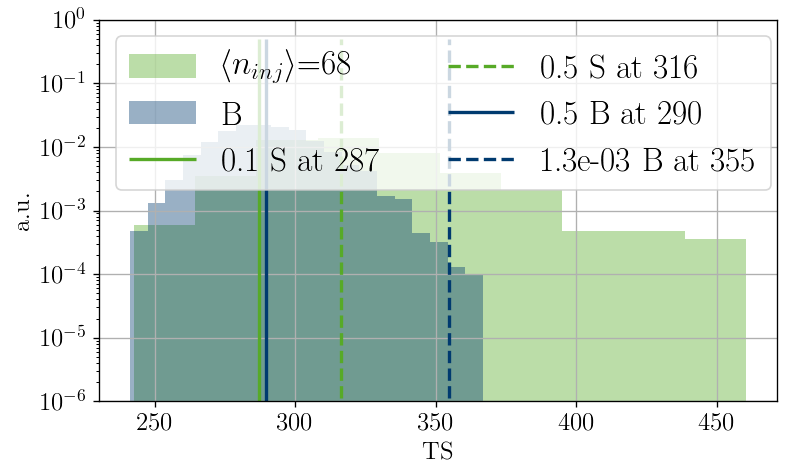

mu injected:  4.6
56


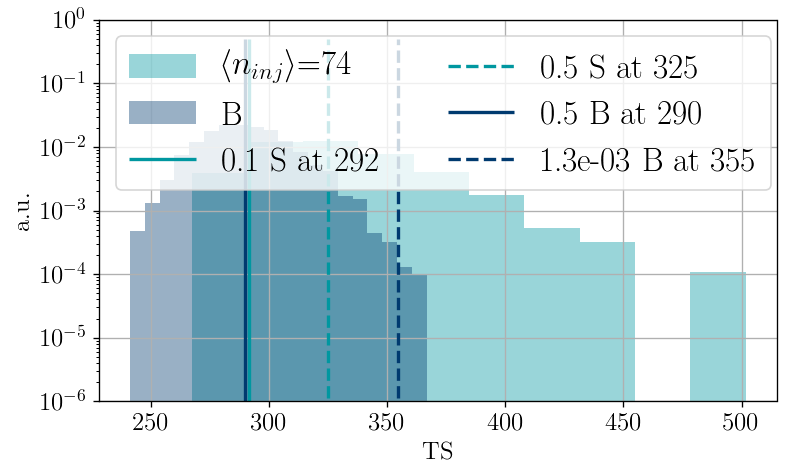

57


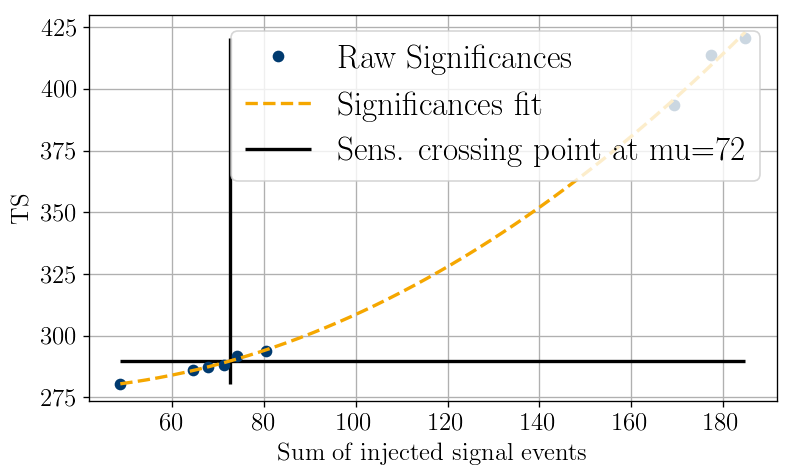

Sens. crossing point at n=4
58


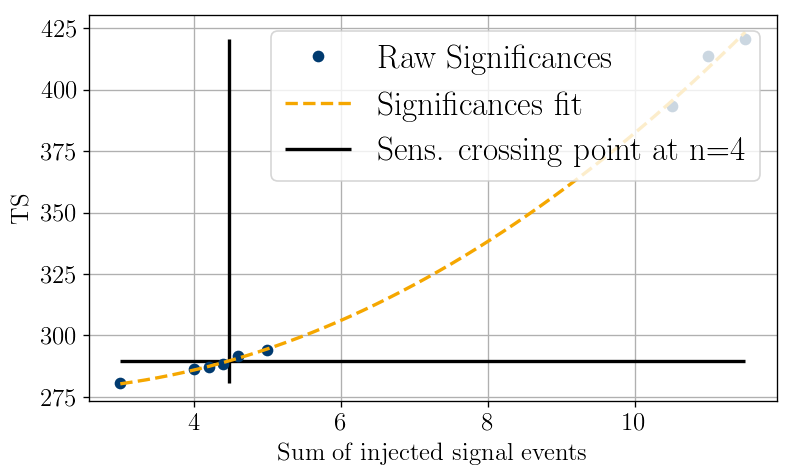

59


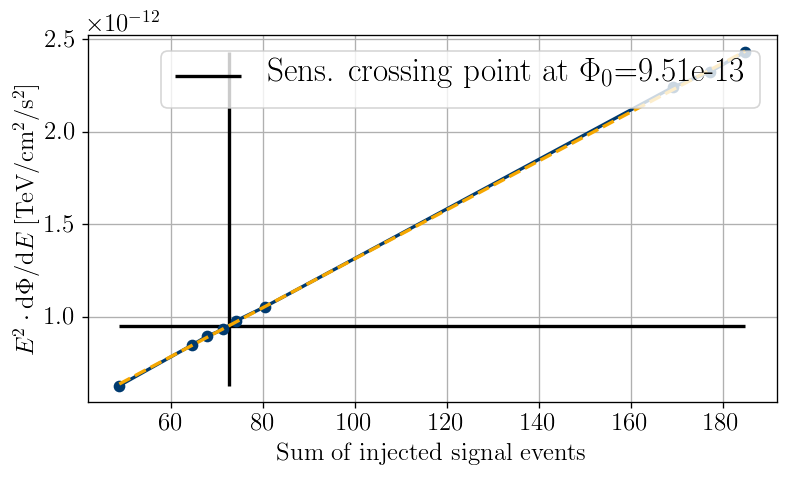

60


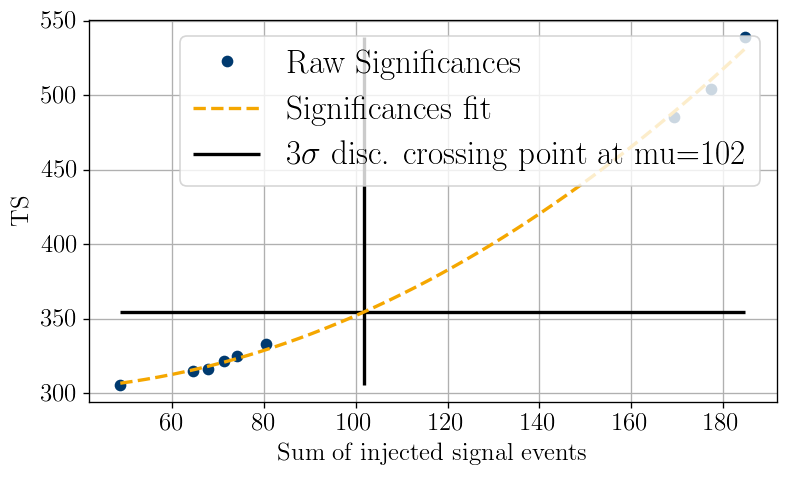

3$\sigma$ disc. crossing point at n=6
61


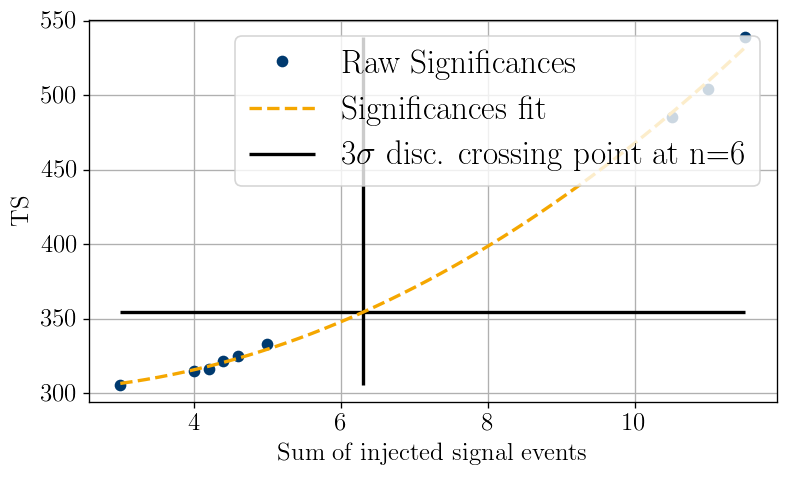

62


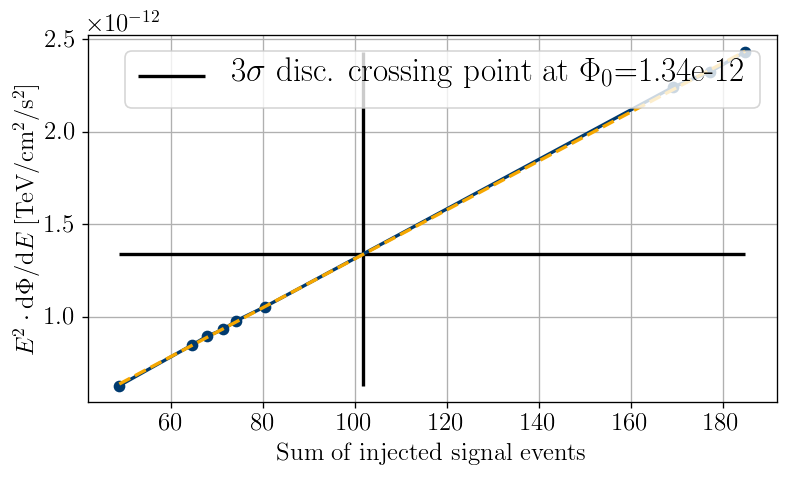

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
100
mu injected:  4.5
63


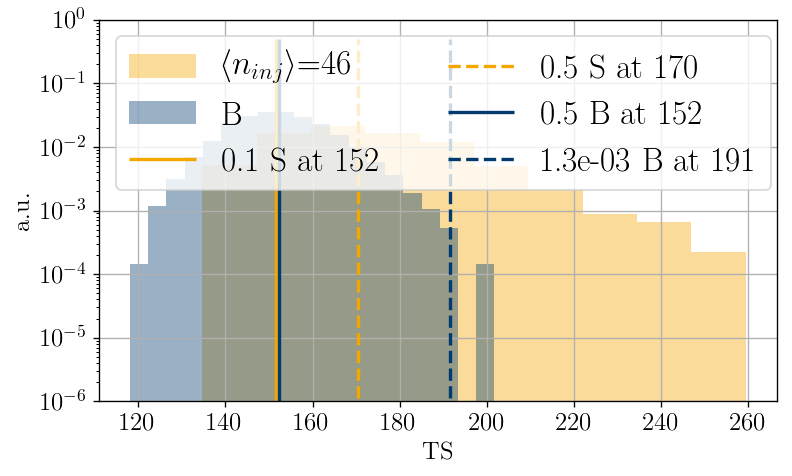

mu injected:  5.5
64


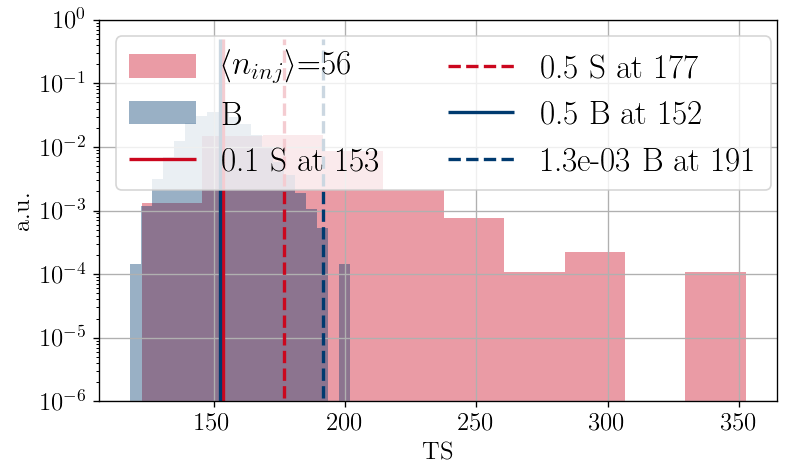

mu injected:  4.0
65


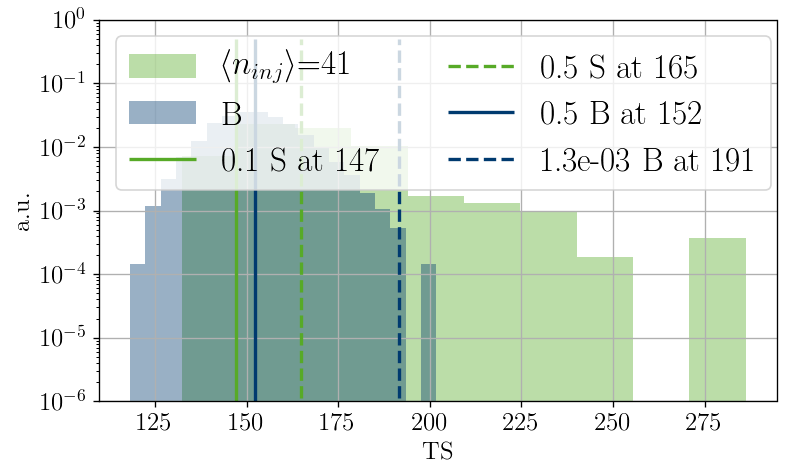

mu injected:  5.0
66


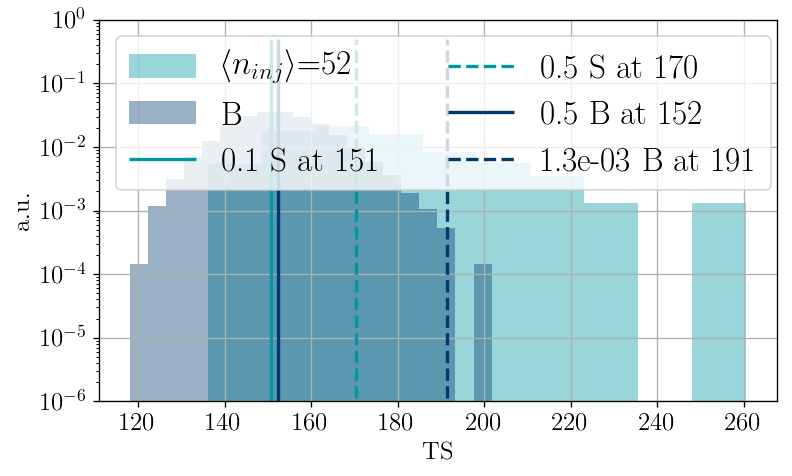

mu injected:  6.0
67


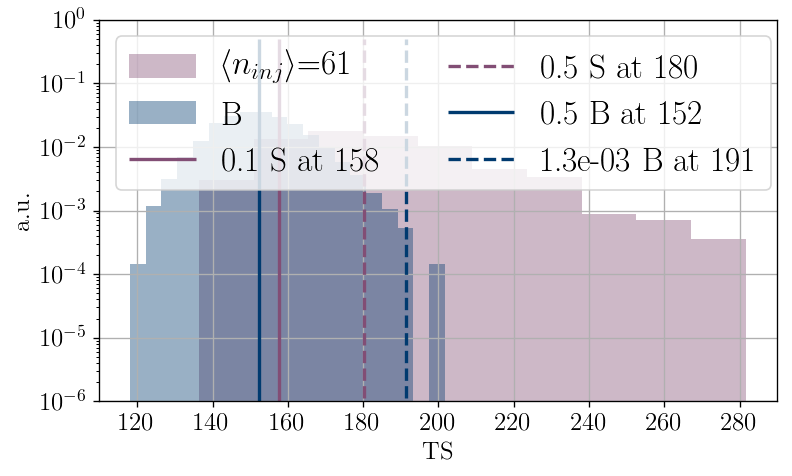

mu injected:  8.0
68


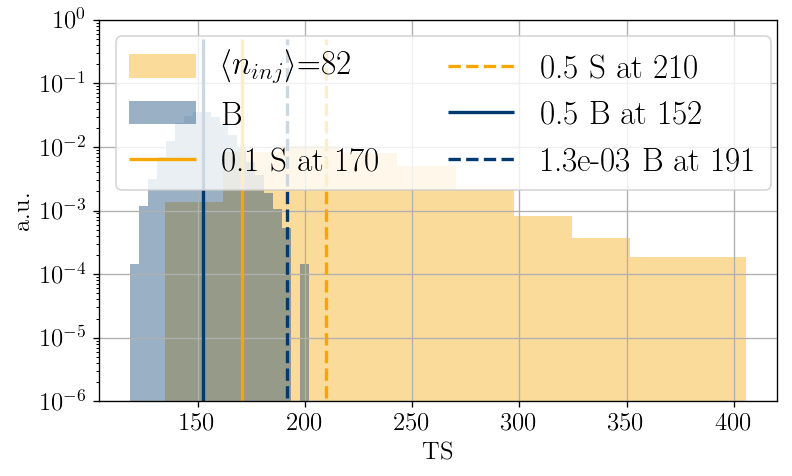

mu injected:  10.0
69


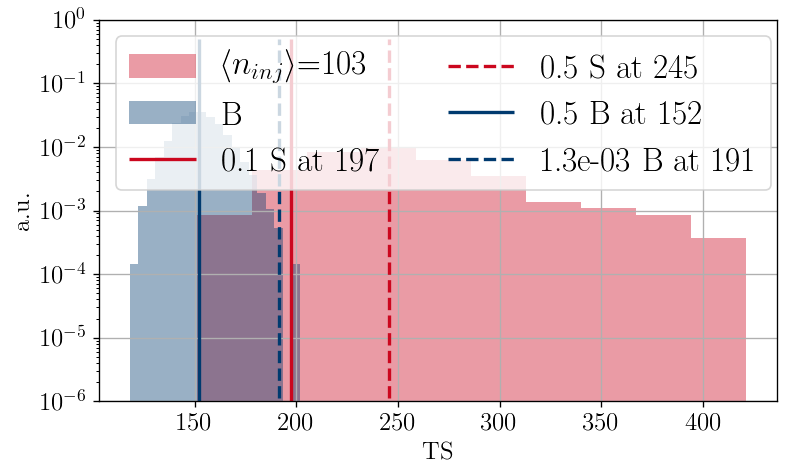

mu injected:  12.0
70


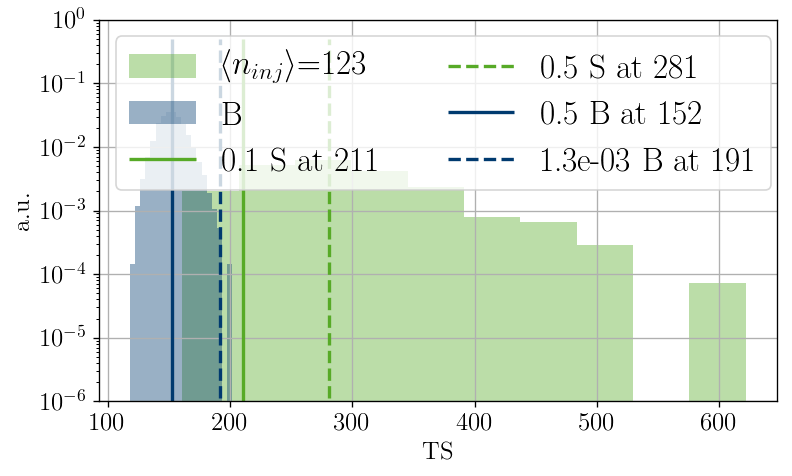

mu injected:  14.0
71


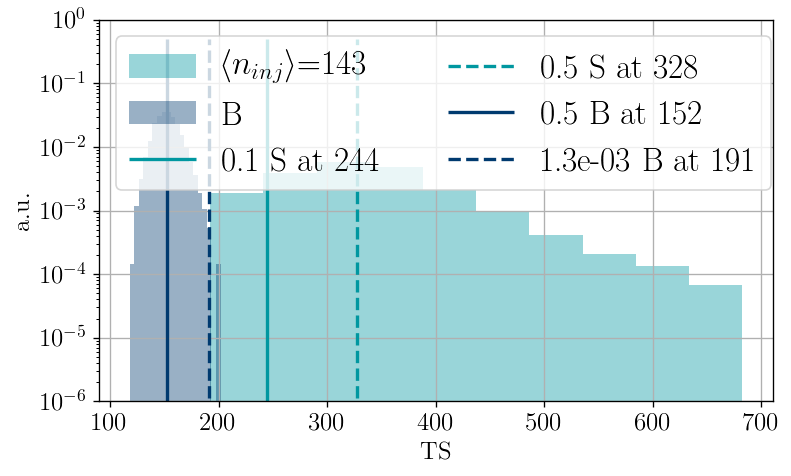

72


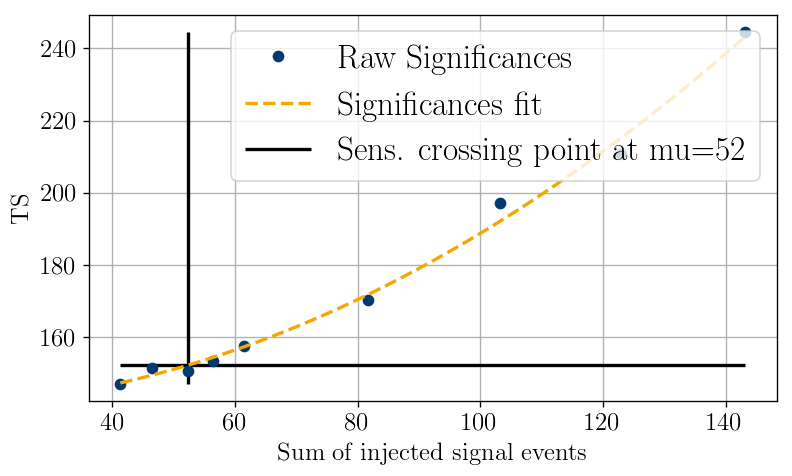

Sens. crossing point at n=5
73


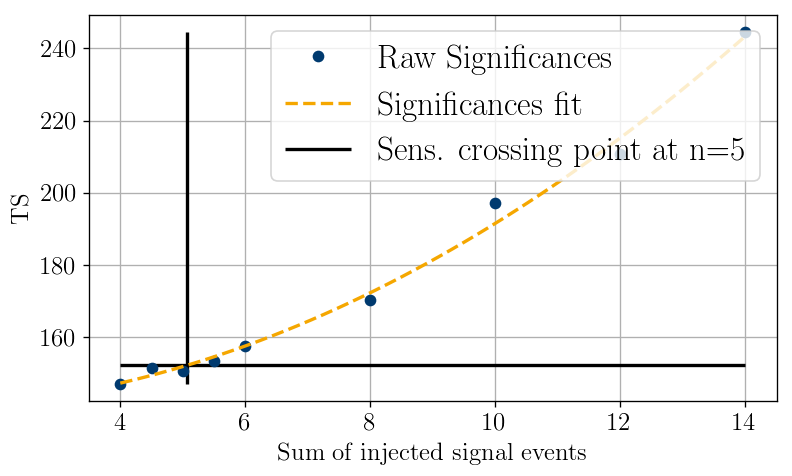

74


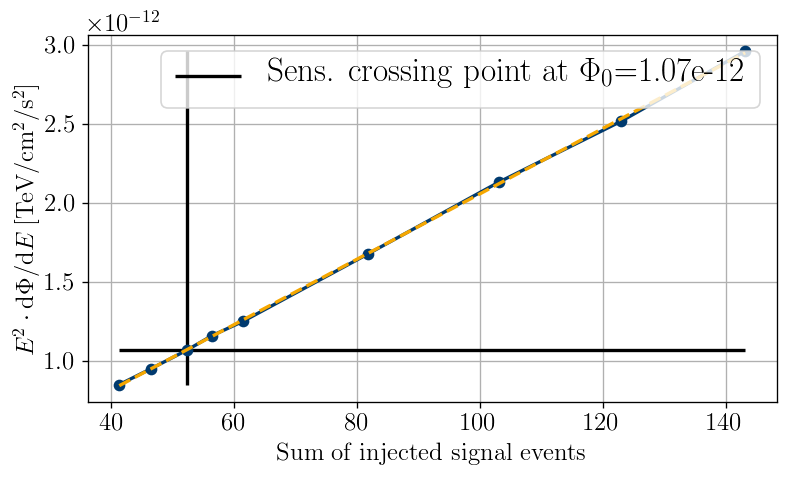

75


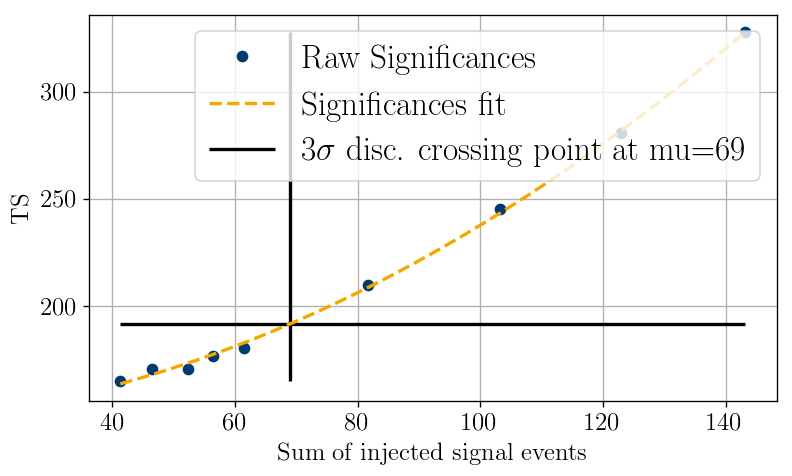

3$\sigma$ disc. crossing point at n=7
76


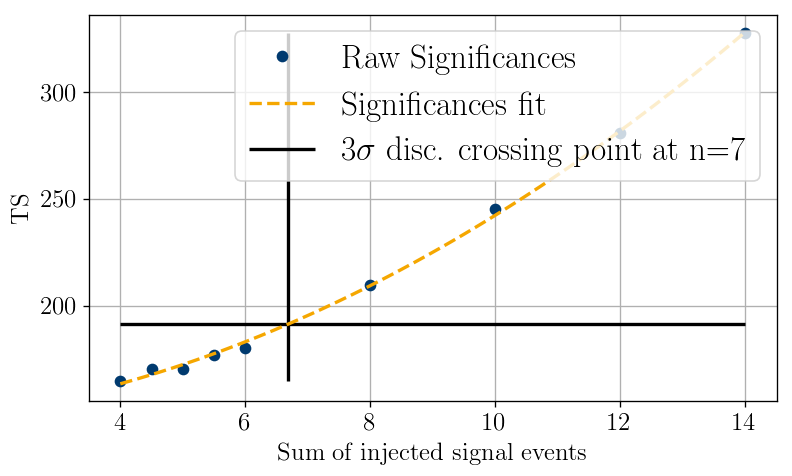

77


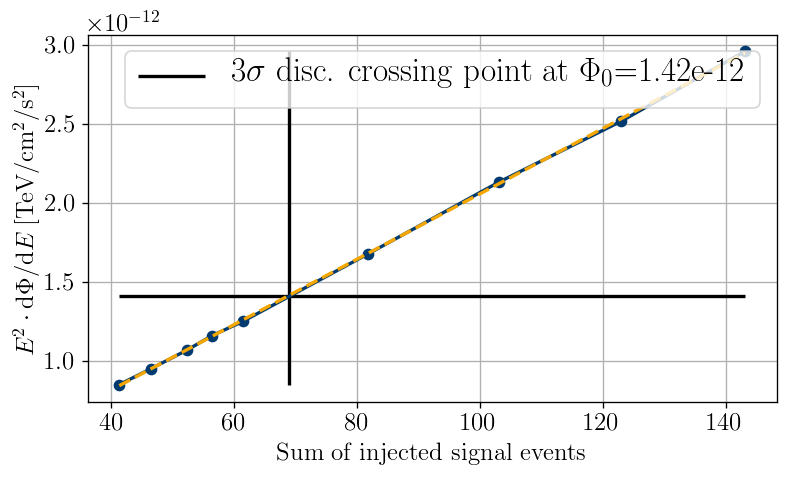

In [21]:
## With different cuts on E
## Sensitivity and disc pot
#"""
tw=7
rcParams = dict()
rcParams["figure.figsize"] = (tw, tw / 1.6)
rcParams["font.size"] = 20
mpl.rcParams.update(rcParams)

#"""
bg_quantiles = [erfc(0.)*0.5, erfc(3./np.sqrt(2))*0.5] #, erfc(5./np.sqrt(2))*0.5] #erfc(3./np.sqrt(2))*0.5, 
s_quantiles = [0.1, 0.5] #, 0.5] #0.5, 
labels=["Sens.", r"3$\sigma$ disc."] #, r"5$\sigma$ disc."]
save_labels=["sens", r"disc3"] #, r"disc5"]
final_flux = []
final_n = dict()
plotting = True
saveplots = False

figure_counter = 3
for md in mdparams:
    print "md: ", md
    final_n[md] = dict()
    for ecut in ecuts:
        print " * "*20
        print ecut
        final_n[md][ecut] = dict()

        ## Select right information from bckg TS depending on energy cut
        valid = np.logical_and(bg_TS["energy"]>=ecut, bg_TS["best"]<50)
        best_bg = np.where(np.logical_and(bg_TS["deflection"]==md, valid), 
                            bg_TS['best'], np.zeros_like(bg_TS['best'])).sum(axis=-1)

        ## Evaluation of Test Statistic

        bins=10
        fitfunc = None
        bg_vals = [np.percentile(best_bg, 100*(1-b_q)) for b_q in bg_quantiles]
        sig_val = []
        #plotting=True
        for i,ak in enumerate(signals[md][ecut]):
            try:
                print "mu injected: ", ak
                signals[md][ecut][ak] = np.array(signals[md][ecut][ak])
                best = signals[md][ecut][ak]['best'].sum(axis=-1)
                to_append = [np.mean(signals[md][ecut][ak]['n_inj'].sum(axis=-1))]
                to_append.extend([np.percentile(best, 100*s_q) for s_q in s_quantiles])
                to_append.extend([ak])
                sig_val.append(to_append)
                if plotting==True:
                    plt.figure(figure_counter)
                    figure_counter+=1
                    sns.distplot(best, bins=bins, rug=False, kde=False, 
                                hist_kws=dict(normed=True, color=utils.colors[i%(clen-1) +1]), 
                                fit_kws=dict( color=utils.colors[i%(clen-1) +1]),
                                label=r"$\langle n_{{inj}} \rangle $={:1.0f}".format(sig_val[-1][0]))

                    sns.distplot(best_bg, bins=bins*2, rug=False, kde=False, fit=fitfunc,
                                hist_kws=dict(normed=True, color=utils.colors[0]), 
                                fit_kws=dict( color=utils.colors[0], markersize=0),
                                label="B")

                    for ii,(s_v, s_q) in enumerate(zip(sig_val[-1][1:-1], s_quantiles)):
                        #if ii==1: continue
                        plt.vlines(s_v, 0, 0.5, 
                                   color=utils.colors[i%(clen-1) +1], 
                                   label="{:1.1f} S at {:1.0f}".format(s_q, s_v),
                                   linestyle=utils.linestyles[ii]
                                  )
                    for ii,(b_q,bg_val) in enumerate(zip(bg_quantiles, bg_vals)):
                        #if ii==1: continue
                        if b_q <0.01:
                            b_label="{:1.1e} B at {:1.0f}".format(b_q, bg_val)
                        else:
                            b_label="{:1.1f} B at {:1.0f}".format(b_q, bg_val)
                        plt.vlines(bg_val, 0, 0.5, 
                                   color=utils.colors[0], 
                                   label=b_label,
                                   linestyle=utils.linestyles[ii]
                                  )
                    plt.legend(loc=2, ncol=2)
                    plt.ylim(1e-6,1)
                    plt.xlabel("TS")
                    plt.ylabel("a.u.")
                    plt.semilogy(nonposy="clip")
                    if saveplots: plt.savefig(os.path.join(figurepath, str(figure_counter)+"_TS_distribution.png"))
                    print figure_counter
                    plt.show()
                    #plotting = False

            except:
                print "Something went wrong ...", sys.exc_info()
                print ak

        for qq,(b_q,s_q) in enumerate(zip(bg_quantiles, s_quantiles)):
            
            temp = np.array(sig_val).T
            mu = temp[0]
            ts = temp[1+qq]
            base_n = temp[-1]
            mu_space = np.linspace(min(mu), max(mu))
            vals = np.polyfit(mu, ts, 2)
            fit = np.poly1d(vals)
            
            
            if plotting==True:
                plt.figure(figure_counter)
                figure_counter += 1
                plt.plot(mu, ts, marker="o", label="Raw Significances", lw=0)
                plt.plot(mu_space, fit(mu_space), linestyle="--", label="Significances fit", markersize=0)
                plt.hlines(bg_vals[qq], min(mu), max(mu))
                
            vals[-1] -= bg_vals[qq]
            roots = np.roots(vals)
            #final_n[md][ecut][save_labels[qq]] = max(roots)
            #print r""+labels[qq]+" crossing point at mu={:1.0f}".format(max(roots))
            if plotting==True:
                plt.vlines(max(roots), min(ts), max(ts), 
                           label=labels[qq]+" crossing point at mu={:1.0f}".format(max(roots))) #roots[roots>min(mu)][0]
                plt.legend(loc=1)
                plt.xlabel("Sum of injected signal events")
                plt.ylabel("TS")
                if saveplots: plt.savefig(os.path.join(figurepath, str(figure_counter)+save_labels[qq]+"_mu_crossing.png"))
                print figure_counter
                plt.show()
                
            ###### we also look at the base value of injected events, as cross check
            n_space = np.linspace(min(base_n), max(base_n))
            n_vals = np.polyfit(base_n, ts, 2)
            n_fit = np.poly1d(n_vals)
            if plotting==True:
                plt.figure(figure_counter)
                figure_counter += 1
                plt.plot(base_n, ts, marker="o", label="Raw Significances", lw=0)
                plt.plot(n_space, n_fit(n_space), linestyle="--", label="Significances fit", markersize=0)
                plt.hlines(bg_vals[qq], min(base_n), max(base_n))
                
            n_vals[-1] -= bg_vals[qq]
            n_roots = np.roots(n_vals)
            final_n[md][ecut][save_labels[qq]] = max(n_roots)
            print labels[qq]+" crossing point at n={:1.0f}".format(max(n_roots))
            if plotting==True:
                plt.vlines(max(n_roots), min(ts), max(ts), 
                           label=labels[qq]+" crossing point at n={:1.0f}".format(max(n_roots))) #roots[roots>min(mu)][0]
                plt.legend(loc=1)
                plt.xlabel("Sum of injected signal events")
                plt.ylabel("TS")
                if saveplots: plt.savefig(os.path.join(figurepath, str(figure_counter)+save_labels[qq]+"_n_crossing.png"))
                print figure_counter
                plt.show()
            ######
            
            mean_flux_per_source = defaultdict()
            n_inj_per_map = defaultdict()
            for i,ak in enumerate(signals[md][ecut]):
                """
                here we have ALL signal contributions from one certain mu,
                this has shape N_MAPS x N_CR.
                the mean is then calculated over all N_CR contribution
                yielding a mean flux per source and map.
                we also sum over the whole number of injected events per map
                """
                mean_flux_per_source[ak] = np.mean(signals[md][ecut][ak]['n_inj'] * \
                                                   1./flux_spline(np.sin(signals[md][ecut][ak]['dec_inj'])), axis=-1)
                n_inj_per_map[ak] = signals[md][ecut][ak]['n_inj'].sum(axis=-1)


            n_inj_sum = np.zeros(len(n_inj_per_map.keys()))
            flux_mean = np.zeros(len(mean_flux_per_source.keys()))
            for i,key in enumerate(n_inj_per_map):
                """
                Next, we average over each mu, 
                since one certain signal strength should yield one certain average flux
                """
                n_inj_sum[i]=np.mean(n_inj_per_map[key])
                flux_mean[i]=np.mean(mean_flux_per_source[key])

            
            idx = np.argsort(n_inj_sum)
            nspace = np.linspace(min(n_inj_sum), max(n_inj_sum), num=100)
            vals = np.polyfit(n_inj_sum[idx], flux_mean[idx], 1)
            fit = np.poly1d(vals)
            final_flux.append([ecut, fit(max(roots))])
            if plotting==True:
                plt.figure(figure_counter)
                figure_counter+=1
                plt.plot(n_inj_sum[idx], flux_mean[idx], marker="o")
                plt.plot(nspace, fit(nspace), linestyle="--", markersize=0)
                plt.vlines(max(roots), min(flux_mean[idx]), max(flux_mean[idx])) 
                plt.hlines(final_flux[-1][1], min(n_inj_sum), max(n_inj_sum), 
                           label=labels[qq]+r" crossing point at $\Phi_0$={:1.2e}".format(final_flux[-1][1]))
                plt.xlabel("Sum of injected signal events")
                plt.ylabel(r"$E^2 \cdot \mathrm{d}\Phi/\mathrm{d}E \; [\mathrm{TeV}/\mathrm{cm}^2/\mathrm{s}^2]$")
                plt.legend(loc=1)
                if saveplots: plt.savefig(os.path.join(figurepath, str(figure_counter)+save_labels[qq]+"_phi_crossing.png"))
                print figure_counter
                plt.show()
            #except:
            #print "Calculating interpolations failed!"
        #break
    #break

In [22]:
final_flux_percentile = np.copy(final_flux)
a = np.array(final_flux).T
b = np.repeat(mdparams, len(a[0])/2)
b = b[np.newaxis]
c = np.concatenate((a, b), axis=0)

np.savetxt(os.path.join(savepath, "final_performance_fluxes_fixed_gamma_ts_percentile.npy"), c.T)

## TS not yet summed

In [ ]:
tw = 5
gr = 1.5 #0.5*(1. + np.sqrt(5))
rcParams = dict()
rcParams["figure.figsize"] = (tw, tw/gr)
mpl.rcParams.update(rcParams)

## With different cuts on E
## Sensitivity and disc pot


figure_counter = 43
for md in mdparams:
    print "md: ", md 
    for ecut in ecuts:
        print " * "*20 
        ## Use Percentiles, because most fits are unstable
        bins=50
        sig_val = []
        #plotting=True
        for i,ak in enumerate(signals[md][ecut]): 
            print "mu injected: ", ak
            signals[md][ecut][ak] = np.array(signals[md][ecut][ak])
            best = signals[md][ecut][ak]['best'].flatten()
            
            plt.figure(figure_counter)
            figure_counter+=1
            sns.distplot(best, bins=bins, rug=False, kde=False, 
                        hist_kws=dict(normed=True, color=utils.colors[i%(clen-1) +1]), 
                        fit_kws=dict( color=utils.colors[i%(clen-1) +1]),
                        #label=r"$\langle n_{{inj}} \rangle $={:1.0f}".format(sig_val[-1][0])
                        ) 
            plt.legend(loc=2, ncol=2)
            plt.ylim(1e-6,1)
            plt.xlabel("TS")
            plt.ylabel("a.u.")
            plt.semilogy(nonposy="clip") 
            print figure_counter
            plt.show()

md:  3.0
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
44


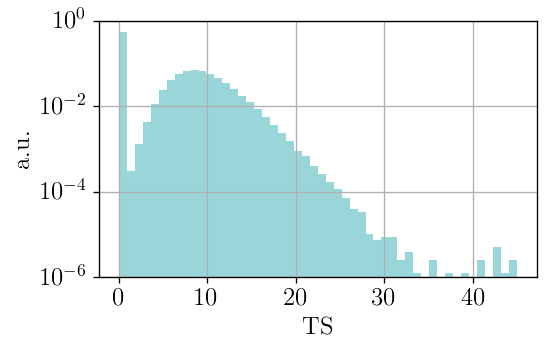

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
45


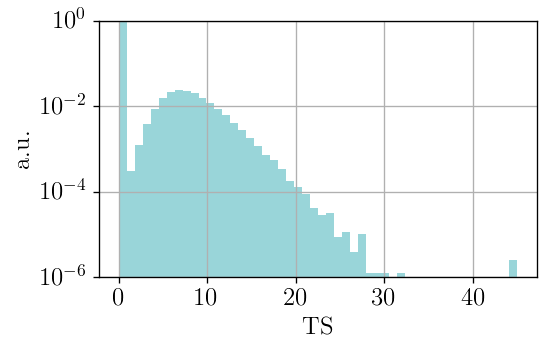

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
46


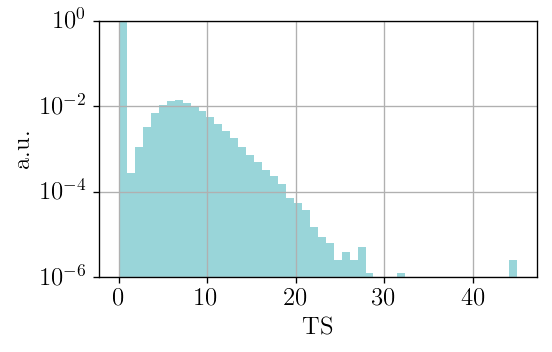

md:  6.0
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
47


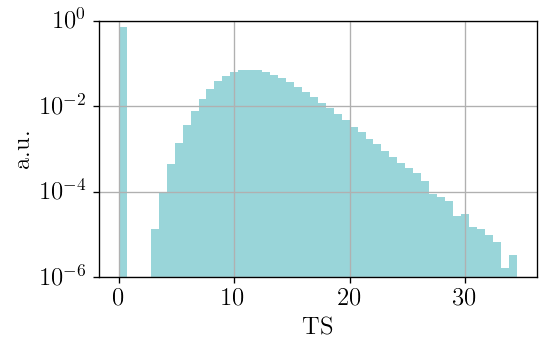

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
48


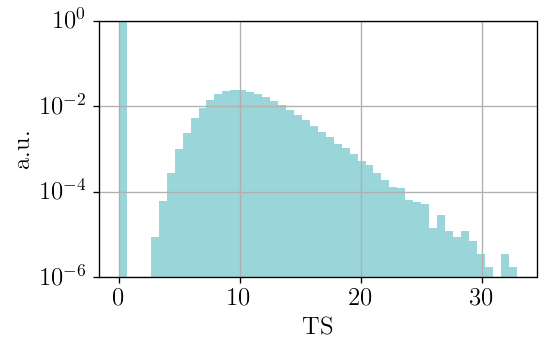

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
49


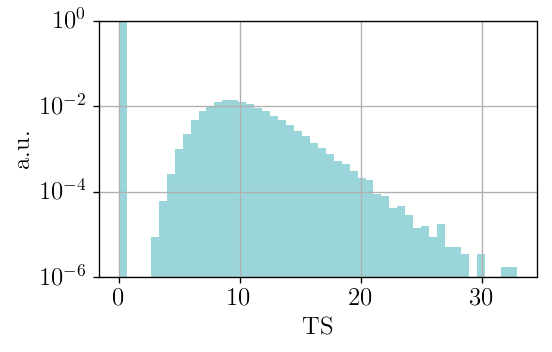

In [26]:
tw = 5
gr = 1.5 #0.5*(1. + np.sqrt(5))
rcParams = dict()
rcParams["figure.figsize"] = (tw, tw/gr)
mpl.rcParams.update(rcParams)

## With different cuts on E
## Sensitivity and disc pot


figure_counter = 43
for md in mdparams:
    print "md: ", md 
    for ecut in ecuts:
        print " * "*20 
        ## Use Percentiles, because most fits are unstable
        bins=50
        sig_val = []
        #plotting=True
        #valid = bg_TS["energy"]>=ecut
        valid = np.logical_and(bg_TS["energy"]>=ecut, bg_TS["best"]<50)
        best_bg = np.where(np.logical_and(bg_TS["deflection"]==md, valid), 
                            bg_TS['best'], np.zeros_like(bg_TS['best'])).flatten()
            
        plt.figure(figure_counter)
        figure_counter+=1
        sns.distplot(best_bg, bins=bins, rug=False, kde=False, 
                    hist_kws=dict(normed=True, color=utils.colors[i%(clen-1) +1]), 
                    fit_kws=dict( color=utils.colors[i%(clen-1) +1]),
                    #label=r"$\langle n_{{inj}} \rangle $={:1.0f}".format(sig_val[-1][0])
                    ) 
        plt.legend(loc=2, ncol=2)
        plt.ylim(1e-6,1)
        plt.xlabel("TS")
        plt.ylabel("a.u.")
        plt.semilogy(nonposy="clip") 
        print figure_counter
        plt.show()

## # TO DO: North trials

## Splines for averaging PS results over declinations

/home/lschumacher/my_virtualenvs/my_skylab/lib/python2.7/site-packages/scipy/interpolate/fitpack2.py:224: UserWarning: 
A theoretically impossible result was found during the iteration
proces for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


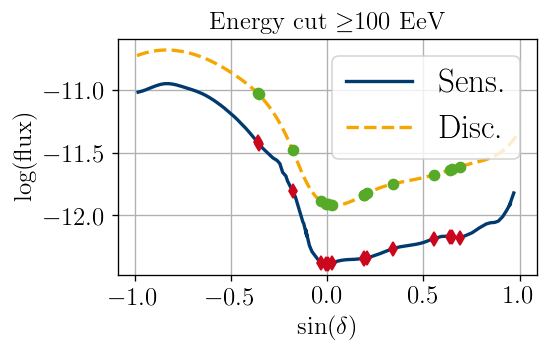

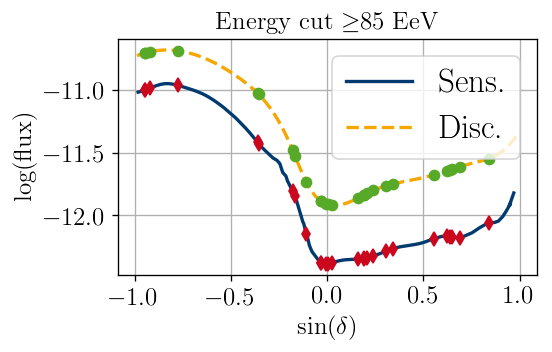

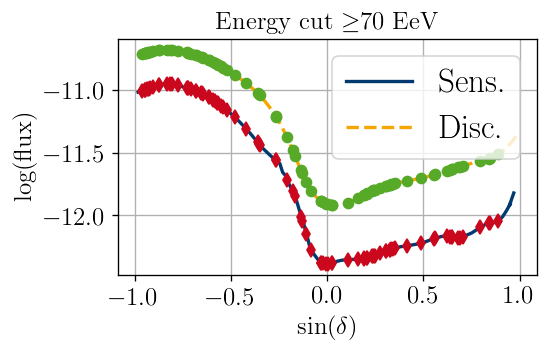

In [27]:
sens_spline = UnivariateSpline(s_sens[0], np.log10(np.array(s_sens[1])), k=3, s=0.01)
disc_spline = UnivariateSpline(s_disc[0], np.log10(np.array(s_disc[1])), k=3, s=0.01)

stefan_sens = []
stefan_disc = []
saveplots = True
for ecut in ecuts:
    mask = energy>=ecut
    stefan_sens.append(np.mean(np.power(10, sens_spline(np.sin(dec[mask])))))
    stefan_disc.append(np.mean(np.power(10, disc_spline(np.sin(dec[mask])))))
    plt.figure(ecut)
    plt.plot(s_sens[0], sens_spline(s_sens[0]), markersize=0, label="Sens.")
    plt.plot(s_disc[0], disc_spline(s_disc[0]), markersize=0, label="Disc.")
    plt.plot(np.sin(dec[mask]), sens_spline(np.sin(dec[mask])), lw=0, ls="-")
    plt.plot(np.sin(dec[mask]), disc_spline(np.sin(dec[mask])), lw=0, ls="-")
    plt.title(r"Energy cut $\geq${} EeV".format(ecut))
    plt.ylabel("log(flux)")
    plt.xlabel(r"$\sin(\delta)$")
    plt.legend()
    if saveplots: plt.savefig(os.path.join(figurepath, str(ecut)+"_flux_7yr_ps_marked_uhecr.png"))

plt.show()


np.savetxt(os.path.join(savepath, "stefans_averaged_performance.npy"), [stefan_sens, stefan_disc, ecuts])

## Flux limits

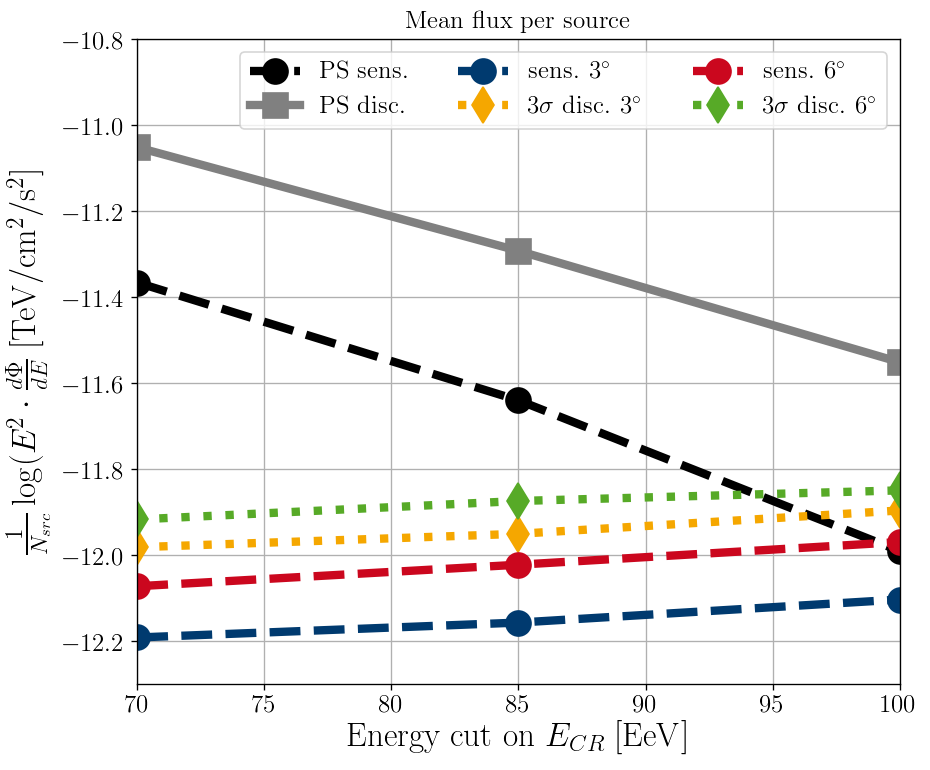

In [30]:
#"""
tw=8
rcParams = dict()
rcParams["figure.figsize"] = (tw, tw/1.2)
rcParams["font.size"]=15
mpl.rcParams.update(rcParams)
#"""
lw1 = 2.
lw2 = 5.
saveplots = True
plt.figure(1, figsize=(8, 8/1.2))
labels=["sens.", r"3$\sigma$ disc.", r"5$\sigma$ disc."]
"""
plt.fill_between(ecuts, np.log10(min(s_sens[1])), np.log10(max(s_sens[1])), 
                 alpha=0.25, label="Sens. 7yr PS", color="0")
plt.fill_between(ecuts, np.log10(min(s_disc[1])), np.log10(max(s_disc[1])), 
                 alpha=0.25, label="Disc. 7yr PS", color="0.5", hatch="/")
#"""

styles = defaultdict(sens=dict(lw=lw2, markersize=15, marker="o", linestyle="--"),
              disc3=dict(lw=lw2, markersize=15, marker="d", linestyle=":"),
              disc5=dict(lw=lw2, markersize=15, marker="s", linestyle="-")
             )
kw = ["sens", "disc3", "disc5"]
plt.plot(ecuts, np.log10(stefan_sens), color="0", label="PS sens.", **styles["sens"])
plt.plot(ecuts, np.log10(stefan_disc), color="0.5", label="PS disc.", **styles["disc5"])

# split flux into parts for each md value
ff = np.split(np.array(final_flux), len(mdparams))
md_labels = [r" $3^\circ$", r" $6^\circ$"] #\cdot E/EeV
# then loop over md values
for i,f in enumerate(ff):
    vals = [f[b::len(bg_quantiles)] for b in xrange(len(bg_quantiles))]
    for j,vv in enumerate(vals):
        #if j==1: continue
        vx, vy = vv[:, 0], vv[:, 1]
        plt.plot(vx, np.log10(vy), 
                 label=labels[j]+md_labels[i], 
                 **styles[kw[j]]
                )

plt.xlim(min(ecuts), max(ecuts))
plt.ylim(-12.3, -10.8)

plt.grid(True)
plt.xlabel(r"Energy cut on $E_{CR} \;[\mathrm{EeV}] $", fontdict=dict(fontsize=20))
plt.ylabel(r"$\frac{1}{N_{src}} \log (E^{2}\cdot \frac{d\Phi}{dE} \; [\mathrm{TeV}/\mathrm{cm}^2/\mathrm{s}^2]$", fontdict=dict(fontsize=20)) #Threshold flux in 
plt.legend(ncol=3, loc=1)
plt.title("Mean flux per source")

if saveplots: plt.savefig(os.path.join(figurepath, "flux_comparison_7yr_with_ps_average_percentile_TS-cut.png"))
plt.show()

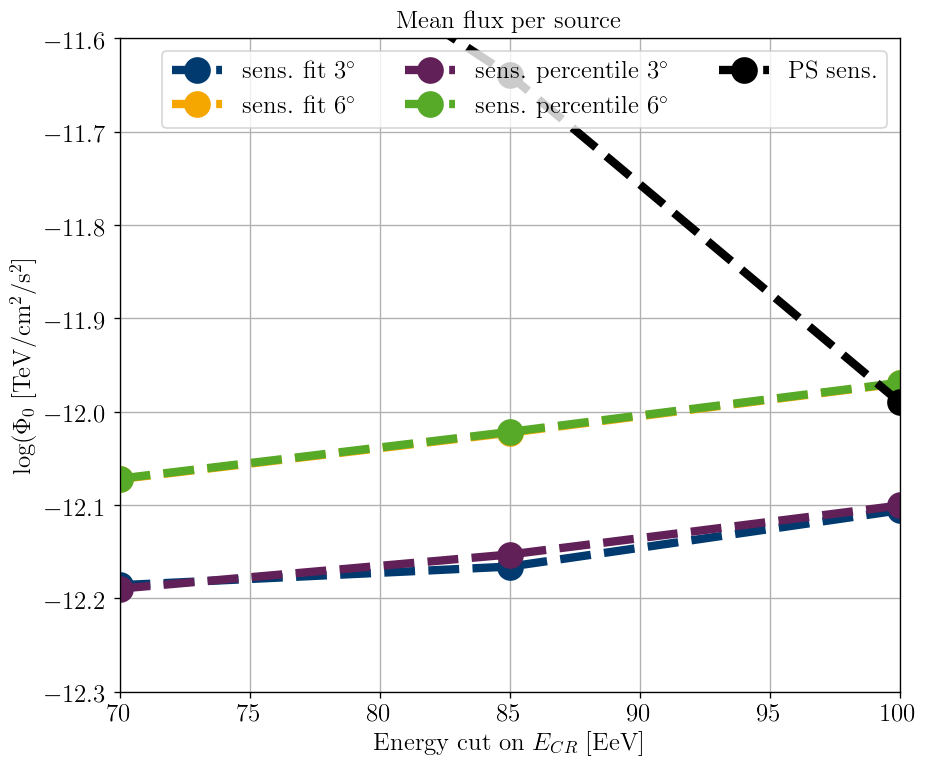

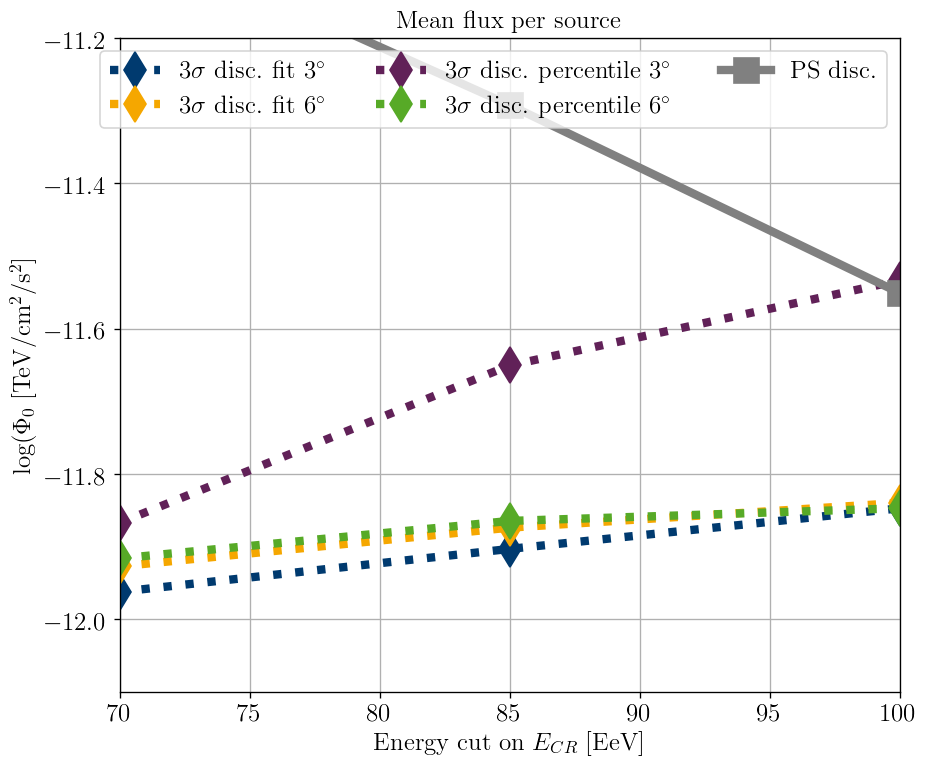

In [67]:
#"""
tw=8
rcParams = dict()
rcParams["figure.figsize"] = (tw, tw/1.2)
mpl.rcParams.update(rcParams)
#"""
lw1 = 2.
lw2 = 5.
saveplots = True
plt.figure(1, figsize=(8, 8/1.2))

styles = defaultdict(sens=dict(lw=lw2, markersize=15, marker="o", linestyle="--"),
              disc3=dict(lw=lw2, markersize=15, marker="d", linestyle=":"),
              disc5=dict(lw=lw2, markersize=15, marker="s", linestyle="-")
             )
kw = ["sens", "disc3", "disc5"]


# split flux into parts for each md value
ff = np.split(np.array(final_flux_fit), len(mdparams))
labels=["sens. fit", r"3$\sigma$ disc. fit", r"5$\sigma$ disc. fit"]
bg_quantiles = [erfc(0.)*0.5, erfc(3./np.sqrt(2))*0.5, erfc(5./np.sqrt(2))*0.5]
md_labels = [r" $3^\circ$", r" $6^\circ$"] #\cdot E/EeV
# then loop over md values
for i,f in enumerate(ff):
    vals = [f[b::len(bg_quantiles)] for b in xrange(len(bg_quantiles))]
    for j,vv in enumerate(vals):
        if j==2: continue
        vx, vy = vv[:, 0], vv[:, 1]
        plt.figure(j)
        plt.plot(vx, np.log10(vy), 
                 label=labels[j]+md_labels[i], 
                 **styles[kw[j]]
                )
        
# split flux into parts for each md value
ff = np.split(np.array(final_flux_percentile), len(mdparams))
bg_quantiles = [erfc(0.)*0.5, erfc(3./np.sqrt(2))*0.5]
labels=["sens. percentile", r"3$\sigma$ disc. percentile"]#, r"5$\sigma$ disc. percentile"]
# then loop over md values
for i,f in enumerate(ff):
    vals = [f[b::len(bg_quantiles)] for b in xrange(len(bg_quantiles))]
    for j,vv in enumerate(vals):
        if j==2: continue
        vx, vy = vv[:, 0], vv[:, 1]
        plt.figure(j)
        plt.plot(vx, np.log10(vy), 
                 label=labels[j]+md_labels[i], 
                 **styles[kw[j]]
                )



plt.figure(0)
plt.plot(ecuts, np.log10(stefan_sens), color="0", label="PS sens.", **styles["sens"])
plt.xlim(min(ecuts), max(ecuts))
plt.grid(True)
plt.xlabel(r"Energy cut on $E_{CR} \;[\mathrm{EeV}] $")
plt.ylabel(r"$\log (\Phi_0 \; [\mathrm{TeV}/\mathrm{cm}^2/\mathrm{s}^2]$") #Threshold flux in 
plt.legend(ncol=3, loc=1)
plt.title("Mean flux per source")
plt.ylim(-12.3, -11.6)
if saveplots: plt.savefig(os.path.join(figurepath, "flux_comparison_7yr_fit_vs_percentile_sens.png"))



plt.figure(1)
plt.plot(ecuts, np.log10(stefan_disc), color="0.5", label="PS disc.", **styles["disc5"])
plt.ylim(-12.1, -11.2)
plt.xlim(min(ecuts), max(ecuts))
plt.grid(True)
plt.xlabel(r"Energy cut on $E_{CR} \;[\mathrm{EeV}] $")
plt.ylabel(r"$\log (\Phi_0 \; [\mathrm{TeV}/\mathrm{cm}^2/\mathrm{s}^2]$") #Threshold flux in 
plt.legend(ncol=3, loc=1)
plt.title("Mean flux per source")
if saveplots: plt.savefig(os.path.join(figurepath, "flux_comparison_7yr_fit_vs_percentile_3disc.png"))

plt.show()

## Comparison with Rameez

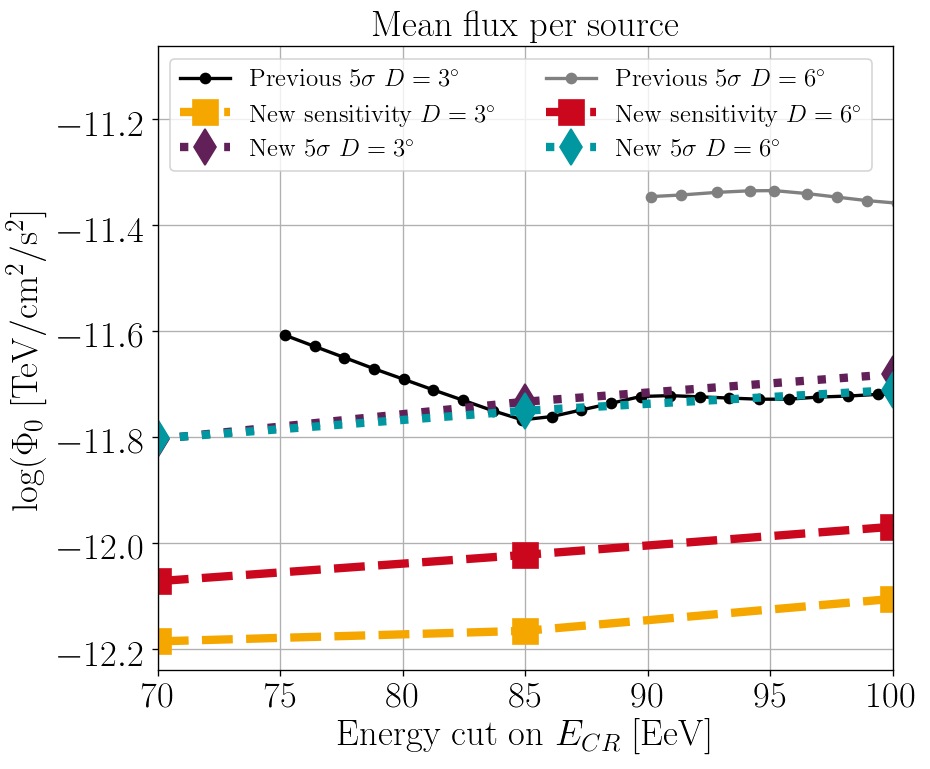

In [18]:
"""
tw=8
rcParams = dict()
rcParams["figure.figsize"] = (tw, tw/1.2)
mpl.rcParams.update(rcParams)
#"""
utils.fontsize=15
utils.scaler=1.5
plt=utils.plotting("pdf")
lw1 = 2.
lw2 = 5.
labels=["New sensitivity", r"New 3$\sigma$", r"New 5$\sigma$"]

plt.figure(1, figsize=(8, 8/1.2))

old_data_6 = np.genfromtxt(os.path.join(crpath,"disc_pot_D6.csv"), delimiter=",")
old_data_3 = np.genfromtxt(os.path.join(crpath,"disc_pot_D3.csv"), delimiter=",")

e_t_6 = old_data_6[:,0]
fl_6 = old_data_6[:,1]
e_t_3 = old_data_3[:,0]
fl_3 = old_data_3[:,1]
conversion = np.sqrt(4./7.)
#plt.plot(e_t_6, np.log10(fl_6*conversion), label=r"Previous disc. $D=6^\circ$", color="0.3")
#plt.plot(e_t_3, np.log10(fl_3*conversion), label=r"Previous disc. $D=3^\circ$", color="0")

# split flux into parts for each md value
ff = np.split(np.array(final_flux), len(mdparams))
md_labels = [r" $D=3^\circ$", r" $D=6^\circ$"] #\cdot E/EeV
# then loop over md values
for i,f in enumerate(ff):
    vals = [f[b::len(bg_quantiles)] for b in xrange(len(bg_quantiles))]
    if i==0:
        plt.plot(e_t_3, np.log10(fl_3*conversion), label=r"Previous 5$\sigma$ $D=3^\circ$", color="0")
    if i==1:
        plt.plot(e_t_6, np.log10(fl_6*conversion), label=r"Previous 5$\sigma$ $D=6^\circ$", color="0.5")
    for j,vv in enumerate(vals):
        if j==1: continue
        vx, vy = vv[:, 0], vv[:, 1]
        plt.plot(vx, np.log10(vy), 
                 lw=lw2, markersize=15, 
                 label=labels[j]+md_labels[i]
                )
plt.xlim(min(ecuts), max(ecuts))

plt.grid(True)
plt.xlabel(r"Energy cut on $E_{CR} \;[\mathrm{EeV}] $")
plt.ylabel(r"$\log (\Phi_0 \; [\mathrm{TeV}/\mathrm{cm}^2/\mathrm{s}^2]$") #Threshold flux in 
plt.legend(ncol=2, loc=2)
plt.title("Mean flux per source")

plt.savefig(os.path.join(figurepath, "flux_comparison_7yr_with_2014scaled.png"))
plt.show()

## Calculating inj-fit distances

In [5]:
def angular_distance(x1, x2):
    """ 
    Compute the angular distance between 2 vectors on a unit sphere
    Parameters :
        x1/2: Vector with [declination, right-ascension], i.e.
              shape (2,n) where n can also be zero. One can compute
              the distance for n pairs of vectors
    Return :
        cosine of angular distance, in order to get the angular
        distance in rad, take arccos of result
    """
    x1=np.array(x1)
    x2=np.array(x2)
    assert(len(x1)==len(x2)==2)
    return np.arccos(np.sin(x1[0]) * np.sin(x2[0]) + np.cos(x1[0]) * np.cos(x2[0]) * np.cos(x1[1]-x2[1]))

def angular_dist(delta1, alpha1, delta2, alpha2):
    """
    Calculate the angular distance of two directions 1 and 2, 
    given as delta=declination and alpha=right ascension
    
    delta : declination
    alpha : right ascension
    
    can be single values or numpy.arrays (1D)
    single values are converted to single-entry arrays so that the vector/matrix calculations work
    """
    
    delta1 = np.atleast_1d(delta1)
    delta2 = np.atleast_1d(delta2)
    alpha1 = np.atleast_1d(alpha1)
    alpha2 = np.atleast_1d(alpha2)
    
    # We now check that all arrays have the same length
    assert(len(delta1)==len(alpha1))
    assert(len(delta2)==len(alpha2))
    
    return np.arccos(np.sin(delta1)[np.newaxis].T*np.sin(delta2)+np.cos(delta1)[np.newaxis].T*np.cos(delta2)*np.cos(alpha1[np.newaxis].T-alpha2))#.flatten()

colors = sns.cubehelix_palette(len(ecuts), start=0., rot=.2, dark=0.2, light=0.7, reverse=True, hue=2)
colors.extend(sns.cubehelix_palette(len(ecuts), start=1.5, rot=.2, dark=0.2, light=0.7, reverse=True, hue=2))

NameError: name 'ecuts' is not defined

In [21]:
distance_cut = 0.5
bins = 80
range = (0,40)
ratios = dict()
n1_vals = dict()
n2_vals = dict()
fcounter = 0

for md in mdparams:
    #print "md", md
    ratios[md]=dict()
    n1_vals[md] = dict()
    n2_vals[md] = dict()
    for ecut in ecuts:
        n1_vals[md][ecut] = dict()
        n2_vals[md][ecut] = dict()
        ratios[md][ecut]=dict()
        for i,ak in enumerate(signals[md][ecut]):
            #print "ak", ak
            nsig = np.array(signals[md][ecut][ak])
            # Calculate distance from one hotspot to the matching injected source
            # This way we see which injected sources have actually been found
            distance = np.degrees(angular_distance([nsig['dec'], nsig['ra']],
                                                   [nsig['dec_inj'], nsig['ra_inj']])).flatten()
            n1 = np.count_nonzero(distance<=distance_cut)*1./len(distance)
            n1_vals[md][ecut][ak] = n1
            #n1 = n1*1./len(distance)
            # Calculate distance from all hotspots to all other injected sources
            # Then, find the minimum distance for each
            # This way, we see also hotspots that have been fitted multiple times
            distance = np.degrees(angular_dist(nsig['dec'], 
                                               nsig['ra'],
                                               nsig['dec_inj'], 
                                               nsig['ra_inj']))

            distance = np.min(distance, axis=-1).flatten()
            n2 = np.count_nonzero(distance<=distance_cut)*1./len(distance)
            n2_vals[md][ecut][ak] = n2
            #n2 = n2*1./len(distance)

            ratios[md][ecut][ak] = (n2-n1)*1./n1 #-n1


print "done"

done


In [46]:
print final_n

{3.0: {100: {'sens': 3.7192136819936183, 'disc3': 6.7483659302857975, 'disc5': 9.8789987971983191}, 85: {'sens': 3.1960897592172128, 'disc3': 5.8613534390539241, 'disc5': 8.6991762943308881}, 70: {'sens': 3.0661718213967433, 'disc3': 5.1093166901276579, 'disc5': 7.3384401517742006}}, 6.0: {100: {'sens': 5.0679943900913358, 'disc3': 6.8261024492972817, 'disc5': 9.183036790270938}, 85: {'sens': 4.4757058218856365, 'disc3': 6.2983475379215266, 'disc5': 8.3733858454335461}, 70: {'sens': 3.9880817522022234, 'disc3': 5.5586265690892196, 'disc5': 7.3895673179709673}}}


In [126]:
tw = 8
gr = 1.5 #0.5*(1. + np.sqrt(5))
rcParams = dict()
rcParams["figure.figsize"] = (tw, tw/gr)
mpl.rcParams.update(rcParams)

markers = ["o", "d", "s"]
saveplots = True

f1, a1 = plt.subplots(1, 2, sharey=True)
a1[0].set_title(r"Direct matches")

f2, a2 = plt.subplots(1, 2, sharey=True)
a2[0].set_title(r"Overall matches")

f3, a3 = plt.subplots(1, 2, sharey=True)
a3[0].set_title(r"Rel. difference: (o-d)/d") #(overall-direct)/direct

for j,ecut in enumerate(ecuts):
    for m,md in enumerate(mdparams):
        marker=markers[j]
        label = "{}EeV, D={:1.0f}".format(ecut, md)
        r = np.empty(len(ratios[md][ecut].keys()))
        n1 = np.empty(len(ratios[md][ecut].keys()))
        n2 = np.empty(len(ratios[md][ecut].keys()))
        mu_inj = np.empty(len(ratios[md][ecut].keys()))
        for i,ak in enumerate(ratios[md][ecut]):
            r[i] = ratios[md][ecut][ak]
            n1[i] = n1_vals[md][ecut][ak]
            n2[i] = n2_vals[md][ecut][ak]
            mu_inj[i] = ak
        idx = np.argsort(mu_inj)        
        
        a1[m].plot(mu_inj[idx], n1[idx], marker=marker, color=colors[j+m*len(ecuts)], label=label)
        fit = np.poly1d(np.polyfit(mu_inj[idx], n1[idx], 2))
        a1[m].plot(final_n[md][ecut]['sens'], fit(final_n[md][ecut]['sens']), color="k", marker="*") 
        a1[m].plot(final_n[md][ecut]['disc5'], fit(final_n[md][ecut]['disc5']), color="k", marker="p")
        a1[m].legend(loc=2, ncol=1)
        a1[m].set_xlabel(r"$n_{inj}$")
        a1[m].set_xlim(0,15)
        a1[m].set_ylim(0., 0.65)
        
        a2[m].plot(mu_inj[idx], n2[idx], marker=marker, color=colors[j+m*len(ecuts)], label=label)
        fit = np.poly1d(np.polyfit(mu_inj[idx], n2[idx], 2))
        a2[m].plot(final_n[md][ecut]['sens'], fit(final_n[md][ecut]['sens']), color="k", marker="*")
        a2[m].plot(final_n[md][ecut]['disc5'], fit(final_n[md][ecut]['disc5']), color="k", marker="p")
        a2[m].legend(loc=2, ncol=1)
        a2[m].set_xlabel(r"$n_{inj}$")
        a2[m].set_xlim(0,15)
        a2[m].set_ylim(0., 1.)
                
        a3[m].plot(mu_inj[idx], r[idx], marker=marker, color=colors[j+m*len(ecuts)], label=label)
        fit = np.poly1d(np.polyfit(mu_inj[idx], r[idx], 2))
        a3[m].plot(final_n[md][ecut]['sens'], fit(final_n[md][ecut]['sens']), color="k", marker="*")
        a3[m].plot(final_n[md][ecut]['disc5'], fit(final_n[md][ecut]['disc5']), color="k", marker="p")
        a3[m].legend(loc=2, ncol=1)
        a3[m].set_xlabel(r"$n_{inj}$")
        a3[m].set_xlim(0,15)
        a3[m].set_ylim(0.1,50)
        a3[m].semilogy()
        
if saveplots: f1.savefig(os.path.join(figurepath, "HSP_direct_match_performance.png"))
if saveplots: f2.savefig(os.path.join(figurepath, "HSP_overall_match_performance.png"))
if saveplots: f3.savefig(os.path.join(figurepath, "HSP_rel_diff_performance.png"))#"""

plt.show()

## Prior map with HSP

In [ ]:
t = UhecrPriorGenerator(6)
fcounter=0
for m,md in enumerate(mdparams):   
    for j,ecut in enumerate(ecuts):
        template = t.calc_template(np.radians(md),
                        t._get_UHECR_positions(ecut,
                        data_path=crpath))#"/home/home2/institut_3b/lschumacher/phd_stuff/phd_code_git/data"))
        print("Selected {} CRs".format(t.n_uhecr))
        print("Above energies of {} EeV".format(min(t.energy)))
        print("Smeared with {} deg prior".format(md))

        tm = np.exp(template)
        tm = tm/tm.sum(axis=1)[np.newaxis].T
        tm = tm.sum(axis=0)
        vmin = 0
        vmax = max(tm)
        for i,ak in enumerate(signals[md][ecut]):
            fig, ax = utils.skymap(plt, tm, cmap=utils.cmap,
                                   vmin=vmin, vmax=vmax,
                                   rasterized=True)
            #if ak < 8: continue
            print "mu_inj:", ak
            print "plot: ", fcounter
            sig = np.array(signals[md][ecut][ak])
            ax.plot([np.pi-sig['ra'][0].flatten(), np.pi-sig['ra_inj'][0].flatten()], 
                     [sig['dec'][0].flatten(), sig['dec_inj'][0].flatten()],
                     marker="o", ls="-", lw=1, markersize=3
                    )
            plt.savefig(os.path.join(figurepath, str(fcounter)+"_HSP_prior_line_visualization_ecut{}_md{}_mu{}.png".format(ecut, md, ak)))
            fcounter+=1
            plt.show()
            #break
        #break
    #break

#plt.savefig(join(figurepath, "full_test_template.png"))

In [ ]:
t = UhecrPriorGenerator(6)
fcounter=0
for m,md in enumerate(mdparams):   
    for j,ecut in enumerate(ecuts):
        template = t.calc_template(np.radians(md),
                        t._get_UHECR_positions(ecut,
                        data_path=crpath))#"/home/home2/institut_3b/lschumacher/phd_stuff/phd_code_git/data"))
        print("Selected {} CRs".format(t.n_uhecr))
        print("Above energies of {} EeV".format(min(t.energy)))
        print("Smeared with {} deg prior".format(md))

        tm = np.exp(template)
        tm = tm/tm.sum(axis=1)[np.newaxis].T
        tm = tm.sum(axis=0)
        vmin = 0
        vmax = max(tm)
        for i,ak in enumerate(signals[md][ecut]):
            fig, ax = utils.skymap(plt, tm, cmap=utils.cmap,
                                   vmin=vmin, vmax=vmax,
                                   rasterized=True)
            #if ak < 8: continue
            print "mu_inj:", ak
            print "plot: ", fcounter
            sig = np.array(signals[md][ecut][ak])
            #"""
            ax.scatter(np.pi-sig['ra'][0].flatten(), 
                        sig['dec'][0].flatten(), 
                        marker="o", 
                        alpha=0.15, 
                        color="cyan",
                        label="Fitted",
                        s=sig['nsources'][0].flatten()**2)
            #"""
            #"""
            ax.scatter(np.pi-sig['ra_inj'][0].flatten(), 
                        sig['dec_inj'][0].flatten(), 
                        marker="o", 
                        alpha=0.25, 
                        color="orange",
                        label="Injected",
                        s=sig['n_inj'][0].flatten()**2)
                        #"""
            plt.savefig(os.path.join(figurepath, str(fcounter)+"_HSP_prior_dot_visualization_ecut{}_md{}_mu{}.png".format(ecut, md, ak)))
            fcounter+=1
            plt.show()
            #break
        #break
    #break

#plt.savefig(join(figurepath, "full_test_template.png"))

md:  3.0
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
mu injected:  8.0
44


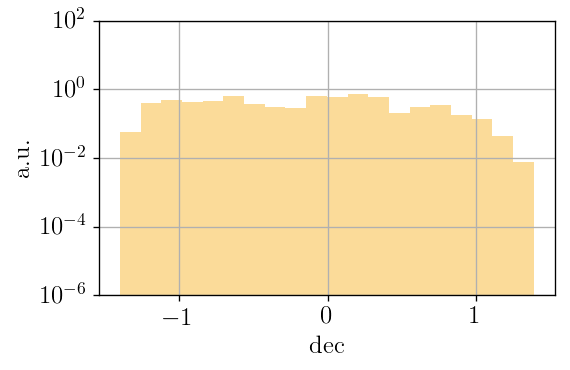

mu injected:  2.0
45


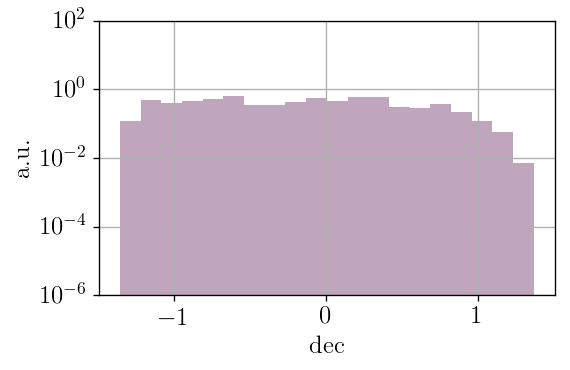

mu injected:  4.0
46


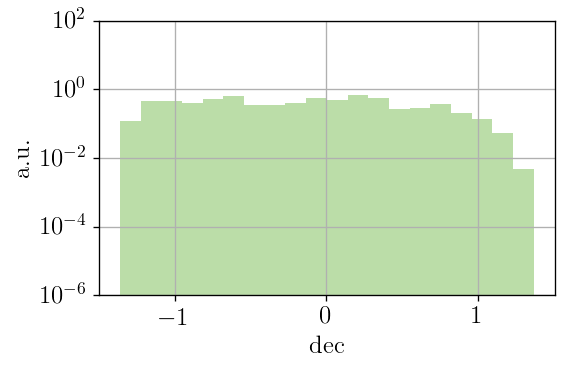

mu injected:  7.0
47


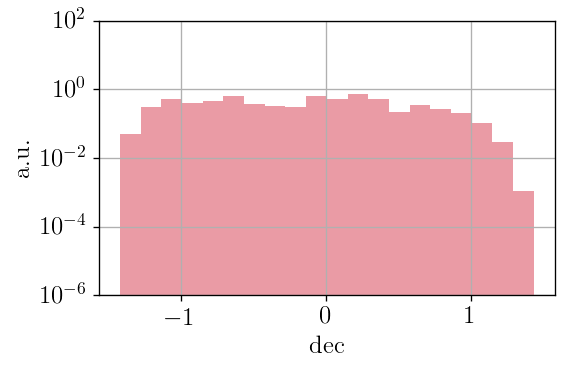

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
mu injected:  8.0
48


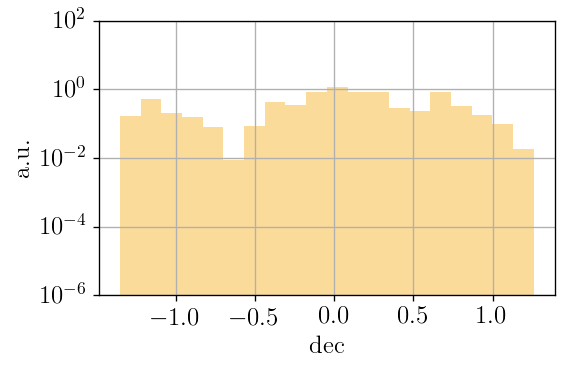

mu injected:  10.0
49


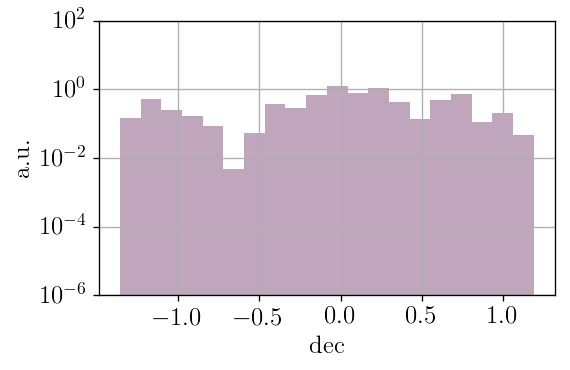

mu injected:  4.0
50


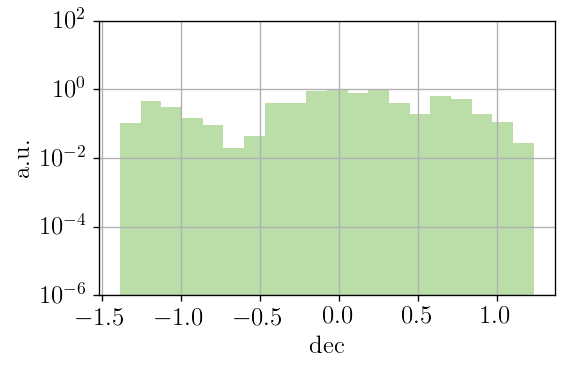

mu injected:  2.0
51


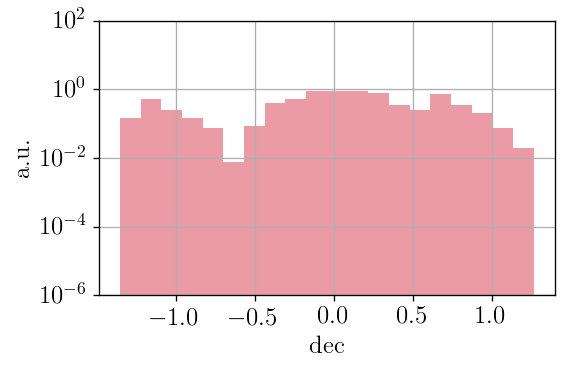

mu injected:  6.0
52


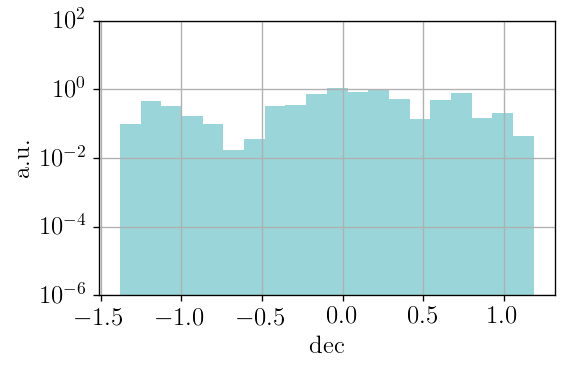

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
mu injected:  10.0
53


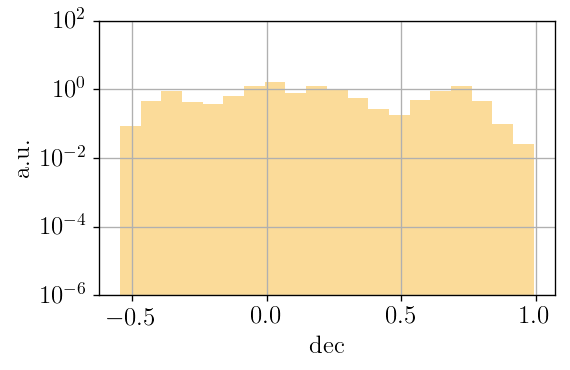

mu injected:  3.0
54


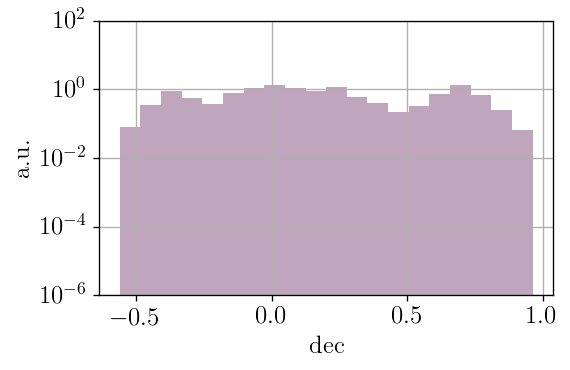

mu injected:  5.0
55


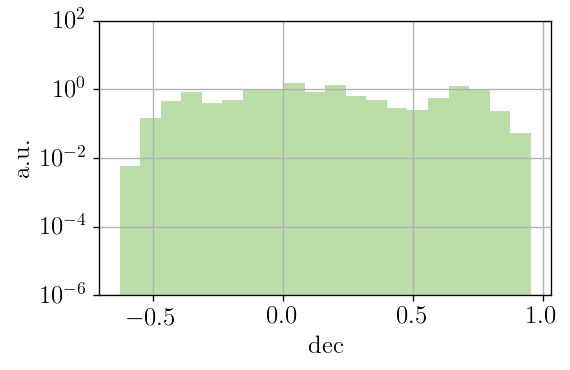

mu injected:  7.0
56


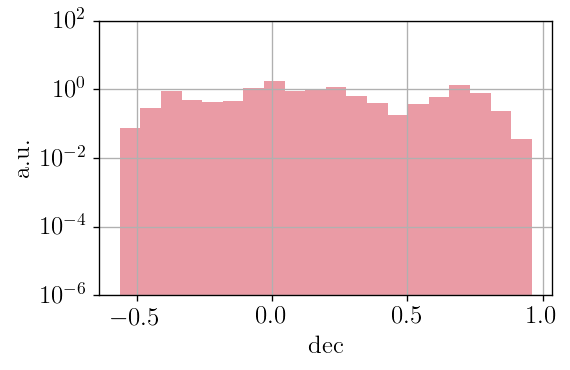

md:  6.0
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
mu injected:  2.5
57


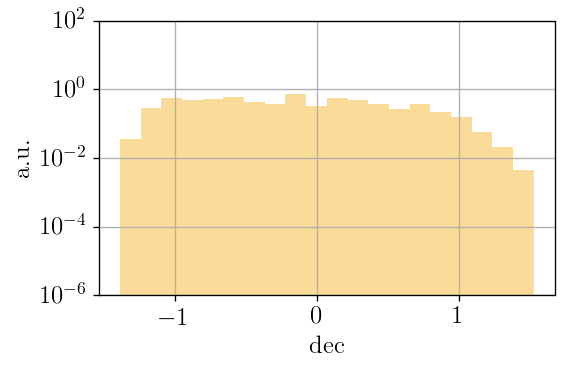

mu injected:  3.5
58


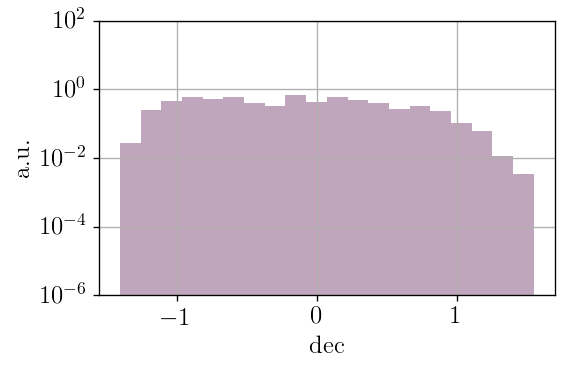

mu injected:  3.0
59


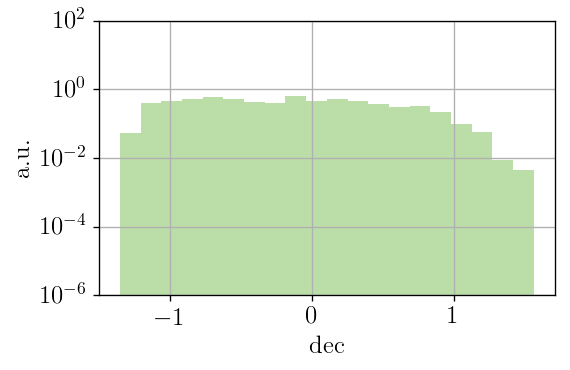

mu injected:  4.0
60


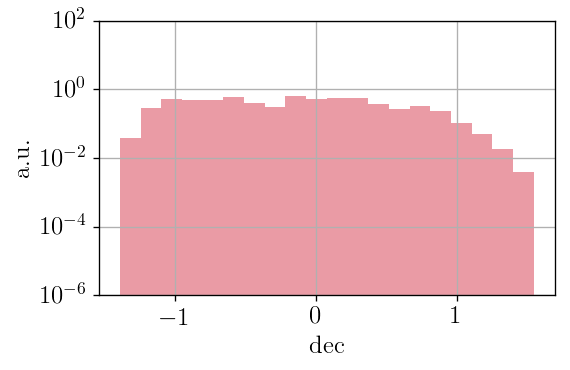

mu injected:  6.0
61


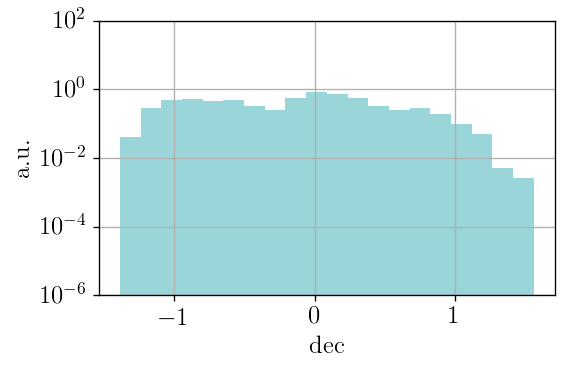

mu injected:  8.0
62


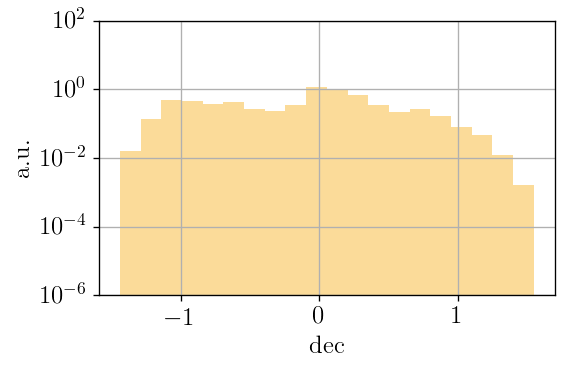

mu injected:  10.0
63


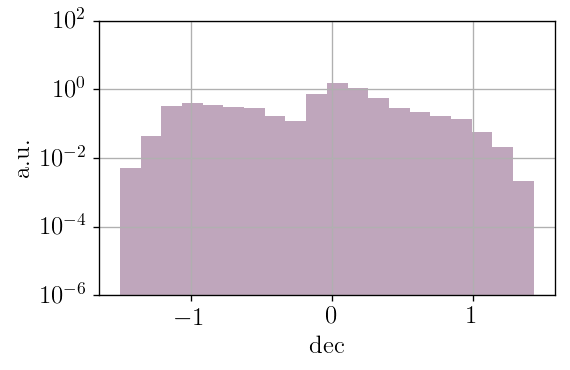

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
mu injected:  10.5
64


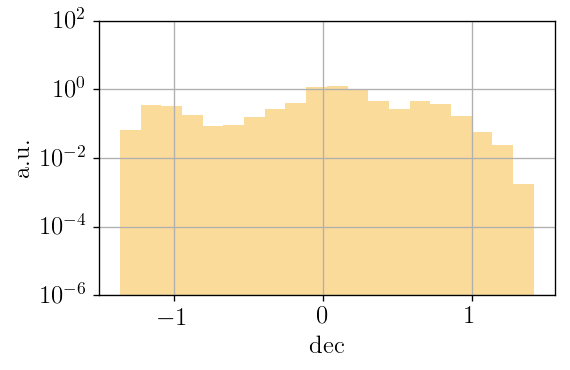

mu injected:  11.5
65


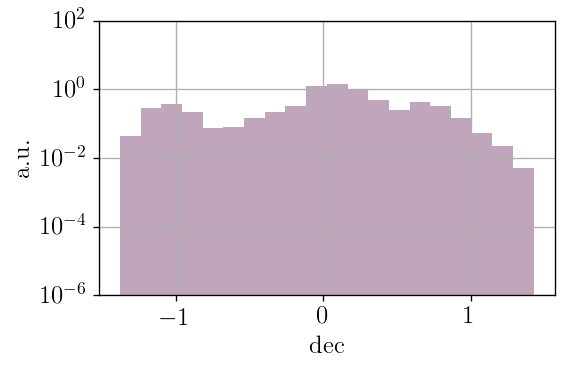

mu injected:  3.0
66


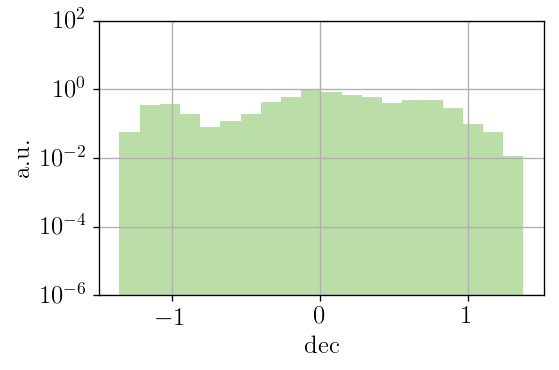

mu injected:  4.0
67


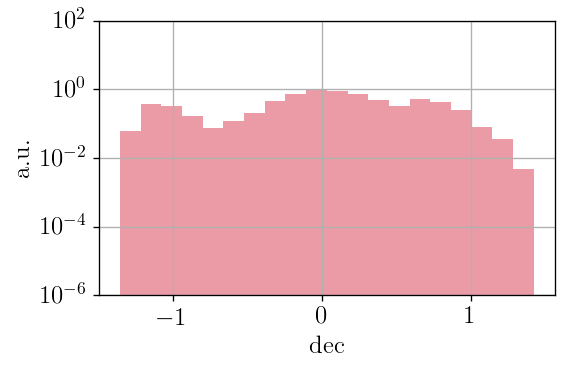

mu injected:  5.0
68


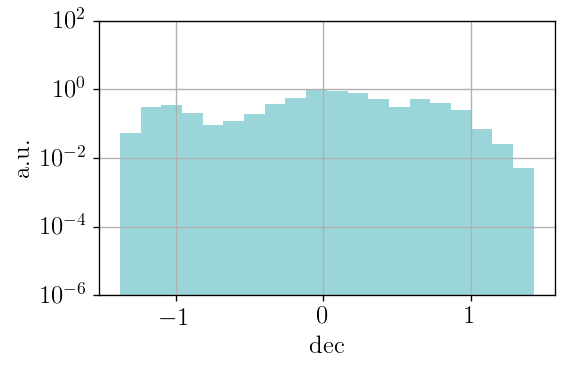

mu injected:  4.4
69


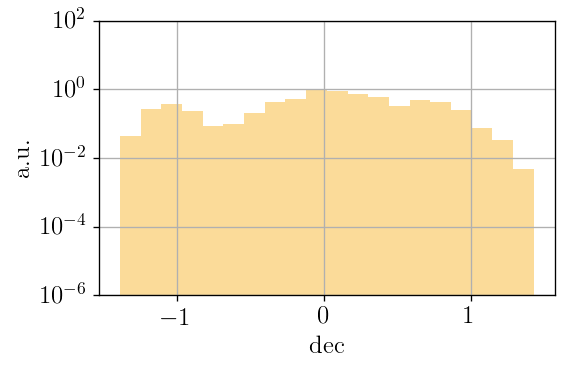

mu injected:  11.0
70


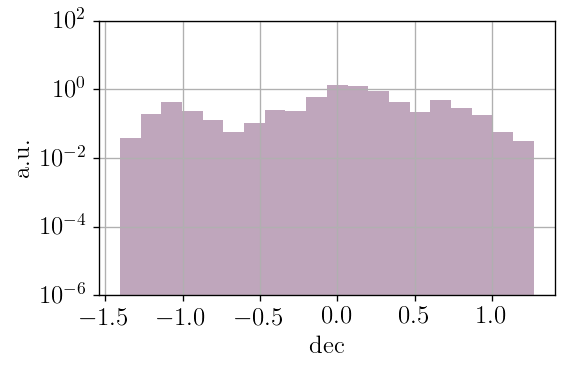

mu injected:  4.2
71


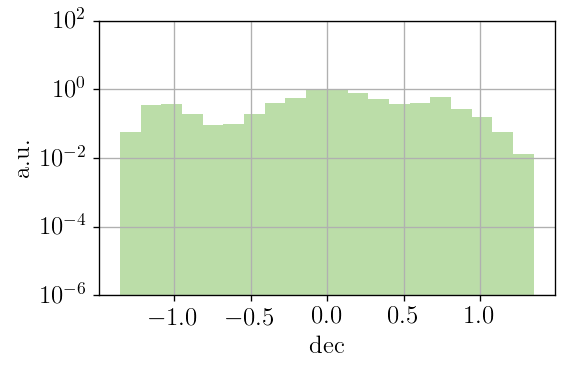

mu injected:  4.6
72


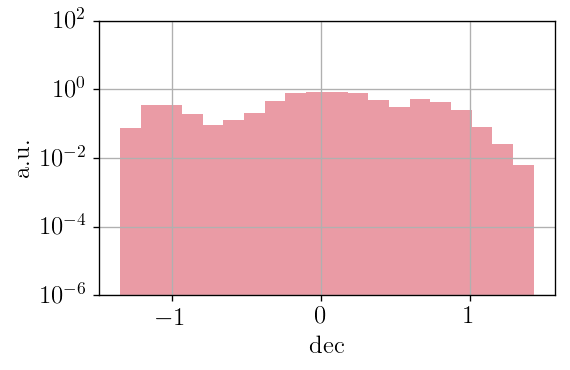

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
mu injected:  4.5
73


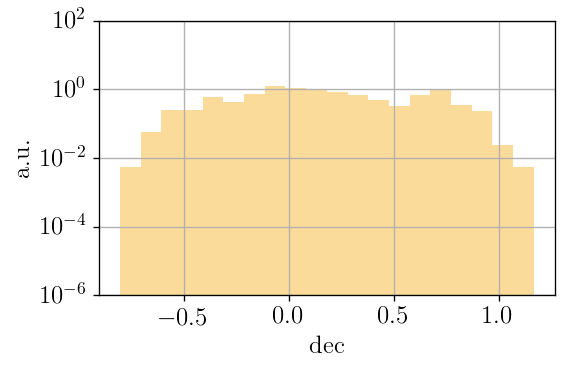

mu injected:  5.5
74


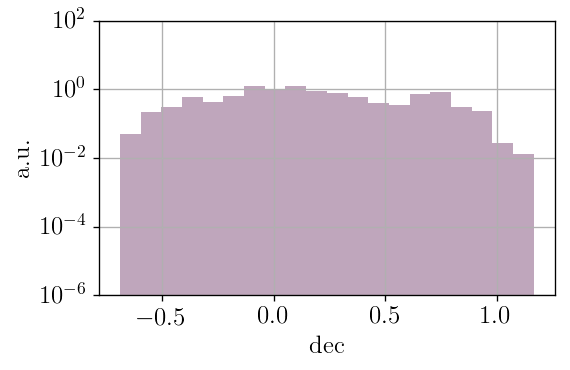

mu injected:  4.0
75


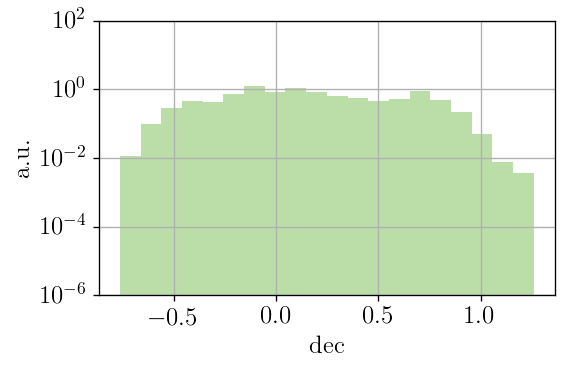

mu injected:  5.0
76


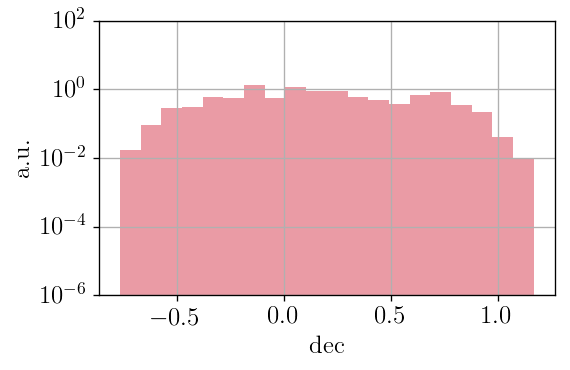

mu injected:  6.0
77


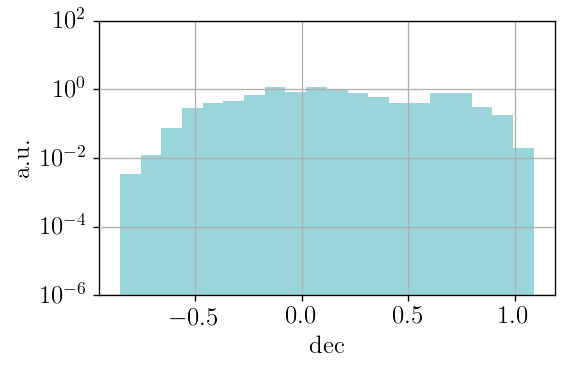

mu injected:  8.0
78


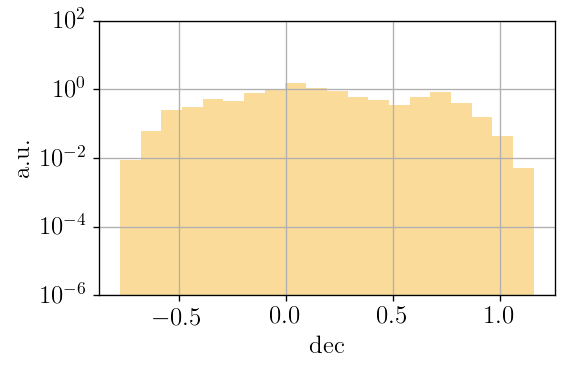

mu injected:  10.0
79


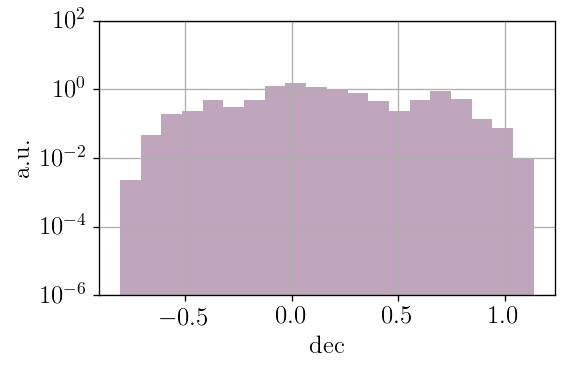

mu injected:  12.0
80


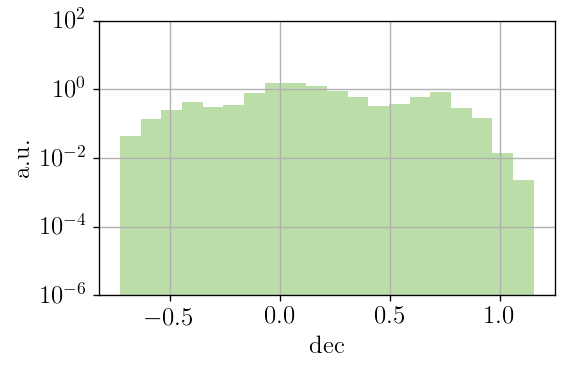

mu injected:  14.0
81


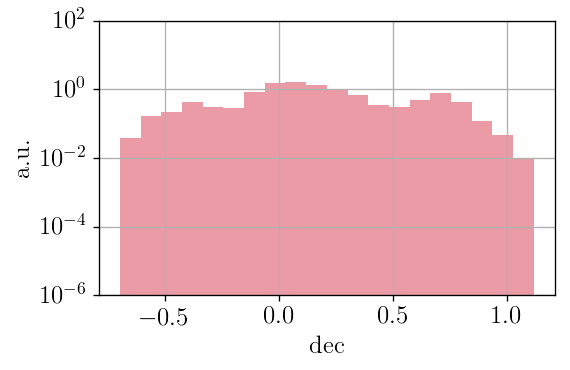

In [47]:
tw = 5
gr = 1.5 #0.5*(1. + np.sqrt(5))
rcParams = dict()
rcParams["figure.figsize"] = (tw, tw/gr)
mpl.rcParams.update(rcParams)

## With different cuts on E
## Sensitivity and disc pot


figure_counter = 43
for md in mdparams:
    print "md: ", md 
    for ecut in ecuts:
        print " * "*20 
        ## Use Percentiles, because most fits are unstable
        bins=20 
        sig_val = []
        #plotting=True
        for i,ak in enumerate(signals[md][ecut]): 
            print "mu injected: ", ak
            signals[md][ecut][ak] = np.array(signals[md][ecut][ak])
            best = signals[md][ecut][ak]['dec'].flatten()
            
            plt.figure(figure_counter)
            figure_counter+=1
            sns.distplot(best, bins=bins, rug=False, kde=False, 
                        hist_kws=dict(normed=True, color=utils.colors[i%(clen-1) +1]), 
                        fit_kws=dict( color=utils.colors[i%(clen-1) +1]),
                        #label=r"$\langle n_{{inj}} \rangle $={:1.0f}".format(sig_val[-1][0])
                        ) 
            plt.legend(loc=2, ncol=2)
            plt.ylim(1e-6,1e2)
            plt.xlabel("dec")
            plt.ylabel("a.u.")
            plt.semilogy(nonposy="clip") 
            print figure_counter
            plt.show()